# Plastic Map

The Plastic Map was created by the Remote Sensing of Coastal and Urban Environments (RESCUE) research group at Federal University of Rio Grande do Sul (UFRGS), with the contributions of researchers Bianca Matos de Barros, Cristiano Lima Hackmann, and Douglas Galimberti Barbosa. If you'd like to get in touch, please send an email to bianca.matos@ufrgs.br.

## Imports

First, we begin by importing the necessary Python libraries for the algorithm. Please ensure that these libraries are installed in your Python environment for the imports to function correctly.

In [1]:
from modules import dart_files, rsdata_classification, rsdata_charts
#from modules import dart_files, tiff_files, rsdata_classification, rsdata_charts
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score #, balanced_accuracy_score, confusion_matrix, f1_score, fbeta_score, jaccard_score, log_loss, precision_score, recall_score, roc_auc_score
#from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
#from sklearn.neural_network import MLPClassifier
#import datetime
import matplotlib.pyplot as plt
import openpyxl
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import shutil

## Parameters

We are now defining the feature names (columns) that will serve as input for the classifiers.

The 'feature_names' variable contains the names of the MSI/Sentinel-2 sensor bands with spatial resolution equal to 10 meters or 20 meters. The 'radiometric_indexes' variable contains the indices presented by [1] and [2]. 

Note: The NDMI index was also evaluated in [1], but its formula was identical to that of the NDWI index. Therefore, the NDMI index was not considered here.

In [2]:
feature_names = ['Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NIR1', 'NIR2', 'SWIR1', 'SWIR2']
radiometric_indexes = ['NDWI', 'WRI', 'NDVI', 'AWEI', 'MNDWI', 'SR', 'PI', 'RNDVI', 'FDI', 'PWDI']

In this repository, files are organized in the following directory structure:
- **charts**: Contains charts generated during data analysis and classification.
- **modules**: Includes Python modules used in the application.
- **files/csv_files**: Stores reflectance values from compiled datasets, with each CSV file containing a dataset.
- **files/dart_files**: Holds DART (Discrete Anisotropic Radiative Transfer) simulations converted to ASC format.
- **files/raw_dart_files**: Contains original-format DART files.
- **files/tiff_files**: Stores MSI/Sentinel-2 images after atmospheric correction, cropping of regions of interest, and conversion to TIFF format.


## Simulated dataset (DART)

DART files are organized within a directory structure that includes folders identifying the simulations and sensor bands, and files with standard names in MPR or MP# format. To compile reflectance values from the simulated data, it's necessary to convert the files to ASC format. This conversion can be performed using GIS software (such as QGIS). Additionally, it's essential to rename the files to indicate the simulation and the specific band they contain.

In this project, there are two sets of simulated data, one produced in 2021 and another in 2023. The 2021 dataset has already been processed and will be imported at a later stage. The 2023 dataset will undergo an extraction process to fulfill the specified requirements.

### Extracting DART raw files

The 'file_names' variable contains the default filenames that require renaming and conversion to ASC format. The 'info' variable comprises lists, each detailing the source directory, destination directory, 'file_names' variable, submersion depth, color, status (Dry, Wet, or Submerged), and the name of the polymer used for each simulation configuration.

The structure of the 'raw_files' directory, as depicted by the 'info' variable, follows a model based on simulation settings: source_folder/polymer/coverage_percentage/band.

In [3]:
file_names = ['ima01_VZ=000_0_VA=000_0.mp#', 'ima01_VZ=000_0_VA=000_0.mpr']

info = [
            ['files/raw_dart_files/Limpa_S0/LDPE/', 
             'files/dart_files/Sentinel2_artificial/Limpa/LDPE/',
             file_names,
             'S0', 'Transparent', 'Dry', 'LDPE'],
            ['files/raw_dart_files/Limpa_S0/Orange_PP/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PP/',
            file_names,
            'S0', 'Orange', 'Wet', 'PP'],
            ['files/raw_dart_files/Limpa_S0/PET/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PET/',
             file_names,
             'S0', 'Transparent', 'Dry', 'PET'],
            ['files/raw_dart_files/Limpa_S0/White_PP/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PP/',
             file_names,
             'S0', 'White', 'Wet', 'PP'],
            ['files/raw_dart_files/Limpa_S2/Orange_PP/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PP/',
            file_names,
            'S2', 'Orange', 'Submerged', 'PP'],
            ['files/raw_dart_files/Limpa_S2/White_PP/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PP/',
            file_names,
            'S2', 'White', 'Submerged', 'PP'],
            ['files/raw_dart_files/Limpa_S5/Orange_PP/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PP/',
            file_names,
            'S5', 'Orange', 'Submerged', 'PP'],
            ['files/raw_dart_files/Limpa_S5/White_PP/', 
             'files/dart_files/Sentinel2_artificial/Limpa/PP/',
            file_names,
            'S5', 'White', 'Submerged', 'PP'],
            ['files/raw_dart_files/LimpaEspuma_S0/LDPE/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/LDPE/',
             file_names,
             'S0', 'Transparent', 'Dry', 'LDPE'],
            ['files/raw_dart_files/LimpaEspuma_S0/Orange_PP/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PP/',
            file_names,
            'S0', 'Orange', 'Wet', 'PP'],
            ['files/raw_dart_files/LimpaEspuma_S0/PET/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PET/',
             file_names,
             'S0', 'Transparent', 'Dry', 'PET'],
            ['files/raw_dart_files/LimpaEspuma_S0/White_PP/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PP/',
             file_names,
             'S0', 'White', 'Wet', 'PP'],
            ['files/raw_dart_files/LimpaEspuma_S0/Whitecaps/', 
             'files/dart_files/Sentinel2_artificial/Whitecaps/',
             file_names,
             'S0', '-', '-', 'Whitecaps'],
            ['files/raw_dart_files/LimpaEspuma_S2/Orange_PP/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PP/',
            file_names,
            'S2', 'Orange', 'Submerged', 'PP'],
            ['files/raw_dart_files/LimpaEspuma_S2/White_PP/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PP/',
            file_names,
            'S2', 'White', 'Submerged', 'PP'],
            ['files/raw_dart_files/LimpaEspuma_S5/Orange_PP/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PP/',
            file_names,
            'S5', 'Orange', 'Submerged', 'PP'],
            ['files/raw_dart_files/LimpaEspuma_S5/White_PP/', 
             'files/dart_files/Sentinel2_artificial/LimpaEspuma/PP/',
            file_names,
            'S5', 'White', 'Submerged', 'PP']
        ]

The 'info' variable serves as input for the extraction method in the dart_files module. This method, using source and destination paths along with simulation configuration information, creates necessary destination folders and returns a list of paths for exporting files with identifiable names.

Subsequently, the source files are copied to their respective destinations using the obtained export paths.

In [ ]:
for n in range(len(info)):
    paths = dart_files.extraction(info[n][0], info[n][1], info[n][2], info[n][3], info[n][4], info[n][5], info[n][6])
    
    os.chdir('../')
    os.chdir('../')
    os.chdir('../')
    
    for path in paths:
        if os.path.exists(path[0]):
            if os.path.exists(path[1]):
                try:
                    shutil.copyfile(path[0], path[1]+path[2])
                    print("File ", path[1]+path[2], " copied")
                except:
                    print("Error when trying to copy ", path[1]+path[2])
            else:
                try:
                    os.makedirs(path[1])
                    print(path[1], " directory created")
                    try: 
                        shutil.copyfile(path[0], path[1]+path[2])
                        print("File ", path[1]+path[2], " copied")
                    except:
                        print("Error when trying to copy ", path[1]+path[2])
                except:
                    print("Error when trying to create ", path[1], " directory")
        else:
            print(path[0], " does not exist")

Now, it's essential to convert the data from MPR/MP# to ASC format. This conversion can be accomplished using software like QGIS. Once the conversion is complete, ensure that the converted files are stored within the existing folder structure. This step is crucial for the application to locate and compile them seamlessly in the subsequent sections.

### Getting directory and file structure

The 'source_folders' variable holds a list of directories containing DART files. 

Each folder should adhere to the following structure:
source_folder/polymer/submersion_depth/color/status (Dry, Wet, or Submerged)/cover_percent/dart .asc files representing each of the sensor bands.

In [4]:
source_folders = [
            'files/dart_files/Sentinel2_Artificial/Limpa/',
            'files/dart_files/Sentinel2_Artificial/LimpaEspuma/',
            'files/dart_files/Sentinel2_Artificial/Whitecaps/'
            ]
paths = dict()

for folder in source_folders:
    tree = dart_files.get_directory_tree(folder)
    paths[folder] = tree
    os.chdir('../')
    os.chdir('../')
    os.chdir('../')
    os.chdir('../')
    
paths

{'files/dart_files/Sentinel2_Artificial/Limpa/': {'LDPE': {'S0': {'Transparent': {'Dry': ['100',
      '40',
      '60',
      '80']}}},
  'PET': {'S0': {'Transparent': {'Dry': ['100', '40', '60', '80']}}},
  'PP': {'S0': {'Orange': {'Wet': ['100', '40', '60', '80']},
    'White': {'Wet': ['100', '40', '60', '80']}},
   'S2': {'Orange': {'Submerged': ['100', '40', '60', '80']},
    'White': {'Submerged': ['100', '40', '60', '80']}},
   'S5': {'Orange': {'Submerged': ['100', '40', '60', '80']},
    'White': {'Submerged': ['100', '40', '60', '80']}}}},
 'files/dart_files/Sentinel2_Artificial/LimpaEspuma/': {'LDPE': {'S0': {'Transparent': {'Dry': ['40',
      '60',
      '80']}}},
  'PET': {'S0': {'Transparent': {'Dry': ['40', '60', '80']}}},
  'PP': {'S0': {'Orange': {'Wet': ['40', '60', '80']},
    'White': {'Wet': ['40', '60', '80']}},
   'S2': {'Orange': {'Submerged': ['40', '60', '80']},
    'White': {'Submerged': ['40', '60', '80']}},
   'S5': {'Orange': {'Submerged': ['40', '60', '

The 'paths' variable represents the whole directory structure that will be used as input for compiling the simulated information.

### Resampling

DART simulations consist of files containing numerical matrices representing reflectance values in each sensor band. Due to the varied spatial resolutions of the simulated sensor bands, the files exhibit matrices of different sizes. Therefore, compiling simulated information necessitates a resampling strategy.

In this section, we create datasets by compiling the 2023 DART simulated database, while experimenting with various resampling strategies for subsequent evaluation.

#### Resampling 20 meter bands by nearest neighbor

In [5]:
nn_data2023_10 = dart_files.get_images(paths, "nearest", "up")

files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/ ['LDPE_Blue_100.asc', 'LDPE_Green_100.asc', 'LDPE_NIR1_100.asc', 'LDPE_NIR2_100.asc', 'LDPE_NIR_Artificial_100.asc', 'LDPE_RedEdge1_100.asc', 'LDPE_RedEdge2_100.asc', 'LDPE_RedEdge3_100.asc', 'LDPE_Red_100.asc', 'LDPE_SWIR1_100.asc', 'LDPE_SWIR2_100.asc'] LDPE S0 Transparent Dry 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest up
The  files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/40/ ['LDPE_Blue_40.asc', 'LDPE_Green_40.asc', 'LDPE_NIR1_40.asc', 'LDPE_NIR2_40.asc', 'LDPE_NIR_Artificial_40.asc', 'LDPE_RedEdge1_40.asc', 'LDPE_RedEdge2_40.asc', 'LDPE_RedEdge3_40.asc', 'LDPE_Red_40.asc', 'LDPE_SWIR1_40.asc', 'LDPE_SWIR2_40.asc'] LDPE S0 Transparent Dry 40 ['Blue', 'Green',

The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/40/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S0 White Wet 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest up
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/60/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 

The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/Orange/Submerged/80/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/100/ ['PP_Blue_100.asc', 'PP_Green_100.asc', 'PP_NIR1_100.asc', 'PP_NIR2_100.asc', 'PP_NIR_Artificial_100.asc', 'PP_RedEdge1_100.asc', 'PP_RedEdge2_100.asc', 'PP_RedEdge3_100.asc', 'PP_Red_100.asc', 'PP_SWIR1_100.asc', 'PP_SWIR2_100.asc'] PP S5 White Submerged 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest up
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/100/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_

The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/40/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S0 White Wet 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest up
The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/60/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.a

The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S5/White/Submerged/80/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Whitecaps/Whitecaps/S0/-/-/100/ ['Whitecaps_Blue_100.asc', 'Whitecaps_Green_100.asc', 'Whitecaps_NIR1_100.asc', 'Whitecaps_NIR2_100.asc', 'Whitecaps_NIR_Artificial_100.asc', 'Whitecaps_RedEdge1_100.asc', 'Whitecaps_RedEdge2_100.asc', 'Whitecaps_RedEdge3_100.asc', 'Whitecaps_Red_100.asc', 'Whitecaps_SWIR1_100.asc', 'Whitecaps_SWIR2_100.asc'] Whitecaps S0 - - 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest up
The  files/dart_files/Sentinel2_Artificial/Whitecaps/Whitecaps/S0/-/-/100/  image bands will be resampled to the higher available spatial resolution (60, 120)


In [6]:
nn_data2023_20 = dart_files.get_images(paths, "nearest", "down")

files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/ ['LDPE_Blue_100.asc', 'LDPE_Green_100.asc', 'LDPE_NIR1_100.asc', 'LDPE_NIR2_100.asc', 'LDPE_NIR_Artificial_100.asc', 'LDPE_RedEdge1_100.asc', 'LDPE_RedEdge2_100.asc', 'LDPE_RedEdge3_100.asc', 'LDPE_Red_100.asc', 'LDPE_SWIR1_100.asc', 'LDPE_SWIR2_100.asc'] LDPE S0 Transparent Dry 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest down
The  files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/40/ ['LDPE_Blue_40.asc', 'LDPE_Green_40.asc', 'LDPE_NIR1_40.asc', 'LDPE_NIR2_40.asc', 'LDPE_NIR_Artificial_40.asc', 'LDPE_RedEdge1_40.asc', 'LDPE_RedEdge2_40.asc', 'LDPE_RedEdge3_40.asc', 'LDPE_Red_40.asc', 'LDPE_SWIR1_40.asc', 'LDPE_SWIR2_40.asc'] LDPE S0 Transparent Dry 40 ['Blue', 'Green',

files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S0 White Wet 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest down
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/60/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] neares

The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/Orange/Submerged/80/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/100/ ['PP_Blue_100.asc', 'PP_Green_100.asc', 'PP_NIR1_100.asc', 'PP_NIR2_100.asc', 'PP_NIR_Artificial_100.asc', 'PP_RedEdge1_100.asc', 'PP_RedEdge2_100.asc', 'PP_RedEdge3_100.asc', 'PP_Red_100.asc', 'PP_SWIR1_100.asc', 'PP_SWIR2_100.asc'] PP S5 White Submerged 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest down
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/100/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40

files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S0 White Wet 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] nearest down
The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/60/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1

In [7]:
for image in nn_data2023_10:
    image.setAreaLabel(0, (image.getXSize() - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    if(image.getPath().find('Whitecaps') > 0):
        image.setGridLabel(29, 57, 4, 27, 87, 4, "Whitecap")
    else:
        image.setGridLabel(29, 57, 4, 27, 87, 4, "Plastic")
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent("Plastic", image.getPlasticCoverPercent())

In [8]:
for image in nn_data2023_20:
    image.setAreaLabel(0, (image.getXSize() - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    if(image.getPath().find('Whitecaps') > 0):
        image.setGridLabel(14, 28, 2, 13, 43, 2, "Whitecap")
    else:
        image.setGridLabel(14, 28, 2, 13, 43, 2, "Plastic")
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent("Plastic", image.getPlasticCoverPercent())

In [9]:
dart2023_nn_10 = dart_files.build_dataset(nn_data2023_20)

In [10]:
dart2023_nn_20 = dart_files.build_dataset(nn_data2023_20)

In [11]:
dart2023_nn_10['Submergence'] = ['0' if value == 'S0' else '2 cm' if value == 'S2' else '5 cm' for value in dart2023_nn_10['Submergence']]

dart2023_nn_10

,Path,Line,Column,Blue,Green,NIR1,NIR2,Artificial,RedEdge1,RedEdge2,RedEdge3,Red,SWIR1,SWIR2,Polymer,Cover_percent,Submergence,Color,Status,Label
0,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,0,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
1,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,1,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
2,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,2,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
3,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,3,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
4,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,4,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,files/dart_files/Sentinel2_Artificial/Whitecap...,29,55,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102596,files/dart_files/Sentinel2_Artificial/Whitecap...,29,56,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102597,files/dart_files/Sentinel2_Artificial/Whitecap...,29,57,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102598,files/dart_files/Sentinel2_Artificial/Whitecap...,29,58,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water


In [12]:
dart2023_nn_20['Submergence'] = ['0' if value == 'S0' else '2 cm' if value == 'S2' else '5 cm' for value in dart2023_nn_20['Submergence']]

dart2023_nn_20

,Path,Line,Column,Blue,Green,NIR1,NIR2,Artificial,RedEdge1,RedEdge2,RedEdge3,Red,SWIR1,SWIR2,Polymer,Cover_percent,Submergence,Color,Status,Label
0,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,0,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
1,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,1,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
2,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,2,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
3,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,3,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
4,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,4,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,files/dart_files/Sentinel2_Artificial/Whitecap...,29,55,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102596,files/dart_files/Sentinel2_Artificial/Whitecap...,29,56,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102597,files/dart_files/Sentinel2_Artificial/Whitecap...,29,57,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102598,files/dart_files/Sentinel2_Artificial/Whitecap...,29,58,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water


In [13]:
dart2023_nn_10.to_csv('files/csv_files/dataset_dart_2023_nn_10.csv')

dart2023_nn_20.to_csv('files/csv_files/dataset_dart_2023_nn_20.csv')

#### Resampling 20 meter bands by bilinear interpolation

In [14]:
bilinear_data2023_10 = dart_files.get_images(paths, "bilinear", "up")

files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/ ['LDPE_Blue_100.asc', 'LDPE_Green_100.asc', 'LDPE_NIR1_100.asc', 'LDPE_NIR2_100.asc', 'LDPE_NIR_Artificial_100.asc', 'LDPE_RedEdge1_100.asc', 'LDPE_RedEdge2_100.asc', 'LDPE_RedEdge3_100.asc', 'LDPE_Red_100.asc', 'LDPE_SWIR1_100.asc', 'LDPE_SWIR2_100.asc'] LDPE S0 Transparent Dry 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear up
The  files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/40/ ['LDPE_Blue_40.asc', 'LDPE_Green_40.asc', 'LDPE_NIR1_40.asc', 'LDPE_NIR2_40.asc', 'LDPE_NIR_Artificial_40.asc', 'LDPE_RedEdge1_40.asc', 'LDPE_RedEdge2_40.asc', 'LDPE_RedEdge3_40.asc', 'LDPE_Red_40.asc', 'LDPE_SWIR1_40.asc', 'LDPE_SWIR2_40.asc'] LDPE S0 Transparent Dry 40 ['Blue', 'Green'

files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear up
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S2/Orange/Submerged/100/ ['PP_Blue_100.asc', 'PP_Green_100.asc', 'PP_NIR1_100.asc', 'PP_NIR2_100.asc', 'PP_NIR_Artificial_100.asc', 'PP_RedEdge1_100.asc', 'PP_RedEdge2_100.asc', 'PP_RedEdge3_100.asc', 'PP_Red_100.asc', 'PP_SWIR1_100.asc', 'PP_SWIR2_100.asc'] PP S2 Orange Submerged 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Re

files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40.asc', 'PP_Red_40.asc', 'PP_SWIR1_40.asc', 'PP_SWIR2_40.asc'] PP S5 White Submerged 40 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear up
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S5 White Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 

files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40.asc', 'PP_Red_40.asc', 'PP_SWIR1_40.asc', 'PP_SWIR2_40.asc'] PP S2 Orange Submerged 40 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear up
The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/40/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S2 Orange Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', '

In [15]:
bilinear_data2023_20 = dart_files.get_images(paths, "bilinear", "down")

files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/ ['LDPE_Blue_100.asc', 'LDPE_Green_100.asc', 'LDPE_NIR1_100.asc', 'LDPE_NIR2_100.asc', 'LDPE_NIR_Artificial_100.asc', 'LDPE_RedEdge1_100.asc', 'LDPE_RedEdge2_100.asc', 'LDPE_RedEdge3_100.asc', 'LDPE_Red_100.asc', 'LDPE_SWIR1_100.asc', 'LDPE_SWIR2_100.asc'] LDPE S0 Transparent Dry 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear down
The  files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/40/ ['LDPE_Blue_40.asc', 'LDPE_Green_40.asc', 'LDPE_NIR1_40.asc', 'LDPE_NIR2_40.asc', 'LDPE_NIR_Artificial_40.asc', 'LDPE_RedEdge1_40.asc', 'LDPE_RedEdge2_40.asc', 'LDPE_RedEdge3_40.asc', 'LDPE_Red_40.asc', 'LDPE_SWIR1_40.asc', 'LDPE_SWIR2_40.asc'] LDPE S0 Transparent Dry 40 ['Blue', 'Green'

files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S0 White Wet 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear down
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/60/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilin

files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40.asc', 'PP_Red_40.asc', 'PP_SWIR1_40.asc', 'PP_SWIR2_40.asc'] PP S5 White Submerged 40 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear down
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S5 White Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 

files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40.asc', 'PP_Red_40.asc', 'PP_SWIR1_40.asc', 'PP_SWIR2_40.asc'] PP S2 Orange Submerged 40 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] bilinear down
The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/40/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S2 Orange Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', '

In [16]:
for image in bilinear_data2023_10:
    image.setAreaLabel(0, (image.getXSize() - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    if(image.getPath().find('Whitecaps') > 0):
        image.setGridLabel(29, 57, 4, 27, 87, 4, "Whitecap")
    else:
        image.setGridLabel(29, 57, 4, 27, 87, 4, "Plastic")
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent("Plastic", image.getPlasticCoverPercent())

In [17]:
for image in bilinear_data2023_20:
    image.setAreaLabel(0, (image.getXSize() - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    if(image.getPath().find('Whitecaps') > 0):
        image.setGridLabel(14, 28, 2, 13, 43, 2, "Whitecap")
    else:
        image.setGridLabel(14, 28, 2, 13, 43, 2, "Plastic")
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent("Plastic", image.getPlasticCoverPercent())

In [18]:
dart2023_bilinear_10 = dart_files.build_dataset(bilinear_data2023_10)

In [19]:
dart2023_bilinear_20 = dart_files.build_dataset(bilinear_data2023_20)

In [20]:
dart2023_bilinear_10['Submergence'] = ['0' if value == 'S0' else '2 cm' if value == 'S2' else '5 cm' for value in dart2023_bilinear_10['Submergence']]

dart2023_bilinear_10

,Path,Line,Column,Blue,Green,NIR1,NIR2,Artificial,RedEdge1,RedEdge2,RedEdge3,Red,SWIR1,SWIR2,Polymer,Cover_percent,Submergence,Color,Status,Label
0,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,0,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
1,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,1,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
2,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,2,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
3,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,3,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
4,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,4,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410395,files/dart_files/Sentinel2_Artificial/Whitecap...,59,115,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
410396,files/dart_files/Sentinel2_Artificial/Whitecap...,59,116,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
410397,files/dart_files/Sentinel2_Artificial/Whitecap...,59,117,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
410398,files/dart_files/Sentinel2_Artificial/Whitecap...,59,118,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water


In [21]:
dart2023_bilinear_20['Submergence'] = ['0' if value == 'S0' else '2 cm' if value == 'S2' else '5 cm' for value in dart2023_bilinear_20['Submergence']]

dart2023_bilinear_20

,Path,Line,Column,Blue,Green,NIR1,NIR2,Artificial,RedEdge1,RedEdge2,RedEdge3,Red,SWIR1,SWIR2,Polymer,Cover_percent,Submergence,Color,Status,Label
0,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,0,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
1,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,1,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
2,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,2,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
3,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,3,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
4,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,4,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,files/dart_files/Sentinel2_Artificial/Whitecap...,29,55,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102596,files/dart_files/Sentinel2_Artificial/Whitecap...,29,56,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102597,files/dart_files/Sentinel2_Artificial/Whitecap...,29,57,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102598,files/dart_files/Sentinel2_Artificial/Whitecap...,29,58,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water


In [22]:
dart2023_bilinear_10.to_csv('files/csv_files/dataset_dart_2023_bilinear_10.csv')

dart2023_bilinear_20.to_csv('files/csv_files/dataset_dart_2023_bilinear_20.csv')

#### Resampling 20 meter bands by cubic interpolation

In [23]:
cubic_data2023_10 = dart_files.get_images(paths, "cubic", "up")

files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/ ['LDPE_Blue_100.asc', 'LDPE_Green_100.asc', 'LDPE_NIR1_100.asc', 'LDPE_NIR2_100.asc', 'LDPE_NIR_Artificial_100.asc', 'LDPE_RedEdge1_100.asc', 'LDPE_RedEdge2_100.asc', 'LDPE_RedEdge3_100.asc', 'LDPE_Red_100.asc', 'LDPE_SWIR1_100.asc', 'LDPE_SWIR2_100.asc'] LDPE S0 Transparent Dry 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic up
The  files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/40/ ['LDPE_Blue_40.asc', 'LDPE_Green_40.asc', 'LDPE_NIR1_40.asc', 'LDPE_NIR2_40.asc', 'LDPE_NIR_Artificial_40.asc', 'LDPE_RedEdge1_40.asc', 'LDPE_RedEdge2_40.asc', 'LDPE_RedEdge3_40.asc', 'LDPE_Red_40.asc', 'LDPE_SWIR1_40.asc', 'LDPE_SWIR2_40.asc'] LDPE S0 Transparent Dry 40 ['Blue', 'Green', '

files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic up
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S2/Orange/Submerged/100/ ['PP_Blue_100.asc', 'PP_Green_100.asc', 'PP_NIR1_100.asc', 'PP_NIR2_100.asc', 'PP_NIR_Artificial_100.asc', 'PP_RedEdge1_100.asc', 'PP_RedEdge2_100.asc', 'PP_RedEdge3_100.asc', 'PP_Red_100.asc', 'PP_SWIR1_100.asc', 'PP_SWIR2_100.asc'] PP S2 Orange Submerged 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red',

files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40.asc', 'PP_Red_40.asc', 'PP_SWIR1_40.asc', 'PP_SWIR2_40.asc'] PP S5 White Submerged 40 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic up
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/40/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S5 White Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Re

files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic up
The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S0/White/Wet/80/  image bands will be resampled to the higher available spatial resolution (60, 120)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/40/ ['PP_Blue_40.asc', 'PP_Green_40.asc', 'PP_NIR1_40.asc', 'PP_NIR2_40.asc', 'PP_NIR_Artificial_40.asc', 'PP_RedEdge1_40.asc', 'PP_RedEdge2_40.asc', 'PP_RedEdge3_40.asc', 'PP_Red_40.asc', 'PP_SWIR1_40.asc', 'PP_SWIR2_40.asc'] PP S2 Orange Submerged 40 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', '

In [24]:
cubic_data2023_20 = dart_files.get_images(paths, "cubic", "down")

files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/ ['LDPE_Blue_100.asc', 'LDPE_Green_100.asc', 'LDPE_NIR1_100.asc', 'LDPE_NIR2_100.asc', 'LDPE_NIR_Artificial_100.asc', 'LDPE_RedEdge1_100.asc', 'LDPE_RedEdge2_100.asc', 'LDPE_RedEdge3_100.asc', 'LDPE_Red_100.asc', 'LDPE_SWIR1_100.asc', 'LDPE_SWIR2_100.asc'] LDPE S0 Transparent Dry 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic down
The  files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/100/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/LDPE/S0/Transparent/Dry/40/ ['LDPE_Blue_40.asc', 'LDPE_Green_40.asc', 'LDPE_NIR1_40.asc', 'LDPE_NIR2_40.asc', 'LDPE_NIR_Artificial_40.asc', 'LDPE_RedEdge1_40.asc', 'LDPE_RedEdge2_40.asc', 'LDPE_RedEdge3_40.asc', 'LDPE_Red_40.asc', 'LDPE_SWIR1_40.asc', 'LDPE_SWIR2_40.asc'] LDPE S0 Transparent Dry 40 ['Blue', 'Green', '

files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S0 White Wet 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic down
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S0/White/Wet/80/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S2/Orange/Submerged/100/ ['PP_Blue_100.asc', 'PP_Green_100.asc', 'PP_NIR1_100.asc', 'PP_NIR2_100.asc', 'PP_NIR_Artificial_100.asc', 'PP_RedEdge1_100.asc', 'PP_RedEdge2_100.asc', 'PP_RedEdge3_100.asc', 'PP_Red_100.asc', 'PP_SWIR1_100.asc', 'PP_SWIR2_100.asc'] PP S2 Orange Submerged 100 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red',

files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S5 White Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic down
The  files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/60/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/Limpa/PP/S5/White/Submerged/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S5 White Submerged 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Re

files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/60/ ['PP_Blue_60.asc', 'PP_Green_60.asc', 'PP_NIR1_60.asc', 'PP_NIR2_60.asc', 'PP_NIR_Artificial_60.asc', 'PP_RedEdge1_60.asc', 'PP_RedEdge2_60.asc', 'PP_RedEdge3_60.asc', 'PP_Red_60.asc', 'PP_SWIR1_60.asc', 'PP_SWIR2_60.asc'] PP S2 Orange Submerged 60 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'Red', 'SWIR1', 'SWIR2'] cubic down
The  files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/60/  image bands will be resampled to the lower available spatial resolution (30, 60)
files/dart_files/Sentinel2_Artificial/LimpaEspuma/PP/S2/Orange/Submerged/80/ ['PP_Blue_80.asc', 'PP_Green_80.asc', 'PP_NIR1_80.asc', 'PP_NIR2_80.asc', 'PP_NIR_Artificial_80.asc', 'PP_RedEdge1_80.asc', 'PP_RedEdge2_80.asc', 'PP_RedEdge3_80.asc', 'PP_Red_80.asc', 'PP_SWIR1_80.asc', 'PP_SWIR2_80.asc'] PP S2 Orange Submerged 80 ['Blue', 'Green', 'NIR1', 'NIR2', 'Artificial', 'RedEdge1', 'Red

In [25]:
for image in cubic_data2023_10:
    image.setAreaLabel(0, (image.getXSize() - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    if(image.getPath().find('Whitecaps') > 0):
        image.setGridLabel(29, 57, 4, 27, 87, 4, "Whitecap")
    else:
        image.setGridLabel(29, 57, 4, 27, 87, 4, "Plastic")
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent("Plastic", image.getPlasticCoverPercent())

In [26]:
for image in cubic_data2023_20:
    image.setAreaLabel(0, (image.getXSize() - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    if(image.getPath().find('Whitecaps') > 0):
        image.setGridLabel(14, 28, 2, 13, 43, 2, "Whitecap")
    else:
        image.setGridLabel(14, 28, 2, 13, 43, 2, "Plastic")
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent("Plastic", image.getPlasticCoverPercent())

In [27]:
dart2023_cubic_10 = dart_files.build_dataset(cubic_data2023_10)

In [28]:
dart2023_cubic_20 = dart_files.build_dataset(cubic_data2023_20)

In [29]:
dart2023_cubic_10['Submergence'] = ['0' if value == 'S0' else '2 cm' if value == 'S2' else '5 cm' for value in dart2023_cubic_10['Submergence']]

dart2023_cubic_10

,Path,Line,Column,Blue,Green,NIR1,NIR2,Artificial,RedEdge1,RedEdge2,RedEdge3,Red,SWIR1,SWIR2,Polymer,Cover_percent,Submergence,Color,Status,Label
0,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,0,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
1,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,1,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
2,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,2,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
3,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,3,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
4,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,4,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410395,files/dart_files/Sentinel2_Artificial/Whitecap...,59,115,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
410396,files/dart_files/Sentinel2_Artificial/Whitecap...,59,116,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
410397,files/dart_files/Sentinel2_Artificial/Whitecap...,59,117,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
410398,files/dart_files/Sentinel2_Artificial/Whitecap...,59,118,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water


In [30]:
dart2023_cubic_20['Submergence'] = ['0' if value == 'S0' else '2 cm' if value == 'S2' else '5 cm' for value in dart2023_cubic_20['Submergence']]

dart2023_cubic_20

,Path,Line,Column,Blue,Green,NIR1,NIR2,Artificial,RedEdge1,RedEdge2,RedEdge3,Red,SWIR1,SWIR2,Polymer,Cover_percent,Submergence,Color,Status,Label
0,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,0,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
1,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,1,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
2,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,2,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
3,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,3,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
4,files/dart_files/Sentinel2_Artificial/Limpa/LD...,0,4,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,LDPE,0,0,Transparent,Dry,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102595,files/dart_files/Sentinel2_Artificial/Whitecap...,29,55,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102596,files/dart_files/Sentinel2_Artificial/Whitecap...,29,56,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102597,files/dart_files/Sentinel2_Artificial/Whitecap...,29,57,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water
102598,files/dart_files/Sentinel2_Artificial/Whitecap...,29,58,0.0324,0.0386,0.0198,0.0198,0.0195,0.0236,0.0208,0.0199,0.0245,0.0186,0.0163,Whitecaps,0,0,-,-,Water


In [31]:
dart2023_cubic_10.to_csv('files/csv_files/dataset_dart_2023_cubic_10.csv')

dart2023_cubic_20.to_csv('files/csv_files/dataset_dart_2023_cubic_20.csv')

### Building data frames

#### Building data frames

##### Default dataset (Bilinear interpolation) 

In [129]:
#TEXTOS EXPLICATIVOS, REFERENCIAS E LINKS DO GITHUB PARA EXPLICAR PROCESSAMENTO DA BASE DE DADOS ANTERIOR TBM
#Bd 2021 só passou por upscale (sem downscale pra testar)
#from importlib import reload
#reload(dart_files)

<module 'modules.dart_files' from 'D:\\Desenvolvimento\\repos\\python\\ufrgs-rescue\\plastic_map\\modules\\dart_files.py'>

In [4]:
dart_2023_bilinear_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2023_bilinear_10.csv'), 'DART 2023 Bilinear 10m', feature_names, radiometric_indexes)
dart_2023_bilinear_20m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2023_bilinear_20.csv'), 'DART 2023 Bilinear 20m', feature_names, radiometric_indexes)
dart_2023_cubic_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2023_cubic_10.csv'), 'DART 2023 Cubic 10m', feature_names, radiometric_indexes)
dart_2023_cubic_20m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2023_cubic_20.csv'), 'DART 2023 Cubic 20m', feature_names, radiometric_indexes)
dart_2023_nn_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2023_nn_10.csv'), 'DART 2023 NN 10m', feature_names, radiometric_indexes)
dart_2023_nn_20m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2023_nn_20.csv'), 'DART 2023 NN 20m', feature_names, radiometric_indexes)
dart_2021_bilinear_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2021_bilinear.csv'), 'DART 2021 Bilinear 10m', feature_names, radiometric_indexes)
dart_2021_cubic_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2021_cubic.csv'), 'DART 2021 Cubic 10m', feature_names, radiometric_indexes)
dart_2021_nn_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_dart_2021_nn.csv'), 'DART 2021 NN 10m', feature_names, radiometric_indexes)

C:\Users\00201245\AppData\Local\Temp\ipykernel_3908\3285452404.py:1: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\00201245\AppData\Local\Temp\ipykernel_3908\3285452404.py:3: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



#### Building subdataframes

In [5]:
dart_2023_bilinear_10m_subdatasets = dart_files.get_subdatasets(dart_2023_bilinear_10m)
dart_2023_bilinear_20m_subdatasets = dart_files.get_subdatasets(dart_2023_bilinear_20m)
dart_2023_cubic_10m_subdatasets = dart_files.get_subdatasets(dart_2023_cubic_10m)
dart_2023_cubic_20m_subdatasets = dart_files.get_subdatasets(dart_2023_cubic_20m)
dart_2023_nn_10m_subdatasets = dart_files.get_subdatasets(dart_2023_nn_10m)
dart_2023_nn_20m_subdatasets = dart_files.get_subdatasets(dart_2023_nn_20m)
dart_2021_bilinear_10m_subdatasets = dart_files.get_subdatasets(dart_2021_bilinear_10m)
dart_2021_cubic_10m_subdatasets = dart_files.get_subdatasets(dart_2021_cubic_10m)
dart_2021_nn_10m_subdatasets = dart_files.get_subdatasets(dart_2021_nn_10m)

## Observed dataset (Copernicus / USGS)

### Loading data from sand area 

In [ ]:
path = str(input("Observed sand area TIFF files path: ")) #For example: files/tiff_files/coast
path, sources, dates = tiff_files.open_folders(path)

In [ ]:
os.chdir('../')
os.chdir('../')
os.chdir('../')

In [ ]:
tiff_data = tiff_files.get_images(path, sources, dates)

In [ ]:
for image in tiff_data:
    image.setAreaLabel(0, (int(image.getXSize()) - 1), 0, (image.getYSize() - 1), "Coast") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent(100)
        pixel.setPolymer("None")

In [ ]:
tiff_coastal_dataset = tiff_files.build_dataset(tiff_data)

### Loading data from sea area

In [ ]:
path = str(input("Observed sea area TIFF files path")) #For example: files/tiff_files/sea
path, sources, dates = tiff_files.open_folders(path) 

In [ ]:
os.chdir('../')
os.chdir('../')
os.chdir('../')

In [ ]:
tiff_data = tiff_files.get_images(path, sources, dates) 

#### Labeling the entire area as Water

In [ ]:
for image in tiff_data:
    image.setAreaLabel(0, (int(image.getXSize()) - 1), 0, (image.getYSize() - 1), "Water") #-1 é porque indice (numero das linhas e colunas) comeca em zero, enquanto len (que informa o tamanho) comeca em 1     
    for pixel in image.getPixels():
        pixel.setLabel(image.getLabelsMap())
        pixel.setCoverPercent(100)
        pixel.setPolymer("None")

#### Labeling the artificial targets as plastic and wood

In [ ]:
for image in tiff_data:
    if image.getDate() == "2019_04_18":
        #A1 100% Water
        image.setPixelLabel(6, 3, "Plastic")  #A2
        image.setPixelLabel(6, 4, "Plastic")  #A3 
        image.setPixelLabel(7, 2, "Plastic")  #A4
        image.setPixelLabel(7, 3, "Plastic")  #A5 
        image.setPixelLabel(7, 4, "Plastic")  #A6
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 6 and pixel.getColumn() == 3: #A2
                pixel.setCoverPercent(30) #Bags + bottles
                pixel.setPolymer("Bags and Bottles")
            elif pixel.getLine() == 6 and pixel.getColumn() == 4: #A3
                pixel.setCoverPercent(18)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 7 and pixel.getColumn() == 2: #A4
                pixel.setCoverPercent(38)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 7 and pixel.getColumn() == 3: #A5
                pixel.setCoverPercent(33) #Bags + bottles
                pixel.setPolymer("Bags and Bottles")
            elif pixel.getLine() == 7 and pixel.getColumn() == 4: #A6
                pixel.setCoverPercent(1)
                pixel.setPolymer("Bottles")
    elif image.getDate() == "2019_05_03":
        image.setPixelLabel(1, 15, "Plastic")  #A1
        image.setPixelLabel(1, 16, "Plastic")  #A2
        image.setPixelLabel(2, 15, "Plastic")  #A3 
        image.setPixelLabel(2, 16, "Plastic")  #A4
        image.setPixelLabel(3, 10, "Plastic")  #B1
        image.setPixelLabel(3, 11, "Plastic")  #B2 
        image.setPixelLabel(4, 11, "Plastic")  #B3
        image.setPixelLabel(5, 7, "Plastic")  #C1
        image.setPixelLabel(5, 8, "Plastic")  #C2
        image.setPixelLabel(6, 7, "Plastic")  #C3 
        image.setPixelLabel(6, 8, "Plastic")  #C4
        image.setPixelLabel(5, 12, "Plastic")  #D1
        image.setPixelLabel(5, 13, "Plastic")  #D2
        image.setPixelLabel(6, 12, "Plastic")  #D3 
        image.setPixelLabel(6, 13, "Plastic")  #D4
        image.setPixelLabel(9, 2, "Plastic")  #E1
        image.setPixelLabel(9, 3, "Plastic")  #E2
        #E3 and E4 100% Water
        image.setPixelLabel(11, 7, "Plastic")  #F1
        image.setPixelLabel(11, 8, "Plastic")  #F2
        image.setPixelLabel(11, 9, "Plastic")  #F3 
        #F4 and F5 100% Water
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 1 and pixel.getColumn() == 15: #A1
                pixel.setCoverPercent(15)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 1 and pixel.getColumn() == 16: #A2
                pixel.setCoverPercent(43)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 2 and pixel.getColumn() == 15: #A3
                pixel.setCoverPercent(1)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 2 and pixel.getColumn() == 16: #A4
                pixel.setCoverPercent(2)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 3 and pixel.getColumn() == 10: #B1
                pixel.setCoverPercent(1)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 3 and pixel.getColumn() == 11: #B2
                pixel.setCoverPercent(38)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 4 and pixel.getColumn() == 11: #B3
                pixel.setCoverPercent(8)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 5 and pixel.getColumn() == 7: #C1
                pixel.setCoverPercent(9)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 5 and pixel.getColumn() == 8: #C2
                pixel.setCoverPercent(5)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 6 and pixel.getColumn() == 7: #C3
                pixel.setCoverPercent(18)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 6 and pixel.getColumn() == 8: #C4
                pixel.setCoverPercent(14)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 5 and pixel.getColumn() == 12: #D1
                pixel.setCoverPercent(3)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 5 and pixel.getColumn() == 13: #D2
                pixel.setCoverPercent(1)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 6 and pixel.getColumn() == 12: #D3
                pixel.setCoverPercent(2)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 6 and pixel.getColumn() == 13: #D4
                pixel.setCoverPercent(9)
                pixel.setPolymer("Bags") #Reeds ignored
                #elif pixel.getLine() == 6 and pixel.getColumn() == 14: #Reeds ignored
            elif pixel.getLine() == 9 and pixel.getColumn() == 2: #E1
                pixel.setCoverPercent(13)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 9 and pixel.getColumn() == 3: #E2
                pixel.setCoverPercent(27)
                pixel.setPolymer("Bottles")
            #E3 and E4 100% Water
            elif pixel.getLine() == 11 and pixel.getColumn() == 7: #F1
                pixel.setCoverPercent(10)
                pixel.setPolymer("Bottles") 
            elif pixel.getLine() == 11 and pixel.getColumn() == 8: #F2
                pixel.setCoverPercent(21)
                pixel.setPolymer("Bottles") 
            elif pixel.getLine() == 11 and pixel.getColumn() == 9: #F3
                pixel.setCoverPercent(2)
                pixel.setPolymer("Bottles") 
            #F4 and F5 100% Water
    elif image.getDate() == "2019_05_18":
        image.setPixelLabel(16, 2, "Plastic")  #A1  
        #A2 100% Water
        image.setPixelLabel(17, 2, "Plastic")  #A3
        image.setPixelLabel(17, 3, "Plastic")  #A4
        #B1 100% Water
        image.setPixelLabel(12, 5, "Plastic")  #B2
        image.setPixelLabel(13, 4, "Plastic")  #B3  
        image.setPixelLabel(13, 5, "Plastic")  #B4
        image.setPixelLabel(5, 5, "Plastic")  #C1
        image.setPixelLabel(5, 6, "Plastic")  #C2
        image.setPixelLabel(6, 5, "Plastic")  #C3
        image.setPixelLabel(6, 6, "Plastic")  #C4  
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 16 and pixel.getColumn() == 2: #A1
                pixel.setCoverPercent(17)
                pixel.setPolymer("Bags")
            #A2 100% Water  
            elif pixel.getLine() == 17 and pixel.getColumn() == 2: #A3
                pixel.setCoverPercent(27)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 17 and pixel.getColumn() == 3: #A4
                pixel.setCoverPercent(3)
                pixel.setPolymer("Bags")
            #B1 100% Water
            elif pixel.getLine() == 12 and pixel.getColumn() == 5: #B2
                pixel.setCoverPercent(2)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 13 and pixel.getColumn() == 4: #B3
                pixel.setCoverPercent(1)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 13 and pixel.getColumn() == 5: #B4
                pixel.setCoverPercent(10)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 5 and pixel.getColumn() == 5: #C1
                pixel.setCoverPercent(5)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 5 and pixel.getColumn() == 6: #C2
                pixel.setCoverPercent(6)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 6 and pixel.getColumn() == 5: #C3
                pixel.setCoverPercent(10)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 6 and pixel.getColumn() == 6: #C4
                pixel.setCoverPercent(40)
                pixel.setPolymer("Bottles")
    elif image.getDate() == "2019_05_28":
        image.setPixelLabel(0, 8, "Plastic")  #A1  
        image.setPixelLabel(1, 8, "Plastic")  #A2  
        image.setPixelLabel(1, 9, "Plastic")  #A3
        image.setPixelLabel(4, 6, "Plastic")  #B1  
        image.setPixelLabel(5, 6, "Plastic")  #B2
        image.setPixelLabel(7, 3, "Plastic")  #C1  
        #C2 100% Water 
        image.setPixelLabel(8, 3, "Plastic")  #C3
        image.setPixelLabel(8, 4, "Plastic")  #C4  
        #C5 100% Water 
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 0 and pixel.getColumn() == 8: #A1
                pixel.setCoverPercent(7)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 1 and pixel.getColumn() == 8: #A2
                pixel.setCoverPercent(10)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 1 and pixel.getColumn() == 9: #A3
                pixel.setCoverPercent(13)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 4 and pixel.getColumn() == 6: #B1
                pixel.setCoverPercent(5)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 5 and pixel.getColumn() == 6: #B2
                pixel.setCoverPercent(8)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 7 and pixel.getColumn() == 3: #C1
                pixel.setCoverPercent(2)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 8 and pixel.getColumn() == 3: #C3
                pixel.setCoverPercent(35)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 8 and pixel.getColumn() == 4: #C4
                pixel.setCoverPercent(18)
                pixel.setPolymer("Bottles")
    elif image.getDate() == "2019_06_07":
        image.setPixelLabel(1, 4, "Plastic")  #A1  
        image.setPixelLabel(1, 5, "Plastic")  #A2  
        #image.setPixelLabel(2, 5, "Plastic")  #A3
        #image.setPixelLabel(5, 5, "Plastic")  #B1  
        #image.setPixelLabel(5, 6, "Plastic")  #B2
        #image.setPixelLabel(6, 5, "Plastic")  #B3  
        #image.setPixelLabel(6, 6, "Plastic")  #B4
        image.setPixelLabel(9, 2, "Plastic")  #C1  
        image.setPixelLabel(9, 3, "Plastic")  #C2 
        image.setPixelLabel(9, 4, "Plastic")  #C3
        image.setPixelLabel(10, 2, "Plastic")  #C4  
        image.setPixelLabel(10, 3, "Plastic")  #C5 
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 1 and pixel.getColumn() == 4: #A1
                pixel.setCoverPercent(4)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 1 and pixel.getColumn() == 5: #A2
                pixel.setCoverPercent(9)
                pixel.setPolymer("Bottles")
            #A3 100% Water 
            #B1 Reeds ignored
            #B2 Reeds ignored
            #B3 Reeds ignored
            #B4 Reeds ignored
            elif pixel.getLine() == 9 and pixel.getColumn() == 2: #C1
                pixel.setCoverPercent(3)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 9 and pixel.getColumn() == 3: #C2
                pixel.setCoverPercent(55)
                pixel.setPolymer("Bags and Bottles")
            elif pixel.getLine() == 9 and pixel.getColumn() == 4: #C3
                pixel.setCoverPercent(1)
                pixel.setPolymer("Bottles")
            elif pixel.getLine() == 10 and pixel.getColumn() == 2: #C4
                pixel.setCoverPercent(4)
                pixel.setPolymer("Bags")
            elif pixel.getLine() == 10 and pixel.getColumn() == 3: #C5
                pixel.setCoverPercent(15)
                pixel.setPolymer("Bags and Bottles")      

In [ ]:
for image in tiff_data:
    if image.getDate() == "2021_06_21":
        image.setPixelLabel(3, 5, "Plastic") 
        image.setPixelLabel(3, 6, "Plastic")
        image.setPixelLabel(4, 4, "Plastic")
        image.setPixelLabel(4, 5, "Plastic") 
        image.setPixelLabel(4, 6, "Plastic")
        image.setPixelLabel(4, 7, "Plastic")
        image.setPixelLabel(5, 4, "Plastic")
        image.setPixelLabel(5, 5, "Plastic") 
        image.setPixelLabel(5, 6, "Plastic")
        image.setPixelLabel(8, 3, "Wood") 
        image.setPixelLabel(8, 4, "Wood")
        image.setPixelLabel(8, 5, "Wood")
        image.setPixelLabel(9, 3, "Wood") 
        image.setPixelLabel(9, 4, "Wood")
        image.setPixelLabel(9, 5, "Wood")
        image.setPixelLabel(9, 6, "Wood") 
        image.setPixelLabel(10, 2, "Wood") 
        image.setPixelLabel(10, 3, "Wood") 
        image.setPixelLabel(10, 4, "Wood")
        image.setPixelLabel(10, 5, "Wood")
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 3: 
                if pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 4: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 7: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 5: 
                if pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 8: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
            elif pixel.getLine() == 9: 
                if pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                if pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 10: 
                if pixel.getColumn() == 2 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                elif pixel.getColumn() == 3 or pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-100)
    elif image.getDate() == "2021_07_01":
        image.setPixelLabel(3, 3, "Plastic") 
        image.setPixelLabel(3, 4, "Plastic")
        image.setPixelLabel(3, 5, "Plastic")
        image.setPixelLabel(4, 3, "Plastic") 
        image.setPixelLabel(4, 4, "Plastic")
        image.setPixelLabel(4, 5, "Plastic")
        image.setPixelLabel(5, 3, "Plastic") 
        image.setPixelLabel(5, 4, "Plastic")
        image.setPixelLabel(5, 5, "Plastic")
        image.setPixelLabel(6, 3, "Plastic")
        image.setPixelLabel(6, 4, "Plastic") 
        image.setPixelLabel(6, 5, "Plastic")
        image.setPixelLabel(8, 2, "Wood")
        image.setPixelLabel(8, 3, "Wood")
        image.setPixelLabel(9, 1, "Wood") 
        image.setPixelLabel(9, 2, "Wood")
        image.setPixelLabel(9, 3, "Wood")
        image.setPixelLabel(9, 4, "Wood")
        image.setPixelLabel(10, 1, "Wood") 
        image.setPixelLabel(10, 2, "Wood")
        image.setPixelLabel(10, 3, "Wood")
        image.setPixelLabel(10, 4, "Wood")
        image.setPixelLabel(11, 2, "Wood") 
        image.setPixelLabel(11, 3, "Wood") 
        image.setPixelLabel(11, 4, "Wood") 
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 3: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 4: 
                if pixel.getColumn() == 3: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 4 or pixel.getColumn() == 5:
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 5: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 6: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 8: 
                if pixel.getColumn() == 2 or pixel.getColumn() == 3: 
                    pixel.setCoverPercent(-1)
            elif pixel.getLine() == 9: 
                if pixel.getColumn() == 1: 
                    pixel.setCoverPercent(-1)
                elif pixel.getColumn() == 2 or pixel.getColumn() == 3 or pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 10: 
                if pixel.getColumn() == 1: 
                    pixel.setCoverPercent(-1)
                elif pixel.getColumn() == 2 or pixel.getColumn() == 3 or pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 11: 
                if pixel.getColumn() == 2 or pixel.getColumn() == 3 or pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-1)
    elif image.getDate() == "2021_07_06":
        image.setPixelLabel(2, 5, "Plastic")
        image.setPixelLabel(2, 6, "Plastic")
        image.setPixelLabel(3, 4, "Plastic") 
        image.setPixelLabel(3, 5, "Plastic")
        image.setPixelLabel(3, 6, "Plastic")
        image.setPixelLabel(4, 4, "Plastic") 
        image.setPixelLabel(4, 5, "Plastic")
        image.setPixelLabel(4, 6, "Plastic")
        image.setPixelLabel(5, 4, "Plastic") 
        image.setPixelLabel(5, 5, "Plastic")
        image.setPixelLabel(5, 6, "Plastic") 
        image.setPixelLabel(7, 3, "Wood")
        image.setPixelLabel(7, 4, "Wood")
        image.setPixelLabel(8, 3, "Wood")
        image.setPixelLabel(8, 4, "Wood")
        image.setPixelLabel(8, 5, "Wood")
        image.setPixelLabel(8, 6, "Wood") 
        image.setPixelLabel(9, 3, "Wood")
        image.setPixelLabel(9, 4, "Wood")
        image.setPixelLabel(9, 5, "Wood")
        image.setPixelLabel(10, 3, "Wood")
        image.setPixelLabel(10, 4, "Wood")
        image.setPixelLabel(10, 5, "Wood")
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 2: 
                if pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 3: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 4: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 5: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 7: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
            elif pixel.getLine() == 8: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                if pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 9: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                elif pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 10: 
                if pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
    elif image.getDate() == "2021_07_21":
        image.setPixelLabel(2, 6, "Plastic")
        image.setPixelLabel(2, 7, "Plastic")
        image.setPixelLabel(2, 8, "Plastic")
        image.setPixelLabel(3, 6, "Plastic")
        image.setPixelLabel(3, 7, "Plastic")
        image.setPixelLabel(3, 8, "Plastic")
        image.setPixelLabel(4, 6, "Plastic")
        image.setPixelLabel(4, 7, "Plastic")
        image.setPixelLabel(4, 8, "Plastic")
        image.setPixelLabel(5, 6, "Plastic") 
        image.setPixelLabel(5, 7, "Plastic") 
        image.setPixelLabel(7, 4, "Wood")
        image.setPixelLabel(7, 5, "Wood")
        image.setPixelLabel(7, 6, "Wood")
        image.setPixelLabel(8, 4, "Wood")
        image.setPixelLabel(8, 5, "Wood")
        image.setPixelLabel(8, 6, "Wood")
        image.setPixelLabel(8, 7, "Wood")
        image.setPixelLabel(9, 4, "Wood")
        image.setPixelLabel(9, 5, "Wood")
        image.setPixelLabel(9, 6, "Wood")
        image.setPixelLabel(9, 7, "Wood") 
        image.setPixelLabel(10, 5, "Wood")
        image.setPixelLabel(10, 6, "Wood")
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 2: 
                if pixel.getColumn() == 6 or pixel.getColumn() == 7 or pixel.getColumn() == 8: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 3: 
                if pixel.getColumn() == 8: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 6 or pixel.getColumn() == 7: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 4: 
                if pixel.getColumn() == 6 or pixel.getColumn() == 8:  
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 7:  
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 5: 
                if pixel.getColumn() == 6 or pixel.getColumn() == 7:  
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 7: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
            elif pixel.getLine() == 8: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 7: 
                    pixel.setCoverPercent(-1)
                if pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 9: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 7: 
                    pixel.setCoverPercent(-1)
                if pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 10: 
                if pixel.getColumn() == 5 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
    elif image.getDate() == "2021_08_25": 
        image.setPixelLabel(1, 4, "Plastic") 
        image.setPixelLabel(1, 5, "Plastic") 
        image.setPixelLabel(2, 4, "Plastic")
        image.setPixelLabel(2, 5, "Plastic")
        image.setPixelLabel(2, 6, "Plastic")
        image.setPixelLabel(3, 4, "Plastic")
        image.setPixelLabel(3, 5, "Plastic")
        image.setPixelLabel(3, 6, "Plastic")
        image.setPixelLabel(4, 4, "Plastic")
        image.setPixelLabel(4, 5, "Plastic")
        image.setPixelLabel(4, 6, "Plastic")
        image.setPixelLabel(6, 3, "Wood") 
        image.setPixelLabel(7, 2, "Wood") 
        image.setPixelLabel(7, 3, "Wood") 
        image.setPixelLabel(7, 4, "Wood")
        image.setPixelLabel(7, 5, "Wood")
        image.setPixelLabel(8, 2, "Wood") 
        image.setPixelLabel(8, 3, "Wood")
        image.setPixelLabel(8, 4, "Wood")
        image.setPixelLabel(8, 5, "Wood")
        image.setPixelLabel(9, 2, "Wood") 
        image.setPixelLabel(9, 3, "Wood")
        image.setPixelLabel(9, 4, "Wood")
        image.setPixelLabel(9, 5, "Wood")
        for pixel in image.getPixels():
            pixel.setLabel(image.getLabelsMap())
            if pixel.getLine() == 1: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            if pixel.getLine() == 2: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 3: 
                if pixel.getColumn() == 6: 
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
                elif pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-100)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 4: 
                if pixel.getColumn() == 4 or pixel.getColumn() == 5 or pixel.getColumn() == 6:  
                    pixel.setCoverPercent(-1)
                    pixel.setPolymer("HDPE mesh")
            elif pixel.getLine() == 6: 
                if pixel.getColumn() == 3: 
                    pixel.setCoverPercent(-1)
            elif pixel.getLine() == 7: 
                if pixel.getColumn() == 2 or pixel.getColumn() == 4 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                elif pixel.getColumn() == 3: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 8: 
                if pixel.getColumn() == 2 or pixel.getColumn() == 5: 
                    pixel.setCoverPercent(-1)
                if pixel.getColumn() == 3 or pixel.getColumn() == 4: 
                    pixel.setCoverPercent(-100)
            elif pixel.getLine() == 9: 
                if pixel.getColumn() == 2 or pixel.getColumn() == 3 or pixel.getColumn() == 4 or pixel.getColumn() == 5:
                    pixel.setCoverPercent(-1)

In [ ]:
tiff_marine_dataset = tiff_files.build_dataset(tiff_data)

In [ ]:
tiff_dataset = pd.concat([tiff_marine_dataset, tiff_coastal_dataset], ignore_index=True)
tiff_dataset

In [ ]:
tiff_dataset.to_csv(str(input("Observed files path: "))) #For example: files/csv_files/dataset_usgs.csv

### Building subdataframes

In [6]:
usgs_2021_acolite_10m = dart_files.format_dataset(pd.read_csv('files/csv_files/dataset_usgs.csv'), 'USGS 2019/2021 Acolite 10m', feature_names, radiometric_indexes)
usgs_2021_acolite_10m_subdatasets = dart_files.get_subdatasets(usgs_2021_acolite_10m)

#### Testing resample methods (English and Portuguese)

In [7]:
dataset_dart = dart_2023_bilinear_10m
dataset_dart_subdatasets = dart_files.get_subdatasets(dataset_dart)
dart = dart_2023_bilinear_10m
dart_subdatasets = dart_files.get_subdatasets(dart)
dataset_usgs = usgs_2021_acolite_10m
dataset_usgs_subdatasets = dart_files.get_subdatasets(dataset_usgs)
usgs = usgs_2021_acolite_10m
usgs_subdatasets = dart_files.get_subdatasets(usgs)

old_dart = dart_2021_bilinear_10m
old_dart_subdatasets = dart_files.get_subdatasets(old_dart)

In [14]:
datasets = [
    dart_2023_bilinear_10m,
    dart_2023_bilinear_20m,
    dart_2023_cubic_10m,
    dart_2023_cubic_20m,
    dart_2023_nn_10m,
    dart_2023_nn_20m,
    dart_2021_bilinear_10m,
    dart_2021_cubic_10m,
    dart_2021_nn_10m,
    usgs_2021_acolite_10m
]

In [15]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'mean_std_resampling'

rsdata_charts.check_path(path)

export_name = path+chart_name

datasets_names = ["Means per resampling method", "Standard deviation per resampling method"]

trace_mean = []
trace_std = []
label = []

for dataset in datasets: 
    trace_mean.append([dataset[feature].mean() for feature in feature_names])
    trace_std.append([dataset[feature].std() for feature in feature_names])
traces = [trace_mean, trace_std]

for i in range(len(datasets)):
    label.append(feature_names)
labels = [label, label]

legends = [
            ['DART 2023 bilinear interpolation 10m mean', 
                'DART 2023 bilinear interpolation 20m mean', 
                'DART 2023 cubic interpolation 10m mean', 
                'DART 2023 cubic interpolation 20m mean',
                'DART 2023 nearest neighbor 10m mean', 
                'DART 2023 nearest neighbor 20m mean',
                'DART 2021 bilinear interpolation 10m mean', 
                'DART 2021 cubic interpolation 10m mean', 
                'DART 2021 nearest neighbor 10m mean', 
                'USGS acolite mean'],
            ['DART 2023 bilinear interpolation 10m std', 
                'DART 2023 bilinear interpolation 20m std', 
                'DART 2023 cubic interpolation 10m std', 
                'DART 2023 cubic interpolation 20m std',
                'DART 2023 nearest neighbor 10m std', 
                'DART 2023 nearest neighbor 20m std',
                'DART 2021 bilinear interpolation 10m std', 
                'DART 2021 cubic interpolation 10m std', 
                'DART 2021 nearest neighbor 10m std', 
                'USGS acolite std'] 
          ]

modes = [['dash', 'dot', 'dash', 'dot', 'dash', 'dot', 'dash', 'dash', 'dash',  'markers+lines'],
         ['dash', 'dot', 'dash', 'dot', 'dash', 'dot', 'dash', 'dash', 'dash',  'markers+lines']]

colors = [['#008000', '#008000', '#5425ff','#5425ff', '#c9b207', '#c9b207', '#003c00', '#2500ad', '#877805', '#FF0000'], 
          ['#008000', '#008000', '#5425ff','#5425ff', '#c9b207', '#c9b207', '#003c00', '#2500ad', '#877805', '#FF0000']]

chart_title = "Statistics per resampling method"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1800
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [16]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'media_dpadrao_reamostragem'

rsdata_charts.check_path(path)

export_name = path+chart_name

datasets_names = ["Médias por método de reamostragem", "Desvio padrão por método de reamostragem"]
chart_title = "Estatísticas por método de reamostragem"
x_title = "Banda"
y_title = "Reflectância"

legends = [
            ['Média DART 2023 interpolação bilinear 10m', 
                'Média DART 2023 interpolação bilinear 20m', 
                'Média DART 2023 interpolação cúbica 10m', 
                'Média DART 2023 interpolação cúbica 20m',
                'Média DART 2023 vizinho mais próximo 10m', 
                'Média DART 2023 vizinho mais próximo 20m',
                'Média DART 2021 interpolação bilinear 10m', 
                'Média DART 2021 interpolação cúbica 10m', 
                'Média DART 2021 vizinho mais próximo 10m', 
                'Média USGS Acolite 10m'],
            ['Desvio padrão DART 2023 interpolação bilinear 10m', 
                'Desvio padrão DART 2023 interpolação bilinear 20m', 
                'Desvio padrão DART 2023 cubic interpolation 10m', 
                'Desvio padrão DART 2023 cubic interpolation 20m',
                'Desvio padrão DART 2023 nearest neighbor 10m', 
                'Desvio padrão DART 2023 nearest neighbor 20m',
                'Desvio padrão DART 2021 interpolação bilinear 10m', 
                'Desvio padrão DART 2021 cubic interpolation 10m', 
                'Desvio padrão DART 2021 nearest neighbor 10m', 
                'Desvio padrão USGS Acolite 10m'] 
          ]

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [17]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'resampling_method_quartiles'

rsdata_charts.check_path(path)

export_name = path+chart_name

datasets_names = ['DART bilinear interpolation quartiles', 
                  'DART cubic interpolation quartiles',
                  'DART nearest neighbor quartiles', 
                  'USGS quartiles']

       
traces = [
            [
                [dart_2023_bilinear_10m[feature].describe()['min'] for feature in feature_names],
                [dart_2023_bilinear_10m[feature].describe()['25%'] for feature in feature_names],
                [dart_2023_bilinear_10m[feature].describe()['50%'] for feature in feature_names],
                [dart_2023_bilinear_10m[feature].describe()['75%'] for feature in feature_names],
                [dart_2023_bilinear_10m[feature].describe()['max'] for feature in feature_names],
                [dart_2023_bilinear_20m[feature].describe()['min'] for feature in feature_names],
                [dart_2023_bilinear_20m[feature].describe()['25%'] for feature in feature_names],
                [dart_2023_bilinear_20m[feature].describe()['50%'] for feature in feature_names],
                [dart_2023_bilinear_20m[feature].describe()['75%'] for feature in feature_names],
                [dart_2023_bilinear_20m[feature].describe()['max'] for feature in feature_names],
                [dart_2021_bilinear_10m[feature].describe()['min'] for feature in feature_names],
                [dart_2021_bilinear_10m[feature].describe()['25%'] for feature in feature_names],
                [dart_2021_bilinear_10m[feature].describe()['50%'] for feature in feature_names],
                [dart_2021_bilinear_10m[feature].describe()['75%'] for feature in feature_names],
                [dart_2021_bilinear_10m[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [dart_2023_cubic_10m[feature].describe()['min'] for feature in feature_names],
                [dart_2023_cubic_10m[feature].describe()['25%'] for feature in feature_names],
                [dart_2023_cubic_10m[feature].describe()['50%'] for feature in feature_names],
                [dart_2023_cubic_10m[feature].describe()['75%'] for feature in feature_names],
                [dart_2023_cubic_10m[feature].describe()['max'] for feature in feature_names],
                [dart_2023_cubic_20m[feature].describe()['min'] for feature in feature_names],
                [dart_2023_cubic_20m[feature].describe()['25%'] for feature in feature_names],
                [dart_2023_cubic_20m[feature].describe()['50%'] for feature in feature_names],
                [dart_2023_cubic_20m[feature].describe()['75%'] for feature in feature_names],
                [dart_2023_cubic_20m[feature].describe()['max'] for feature in feature_names],
                [dart_2021_cubic_10m[feature].describe()['min'] for feature in feature_names],
                [dart_2021_cubic_10m[feature].describe()['25%'] for feature in feature_names],
                [dart_2021_cubic_10m[feature].describe()['50%'] for feature in feature_names],
                [dart_2021_cubic_10m[feature].describe()['75%'] for feature in feature_names],
                [dart_2021_cubic_10m[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [dart_2023_nn_10m[feature].describe()['min'] for feature in feature_names],
                [dart_2023_nn_10m[feature].describe()['25%'] for feature in feature_names],
                [dart_2023_nn_10m[feature].describe()['50%'] for feature in feature_names],
                [dart_2023_nn_10m[feature].describe()['75%'] for feature in feature_names],
                [dart_2023_nn_10m[feature].describe()['max'] for feature in feature_names],
                [dart_2023_nn_20m[feature].describe()['min'] for feature in feature_names],
                [dart_2023_nn_20m[feature].describe()['25%'] for feature in feature_names],
                [dart_2023_nn_20m[feature].describe()['50%'] for feature in feature_names],
                [dart_2023_nn_20m[feature].describe()['75%'] for feature in feature_names],
                [dart_2023_nn_20m[feature].describe()['max'] for feature in feature_names],
                [dart_2021_nn_10m[feature].describe()['min'] for feature in feature_names],
                [dart_2021_nn_10m[feature].describe()['25%'] for feature in feature_names],
                [dart_2021_nn_10m[feature].describe()['50%'] for feature in feature_names],
                [dart_2021_nn_10m[feature].describe()['75%'] for feature in feature_names],
                [dart_2021_nn_10m[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [dataset_usgs[feature].describe()['min'] for feature in feature_names],
                [dataset_usgs[feature].describe()['25%'] for feature in feature_names],
                [dataset_usgs[feature].describe()['50%'] for feature in feature_names],
                [dataset_usgs[feature].describe()['75%'] for feature in feature_names],
                [dataset_usgs[feature].describe()['max'] for feature in feature_names]
             ]
      ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names],
          [feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [
            ['DART 2023 bilinear interpolation (10m) min', 
             'DART 2023 bilinear interpolation (10m) 25%', 
             'DART 2023 bilinear interpolation (10m) 50%', 
             'DART 2023 bilinear interpolation (10m) 75%', 
             'DART 2023 bilinear interpolation (10m) max',
             'DART 2023 bilinear interpolation (20m) min', 
             'DART 2023 bilinear interpolation (20m) 25%', 
             'DART 2023 bilinear interpolation (20m) 50%', 
             'DART 2023 bilinear interpolation (20m) 75%', 
             'DART 2023 bilinear interpolation (20m) max',
             'DART 2021 bilinear interpolation (10m) min', 
             'DART 2021 bilinear interpolation (10m) 25%', 
             'DART 2021 bilinear interpolation (10m) 50%', 
             'DART 2021 bilinear interpolation (10m) 75%', 
             'DART 2021 bilinear interpolation (10m) max'],
            ['DART 2023 cubic interpolation (10m) min', 
             'DART 2023 cubic interpolation (10m) 25%', 
             'DART 2023 cubic interpolation (10m) 50%', 
             'DART 2023 cubic interpolation (10m) 75%', 
             'DART 2023 cubic interpolation (10m) max',
             'DART 2023 cubic interpolation (20m) min', 
             'DART 2023 cubic interpolation (20m) 25%', 
             'DART 2023 cubic interpolation (20m) 50%', 
             'DART 2023 cubic interpolation (20m) 75%', 
             'DART 2023 cubic interpolation (20m) max',
             'DART 2021 cubic interpolation (10m) min', 
             'DART 2021 cubic interpolation (10m) 25%', 
             'DART 2021 cubic interpolation (10m) 50%', 
             'DART 2021 cubic interpolation (10m) 75%', 
             'DART 2021 cubic interpolation (10m) max'],
            ['DART 2023 nearest neighbor (10m) min', 
             'DART 2023 nearest neighbor (10m) 25%', 
             'DART 2023 nearest neighbor (10m) 50%', 
             'DART 2023 nearest neighbor (10m) 75%', 
             'DART 2023 nearest neighbor (10m) max',
             'DART 2023 nearest neighbor (20m) min', 
             'DART 2023 nearest neighbor (20m) 25%', 
             'DART 2023 nearest neighbor (20m) 50%', 
             'DART 2023 nearest neighbor (20m) 75%', 
             'DART 2023 nearest neighbor (20m) max',
             'DART 2021 nearest neighbor (10m) min', 
             'DART 2021 nearest neighbor (10m) 25%', 
             'DART 2021 nearest neighbor (10m) 50%', 
             'DART 2021 nearest neighbor (10m) 75%', 
             'DART 2021 nearest neighbor (10m) max'],
            ['USGS min', 'USGS 25%', 'USGS 50%', 'USGS 75%', 'USGS max']
          ]

modes = [['dot', 'dash', 'dash', 'dash', 'markers+lines', 'dot', 'dash', 'dash', 'dash', 'markers+lines', 'dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines', 'dot', 'dash', 'dash', 'dash', 'markers+lines', 'dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines', 'dot', 'dash', 'dash', 'dash', 'markers+lines', 'dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines']]

colors = [['#008000', '#008000', '#008000', '#008000', '#008000', '#008000', '#008000', '#008000', '#008000', '#008000', '#003c00', '#003c00', '#003c00', '#003c00', '#003c00'], 
          ['#5425ff', '#5425ff', '#5425ff', '#5425ff', '#5425ff', '#5425ff', '#5425ff', '#5425ff', '#5425ff', '#5425ff', '#2500ad', '#2500ad', '#2500ad', '#2500ad', '#2500ad'],
          ['#c9b207', '#c9b207', '#c9b207', '#c9b207', '#c9b207', '#c9b207', '#c9b207', '#c9b207', '#c9b207', '#c9b207', '#877805', '#877805', '#877805', '#877805', '#877805'],
          ['#f44', '#f44', '#d00', '#b00', '#b00']]

chart_title = "Statistics per resampling method"
x_title = "Band"
y_title = "Reflectance"
height = 800
width = 1800
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [18]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'quartis_metodo_reamostragem'

rsdata_charts.check_path(path)

export_name = path+chart_name

datasets_names = ['Quartis DART - interpolação bilinear', 
                  'Quartis DART - vizinho mais próximo', 
                  'Quartis DART - interpolação cúbica', 
                  'Quartis USGS']

legends = [
            ['DART 2023 interpolação bilinear (10m) mín', 
             'DART 2023 interpolação bilinear (10m) 25%', 
             'DART 2023 interpolação bilinear (10m) 50%', 
             'DART 2023 interpolação bilinear (10m) 75%', 
             'DART 2023 interpolação bilinear (10m) máx',
             'DART 2023 interpolação bilinear (20m) mín', 
             'DART 2023 interpolação bilinear (20m) 25%', 
             'DART 2023 interpolação bilinear (20m) 50%', 
             'DART 2023 interpolação bilinear (20m) 75%', 
             'DART 2023 interpolação bilinear (20m) máx',
             'DART 2021 interpolação bilinear (10m) mín', 
             'DART 2021 interpolação bilinear (10m) 25%', 
             'DART 2021 interpolação bilinear (10m) 50%', 
             'DART 2021 interpolação bilinear (10m) 75%', 
             'DART 2021 interpolação bilinear (10m) máx'],
            ['DART 2023 interpolação cúbica (10m) mín', 
             'DART 2023 interpolação cúbica (10m) 25%', 
             'DART 2023 interpolação cúbica (10m) 50%', 
             'DART 2023 interpolação cúbica (10m) 75%', 
             'DART 2023 interpolação cúbica (10m) máx',
             'DART 2023 interpolação cúbica (20m) mín', 
             'DART 2023 interpolação cúbica (20m) 25%', 
             'DART 2023 interpolação cúbica (20m) 50%', 
             'DART 2023 interpolação cúbica (20m) 75%', 
             'DART 2023 interpolação cúbica (20m) máx',
             'DART 2021 interpolação cúbica (10m) mín', 
             'DART 2021 interpolação cúbica (10m) 25%', 
             'DART 2021 interpolação cúbica (10m) 50%', 
             'DART 2021 interpolação cúbica (10m) 75%', 
             'DART 2021 interpolação cúbica (10m) máx'],
            ['DART 2023 vizinho mais próximo (10m) mín', 
             'DART 2023 vizinho mais próximo (10m) 25%', 
             'DART 2023 vizinho mais próximo (10m) 50%', 
             'DART 2023 vizinho mais próximo (10m) 75%', 
             'DART 2023 vizinho mais próximo (10m) máx',
             'DART 2023 vizinho mais próximo (20m) mín', 
             'DART 2023 vizinho mais próximo (20m) 25%', 
             'DART 2023 vizinho mais próximo (20m) 50%', 
             'DART 2023 vizinho mais próximo (20m) 75%', 
             'DART 2023 vizinho mais próximo (20m) máx',
             'DART 2021 vizinho mais próximo (10m) mín', 
             'DART 2021 vizinho mais próximo (10m) 25%', 
             'DART 2021 vizinho mais próximo (10m) 50%', 
             'DART 2021 vizinho mais próximo (10m) 75%', 
             'DART 2021 vizinho mais próximo (10m) máx'],
            ['USGS min', 'USGS 25%', 'USGS 50%', 'USGS 75%', 'USGS máx']
          ]

chart_title = "Estatísticas por método de reamostragem"
x_title = "Banda"
y_title = "Reflectância"
height = 800
width = 1900
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

## Exploratory analysis

### Kolmogorov-Smirnov

In [19]:
print("DART x USGS")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(dataset_dart[feature], dataset_usgs[feature]))
print("*******************")
print("                   ")

print("DART (only Plastic and water) x USGS (only Plastic and water)")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(dart_subdatasets['plastic_and_water'][feature], usgs_subdatasets['plastic_and_water'][feature]))
print("*******************")
print("                   ")

print("DART (only Plastic and water) x USGS 2019 (only Plastic and water)")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(dart_subdatasets['plastic_and_water'][feature], usgs_subdatasets['plp2019_plastic_water'][feature]))
print("*******************")
print("                   ")

print("DART (only Plastic and water) x USGS 2021 (only Plastic and water)")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(dart_subdatasets['plastic_and_water'][feature], usgs_subdatasets['plp2021_plastic_water'][feature]))
print("*******************")
print("                   ")


print("USGS 2019 x USGS 2021")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(usgs_subdatasets['plp2019'][feature], usgs_subdatasets['plp2021'][feature]))
print("*******************")
print("                   ")

DART x USGS
Blue KstestResult(statistic=0.7260122307026025, pvalue=0.0, statistic_location=0.0324, statistic_sign=1)
Green KstestResult(statistic=0.5642243805294831, pvalue=0.0, statistic_location=0.0386, statistic_sign=1)
Red KstestResult(statistic=0.5525781734158539, pvalue=0.0, statistic_location=0.0245, statistic_sign=1)
RedEdge1 KstestResult(statistic=0.40698772426817753, pvalue=0.0, statistic_location=0.0235, statistic_sign=-1)
RedEdge2 KstestResult(statistic=0.45717629057539894, pvalue=0.0, statistic_location=0.0208, statistic_sign=1)
RedEdge3 KstestResult(statistic=0.5144630390802778, pvalue=0.0, statistic_location=0.0199, statistic_sign=1)
NIR1 KstestResult(statistic=0.6929621834882493, pvalue=0.0, statistic_location=0.0198, statistic_sign=1)
NIR2 KstestResult(statistic=0.4889672883720625, pvalue=0.0, statistic_location=0.0198, statistic_sign=1)
SWIR1 KstestResult(statistic=0.4408736494089786, pvalue=0.0, statistic_location=0.0177, statistic_sign=-1)
SWIR2 KstestResult(statist

RNDVI KstestResult(statistic=1.0, pvalue=0.0, statistic_location=0.2584745762711864, statistic_sign=1)
FDI KstestResult(statistic=0.9959909620959437, pvalue=0.0, statistic_location=0.5111401439464345, statistic_sign=1)
PWDI KstestResult(statistic=0.9868842220313842, pvalue=0.0, statistic_location=0.5683453237410071, statistic_sign=1)
*******************
                   
USGS 2019 x USGS 2021
Blue KstestResult(statistic=0.24221677046501386, pvalue=7.271231674648487e-40, statistic_location=0.0434, statistic_sign=-1)
Green KstestResult(statistic=0.19951963250033958, pvalue=4.1217246764902805e-27, statistic_location=0.0971, statistic_sign=-1)
Red KstestResult(statistic=0.24091644404562462, pvalue=1.9223873195166746e-39, statistic_location=0.0367, statistic_sign=1)
RedEdge1 KstestResult(statistic=0.2841639259237916, pvalue=6.603812984690663e-55, statistic_location=0.0395, statistic_sign=1)
RedEdge2 KstestResult(statistic=0.31605423583697967, pvalue=4.868108786675354e-68, statistic_locati

In [20]:
print("DART Plastic x USGS Plastic")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(dart_subdatasets['plastic'][feature], usgs_subdatasets['plastic'][feature]))
print("*******************")
print("                   ")

print("DART Water x USGS Water")
for feature in feature_names + radiometric_indexes:
    print(feature, ks_2samp(dart_subdatasets['water'][feature], usgs_subdatasets['water'][feature]))
print("*******************")
print("                   ")
print("                   ")

DART Plastic x USGS Plastic
Blue KstestResult(statistic=0.776005547850208, pvalue=1.002483919588322e-64, statistic_location=0.0984, statistic_sign=-1)
Green KstestResult(statistic=0.8912968099861304, pvalue=3.99766202755951e-97, statistic_location=0.0971, statistic_sign=-1)
Red KstestResult(statistic=0.9724341192787794, pvalue=2.2779312162898483e-151, statistic_location=0.0853, statistic_sign=-1)
RedEdge1 KstestResult(statistic=0.6354022191400832, pvalue=3.0635740310503223e-40, statistic_location=0.0426, statistic_sign=-1)
RedEdge2 KstestResult(statistic=0.46601941747572817, pvalue=1.0327925552671064e-20, statistic_location=0.0285, statistic_sign=-1)
RedEdge3 KstestResult(statistic=0.44660194174757284, pvalue=5.639877037506464e-19, statistic_location=0.0272, statistic_sign=-1)
NIR1 KstestResult(statistic=0.9173023578363384, pvalue=1.3913553171194009e-108, statistic_location=0.0871, statistic_sign=-1)
NIR2 KstestResult(statistic=0.3883495145631068, pvalue=2.7140609280201282e-14, statist

### Descriptive statistics

In [21]:
#No futuro - padronizar graficos gerados e colocar em um módulo

In [22]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'classes'

rsdata_charts.check_path(path)

export_name = path+chart_name

rsdata_charts.pie_chart(
    [
        pd.concat([dart_2021_bilinear_10m_subdatasets['plastic'], 
                   dart_2021_bilinear_10m_subdatasets['sand'], 
                   dart_2021_bilinear_10m_subdatasets['water']], 
                   ignore_index=True),
        pd.concat([dart_subdatasets['plastic'], 
                   dart_subdatasets['whitecap'], 
                   dart_subdatasets['water']], 
                   ignore_index=True),
        pd.concat([usgs_subdatasets['plp2019'].query('Label=="Plastic"'), 
                   usgs_subdatasets['plp2019'].query('Label=="Coast"'), 
                   usgs_subdatasets['plp2019'].query('Label=="Water"')], 
                   ignore_index=True),
        pd.concat([usgs_subdatasets['plp2021'].query('Label=="Plastic"'), 
                   usgs_subdatasets['plp2021'].query('Label=="Coast"'), 
                   usgs_subdatasets['plp2021'].query('Label=="Water"'), 
                   usgs_subdatasets['plp2021'].query('Label=="Wood"')], 
                   ignore_index=True)
    ], 
    ['Label', 'Label', 'Label', 'Label'], 
    ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021"], 
    "DART x USGS classes", 630, 900, 
    ['#FF69B4', '#FFD700', '#1E90FF'], export_name)

In [23]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'classes'

rsdata_charts.check_path(path)

export_name = path+chart_name


rsdata_charts.pie_chart(
    [
        pd.concat([dart_2021_bilinear_10m_subdatasets['plastic'], 
                   dart_2021_bilinear_10m_subdatasets['sand'], 
                   dart_2021_bilinear_10m_subdatasets['water']], 
                   ignore_index=True),
        pd.concat([dart_subdatasets['plastic'], 
                   dart_subdatasets['whitecap'], 
                   dart_subdatasets['water']], 
                   ignore_index=True),
        pd.concat([usgs_subdatasets['plp2019'].query('Label=="Plastic"'), 
                   usgs_subdatasets['plp2019'].query('Label=="Coast"'), 
                   usgs_subdatasets['plp2019'].query('Label=="Water"')], 
                   ignore_index=True),
        pd.concat([usgs_subdatasets['plp2021'].query('Label=="Plastic"'), 
                   usgs_subdatasets['plp2021'].query('Label=="Coast"'), 
                   usgs_subdatasets['plp2021'].query('Label=="Water"'), 
                   usgs_subdatasets['plp2021'].query('Label=="Wood"')], 
                   ignore_index=True)
    ], 
    ['Classe', 'Classe', 'Classe', 'Classe'], 
    ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021"], 
    "Classes DART x USGS", 630, 900, 
    ['#FF69B4', '#FFD700', '#1E90FF'], export_name)

In [24]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'polymers_dart'

rsdata_charts.check_path(path)

export_name = path+chart_name

rsdata_charts.pie_chart([dart_2021_bilinear_10m_subdatasets['plastic'], dart_subdatasets['plastic']], 
                        ['Polymer', 'Polymer'], 
                        ["Polymers in DART 2021 data", "Polymers in DART 2023 data"], 
                        " ", 450, 650, 
                        ['#2f1b70', '#D81F88', '#FF8825', '#F1C800', '#ADF224', '#1AB1B1'], 
                        export_name)

In [25]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'polimeros_dart'

rsdata_charts.check_path(path)

export_name = path+chart_name

rsdata_charts.pie_chart([dart_2021_bilinear_10m_subdatasets['plastic'], dart_subdatasets['plastic']], 
                        ['Polymer', 'Polymer'], ["Polímeros DART 2021", "Polímeros DART 2023"], 
                        " ", 450, 650, 
                        ['#2f1b70', '#D81F88', '#FF8825', '#F1C800', '#ADF224', '#1AB1B1'], 
                        export_name)

In [26]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'polymers_usgs'

rsdata_charts.check_path(path)

export_name = path+chart_name

rsdata_charts.pie_chart([usgs_subdatasets['plp2019'].query('Polymer!="None"'), usgs_subdatasets['plp2021'].query('Polymer!="None"')], 
                        ['Polymer', 'Polymer'], ["Polymers in USGS 2019 data", "Polymers in USGS 2021 data"], 
                        " ", 550, 700, 
                        ['#49C658','#8945AB', '#FF675F', '#FCFE5E'], 
                        export_name)

In [27]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'polimeros_usgs'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([usgs_subdatasets['plp2019'].query('Polymer!="None"'), usgs_subdatasets['plp2021'].query('Polymer!="None"')], 
                        ['Polímero', 'Polímero'], ["Polímeros nos dados USGS 2019", "Polímeros nos dados USGS 2021"], 
                        " ", 550, 700, 
                        ['#49C658', '#8945AB', '#FF675F', '#FCFE5E'], 
                        export_name)

In [28]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'usgs_sources'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([dataset_usgs], ['Year'], [" "], "USGS data sources", 400, 400, ['#c20', '#ff8d77'], export_name)

In [29]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'fontes_usgs'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([dataset_usgs], ['Year'], [" "], "Fontes dos dados USGS", 400, 400, ['#c20', '#ff8d77'], export_name)

In [30]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'usgs_dates'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([usgs_subdatasets['plp2019'], usgs_subdatasets['plp2021']], ['Path', 'Path'], 
                        ["Days in 2019", "Days in 2021"], "USGS acquisition dates", 500, 1000, ['#991900', '#c20', '#f53', '#ff9c88', '#ffc6bb'], 
                        export_name)

In [31]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'datas_usgs'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([usgs_subdatasets['plp2019'], usgs_subdatasets['plp2021']], ['Path', 'Path'], 
                        ["Dias em 2019", "Dias em 2021"], "Datas de aquisição USGS", 500, 1000, ['#991900', '#c20', '#f53', '#ff9c88', '#ffc6bb'], 
                        export_name)

In [32]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'usgs_sources_per_class'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([usgs_subdatasets['plastic'], usgs_subdatasets['water'], usgs_subdatasets['coast'], usgs_subdatasets['wood']], ['Year', 'Year', 'Year', 'Year'], 
                        ["Plastic", "Water", "Coast", "Wood"], "USGS data sources - per class", 400, 1200, ['#c20', '#ff8d77'], 
                        export_name)

In [33]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'fontes_usgs_por_classe'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.pie_chart([usgs_subdatasets['plastic'], usgs_subdatasets['water'], usgs_subdatasets['coast'], usgs_subdatasets['wood']], ['Year', 'Year', 'Year', 'Year'], 
                        ["Plástico", "Água", "Costa", "Madeira"], "Fontes dos dados USGS - por classe", 400, 1200, ['#c20', '#ff8d77'], 
                        export_name)

In [34]:
datasets = [dart_2021_bilinear_10m_subdatasets, 
            dart_subdatasets]

datasets_names = ['DART 2021', 'DART 2023']
y = []

for dataset in datasets:
    y.append([
                [len(dataset['plastic_ldpe'].query("Cover_percent == 20")), 
                 len(dataset['plastic_ldpe'].query("Cover_percent == 40")), 
                 len(dataset['plastic_ldpe'].query("Cover_percent == 60")), 
                 len(dataset['plastic_ldpe'].query("Cover_percent == 80")), 
                 len(dataset['plastic_ldpe'].query("Cover_percent == 100"))],
                [len(dataset['plastic_pet'].query("Cover_percent == 20")), 
                 len(dataset['plastic_pet'].query("Cover_percent == 40")), 
                 len(dataset['plastic_pet'].query("Cover_percent == 60")), 
                 len(dataset['plastic_pet'].query("Cover_percent == 80")), 
                 len(dataset['plastic_pet'].query("Cover_percent == 100"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Wet' and Color == 'White'"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Submerged 2cm' and Color == 'White'"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Submerged 5cm' and Color == 'White'"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Wet' and Color == 'Orange'"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'"))],
                [len(dataset['plastic_pp'].query("Cover_percent == 20 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 40 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 60 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 80 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                 len(dataset['plastic_pp'].query("Cover_percent == 100 and Detailed_status == 'Dry' and Color == 'Transparent'"))],
                [len(dataset['plastic_nylon'].query("Cover_percent == 20")), 
                 len(dataset['plastic_nylon'].query("Cover_percent == 40")), 
                 len(dataset['plastic_nylon'].query("Cover_percent == 60")), 
                 len(dataset['plastic_nylon'].query("Cover_percent == 80")), 
                 len(dataset['plastic_nylon'].query("Cover_percent == 100"))],
                [len(dataset['plastic_pvc'].query("Cover_percent == 20")), 
                 len(dataset['plastic_pvc'].query("Cover_percent == 40")), 
                 len(dataset['plastic_pvc'].query("Cover_percent == 60")), 
                 len(dataset['plastic_pvc'].query("Cover_percent == 80")), 
                 len(dataset['plastic_pvc'].query("Cover_percent == 100"))],
                [len(dataset['plastic_micronapo'].query("Cover_percent == 20")), 
                 len(dataset['plastic_micronapo'].query("Cover_percent == 40")), 
                 len(dataset['plastic_micronapo'].query("Cover_percent == 60")), 
                 len(dataset['plastic_micronapo'].query("Cover_percent == 80")), 
                 len(dataset['plastic_micronapo'].query("Cover_percent == 100"))]
            ])
    
labels_group = ["DART 2021 polymers", "DART 2023 polymers"]

labels = ['Dry LDPE (transparent)', 
          'Dry PET (transparent)', 
          'Wet PP (white)', 
          'Sub 2cm PP (white)', 
          'Sub 5cm PP (white)',
          'Wet PP (orange)', 
          'Sub 2cm PP (orange)', 
          'Sub 5cm PP (orange)',
          'Dry PP (transparent)',
          'Dry Nylon (transparent)',
          'Dry PVC (transparent)',
          'Wet Micronapo (mixed colors)']

legend_x = ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%']
legends_x = []
for i in range(len(y[0])):
    legends_x.append(legend_x)

path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'dart_polymers_detailed'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.stacked_bar_chart(datasets_names, #names_datasets
                            #x,
                            legends_x,
                            y, 
                            labels, #names, 
                            ['#ADF224',
                             '#3a228b',
                             '#666ce0',
                             '#3c43d7',
                             '#2329ac',
                             '#FFAD69',
                             '#FF9A47',
                             '#FF7F14',
                             '#1AB1B1',
                             '#D81F88',
                             '#FFDD36',
                             '#DC0000'], #colors,
                            'DART - Detailed polymers', #chart_title, 
                            'Cover percents', #x_title, 
                            'Number of pixels', #y_title, 
                            800, #height, 
                            1000, #width, 
                            labels_group, 
                            'h', #orientation, 
                            'horizontal', #guidance, 
                            export_name
                           )

labels_group = [
        "Polímeros DART 2021", 
        "Polímeros DART 2023"
    ]

labels = ['LDPE seco (transparente)', 
          'PET seco (transparente)', 
          'PP úmido (branco)', 
          'PP sub 2cm (branco)', 
          'PP sub 5cm (branco)',
          'PP úmido (laranja)', 
          'PP sub 2cm (laranja)', 
          'PP sub 5cm (laranja)',
          'PP seco (transparente)',
          'Nylon seco (transparente)',
          'PVC seco (transparente)',
          'Micronapo úmido (cores mistas)']

legend_x = ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%']
legends_x = []
for i in range(len(y[0])):
    legends_x.append(legend_x)

path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'dart_polimeros_detalhado'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.stacked_bar_chart(datasets_names, #names_datasets
                            #x,
                            legends_x,
                            y, 
                            labels, #names, 
                            ['#ADF224',
                             '#3a228b',
                             '#666ce0',
                             '#3c43d7',
                             '#2329ac',
                             '#FFAD69',
                             '#FF9A47',
                             '#FF7F14',
                             '#1AB1B1',
                             '#D81F88',
                             '#FFDD36',
                             '#DC0000'], #colors, 
                            'DART - polímeros em detalhes', #chart_title, 
                            'Percentuais de cobertura', #x_title, 
                            'Número de pixels', #y_title, 
                            800, #height, 
                            1000, #width, 
                            labels_group, 
                            'h', #orientation, 
                            'horizontal', #guidance, 
                            export_name)

In [35]:
datasets = [usgs_subdatasets['plp2019'], 
            usgs_subdatasets['plp2021']
           ]

datasets_names = ['USGS 2019', 'USGS 2021']
y = []

for dataset in datasets:
    y.append([
                [len(dataset.query("Polymer == 'Bottles' and Cover_percent >= 0 and Cover_percent <= 20")), 
                 len(dataset.query("Polymer == 'Bottles' and Cover_percent > 20 and Cover_percent <= 40")), 
                 len(dataset.query("Polymer == 'Bottles' and Cover_percent > 40 and Cover_percent <= 60")), 
                 len(dataset.query("Polymer == 'Bottles' and Cover_percent > 60 and Cover_percent <= 80")), 
                 len(dataset.query("Polymer == 'Bottles' and Cover_percent > 80"))],
                [len(dataset.query("Polymer == 'Bags' and Cover_percent >= 0 and Cover_percent <= 20")), 
                 len(dataset.query("Polymer == 'Bags' and Cover_percent > 20 and Cover_percent <= 40")), 
                 len(dataset.query("Polymer == 'Bags' and Cover_percent > 40 and Cover_percent <= 60")), 
                 len(dataset.query("Polymer == 'Bags' and Cover_percent > 60 and Cover_percent <= 80")), 
                 len(dataset.query("Polymer == 'Bags' and Cover_percent > 80"))],
                [len(dataset.query("Polymer == 'Bags and Bottles' and Cover_percent >= 0 and Cover_percent <= 20")), 
                 len(dataset.query("Polymer == 'Bags and Bottles' and Cover_percent > 20 and Cover_percent <= 40")), 
                 len(dataset.query("Polymer == 'Bags and Bottles' and Cover_percent > 40 and Cover_percent <= 60")), 
                 len(dataset.query("Polymer == 'Bags and Bottles' and Cover_percent > 60 and Cover_percent <= 80")), 
                 len(dataset.query("Polymer == 'Bags and Bottles' and Cover_percent > 80"))],
                [len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Floating' and Cover_percent >= 0 and Cover_percent <= 20")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Floating' and Cover_percent > 20 and Cover_percent <= 40")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Floating' and Cover_percent > 40 and Cover_percent <= 60")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Floating' and Cover_percent > 60 and Cover_percent <= 80")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Floating' and Cover_percent > 80"))],
                [len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Partially submerged' and Cover_percent >= 0 and Cover_percent <= 20")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Partially submerged' and Cover_percent > 20 and Cover_percent <= 40")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Partially submerged' and Cover_percent == -1")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Partially submerged' and Cover_percent > 60 and Cover_percent <= 80")), 
                 len(dataset.query("Polymer == 'HDPE mesh' and Detailed_status == 'Partially submerged' and Cover_percent == -100"))]
            ])
    
labels_group = [
        "USGS 2019 polymers", 
        "USGS 2021 polymers"
    ]

labels = ['Floating Bottles (transparent)', 
          'Floating Bags (blue)', 
          'Floating Bags and Bottles (mixed colors)', 
          'Floating HDPE mesh (white) (estimated cover percent)',
          'Partially submerged HDPE mesh (white) (estimated cover percent)']

legend_x = ['Plastic 0%-20%', 'Plastic 21%-40%', 'Plastic 41%-60%', 'Plastic 61%-80%', 'Plastic 81%-100%']
legends_x = []
for i in range(len(y[0])):
    legends_x.append(legend_x)

path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'usgs_polymers_detailed'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.stacked_bar_chart(datasets_names, #names_datasets
                            #x,
                            legends_x,
                            y, 
                            labels, #names, 
                            ['#ADF224',
                             '#3a228b',
                             '#DC0000',
                             '#1AB1B1',
                             '#FFDD36'], #colors,
                            'USGS - Detailed polymers', #chart_title, 
                            'Cover percents', #x_title, 
                            'Number of pixels', #y_title, 
                            800, #height, 
                            1000, #width, 
                            labels_group, 
                            'h', #orientation, 
                            'horizontal', #guidance, 
                            export_name
                           )

labels_group = [
        "Polímeros USGS 2019", 
        "Polímeros USGS 2021"
    ]

labels = ['Garrafas em flutuação (transparente)', 
          'Sacolas em flutuação (azul)', 
          'Garrafas e sacolas em flutuação (cores mistas)', 
          'Malha de HDPE em flutuação (branca) (percentual estimado)',
          'Malha de HDPE parcialmente submersa (branca) (percentual estimado)']

legend_x = ['Plástico 0-20%', 'Plástico 21%-40%', 'Plástico 41%-60%', 'Plástico 61%-80%', 'Plástico 81%-100%']
legends_x = []

for i in range(len(y[0])):
    legends_x.append(legend_x)

path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'usgs_polimeros_detalhado'
rsdata_charts.check_path(path)
export_name = path+chart_name

rsdata_charts.stacked_bar_chart(datasets_names, #names_datasets
                            #x,
                            legends_x,
                            y, 
                            labels, #names, 
                            ['#ADF224',
                             '#3a228b',
                             '#DC0000',
                             '#1AB1B1',
                             '#FFDD36'], #colors,
                            'USGS - polímeros em detalhes', #chart_title, 
                            'Percentuais de cobertura', #x_title, 
                            'Número de pixels', #y_title, 
                            800, #height, 
                            1000, #width, 
                            labels_group, 
                            'h', #orientation, 
                            'horizontal', #guidance, 
                            export_name)

In [36]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'mean_std'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Mean","Std"]
traces = [
            [
                [old_dart[feature].mean() for feature in feature_names],
                [dart[feature].mean() for feature in feature_names],
                [usgs[feature].mean() for feature in feature_names]
             ],
             [
                [old_dart[feature].std() for feature in feature_names],
                [dataset_dart[feature].std() for feature in feature_names],
                [dataset_usgs[feature].std() for feature in feature_names]
             ]
          ]
labels = [[feature_names, feature_names, feature_names], [feature_names, feature_names, feature_names]]
legends = [['DART 2021 mean', 'DART 2023 mean', 'USGS mean'],
           ['DART 2021 std', 'DART 2023 std', 'USGS std']]
modes = [['markers+lines', 'markers+lines', 'markers+lines'],
         ['dash', 'dash', 'dash']]
colors = [['#0000FF', '#FF0000', '#00FF00'], ['#0000FF', '#FF0000', '#00FF00']]
chart_title = "DART x USGS statistics"
x_title = "Band"
y_title = "Reflectance"
height = 450
width = 950
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [37]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'media_dpadrao'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Média","Desvio padrão"]
legends = [['Média DART 2021', 'Média DART 2023', 'Média USGS'],
           ['Desvio padrão DART 2021', 'Desvio padrão DART 2023', 'Desvio padrão USGS']]
chart_title = "Estatísticas DART x USGS"
x_title = "Banda"
y_title = "Reflectância"
width = 1050

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [38]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'mean_std_plastic_water'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Mean (only plastic and water)","Std (only plastic and water)"]
traces = [
            [
                [old_dart_subdatasets['plastic_and_water'][feature].mean() for feature in feature_names],
                [dart_subdatasets['plastic_and_water'][feature].mean() for feature in feature_names], 
                [usgs_subdatasets['plastic_and_water'][feature].mean() for feature in feature_names]
             ],
             [
                [old_dart_subdatasets['plastic_and_water'][feature].std() for feature in feature_names],
                [dart_subdatasets['plastic_and_water'][feature].std() for feature in feature_names], 
                [usgs_subdatasets['plastic_and_water'][feature].std() for feature in feature_names]
             ]
          ]
labels = [[feature_names, feature_names, feature_names], [feature_names, feature_names, feature_names]]
legends = [['DART 2021 mean (only plastic and water)', 'DART 2023 mean (only plastic and water)', 'USGS mean (only plastic and water)'],
           ['DART 2021 std (only plastic and water)', 'DART 2023 std (only plastic and water)', 'USGS std (only plastic and water)']]
modes = [['markers+lines', 'markers+lines', 'markers+lines'],
         ['dash', 'dash', 'dash']]
colors = [['#0000FF', '#FF0000', '#00FF00'], ['#0000FF', '#FF0000', '#00FF00']]
chart_title = "DART x USGS statistics (only plastic and water)"
x_title = "Band"
y_title = "Reflectance"
height = 450
width = 950
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [39]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'media_dpadrao_plastico_agua'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Média (apenas plástico e água)","Desvio padrão (apenas plástico e água)"]
legends = [['Média DART 2021', 'Média DART 2023', 'Média USGS'],
           ['Desvio padrão DART 2021', 'Desvio padrão DART 2023', 'Desvio padrão USGS']]
chart_title = "Estatísticas DART x USGS (apenas plástico e água)"
x_title = "Banda"
y_title = "Reflectância"
width = 1050

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [40]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'mean_std_plastic_water_per_year'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Mean (only plastic and water)","Std (only plastic and water)"]
traces = [
            [
                [old_dart_subdatasets['plastic_and_water'][feature].mean() for feature in feature_names],
                [dart_subdatasets['plastic_and_water'][feature].mean() for feature in feature_names], 
                [usgs_subdatasets['plp2019_plastic_water'][feature].mean() for feature in feature_names],
                [usgs_subdatasets['plp2021_plastic_water'][feature].mean() for feature in feature_names]
             ],
             [
                [old_dart_subdatasets['plastic_and_water'][feature].std() for feature in feature_names],
                [dart_subdatasets['plastic_and_water'][feature].std() for feature in feature_names], 
                [usgs_subdatasets['plp2019_plastic_water'][feature].std() for feature in feature_names],
                [usgs_subdatasets['plp2021_plastic_water'][feature].std() for feature in feature_names],
             ]
          ]
labels = [[feature_names, feature_names, feature_names, feature_names], [feature_names, feature_names, feature_names, feature_names]]
legends = [['DART 2021 mean (only plastic and water)', 'DART 2023 mean (only plastic and water)', 'USGS 2019 mean (only plastic and water)', 'USGS 2021 mean (only plastic and water)'],
           ['DART 2021 std (only plastic and water)', 'DART 2023 std (only plastic and water)', 'USGS 2019 std (only plastic and water)', 'USGS 2021 std (only plastic and water)']]
modes = [['markers+lines', 'markers+lines', 'markers+lines', 'markers+lines'],
         ['dash', 'dash', 'dash', 'dash']]
colors = [['#0F0', '#F00', '#00F', '#FF0'], ['#0F0', '#F00', '#00F', '#FF0']]
chart_title = "DART x USGS statistics (only plastic and water)"
x_title = "Band"
y_title = "Reflectance"
height = 450
width = 950
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [41]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'media_dpadrao_plastico_agua_por ano'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Média (apenas plástico e água)","Desvio padrão (apenas plástico e água)"]
legends = [['Média DART 2021', 'Média DART 2023', 'Média USGS 2019', 'Média USGS 2021'],
           ['Desvio padrão DART 2021', 'Desvio padrão DART 2023', 'Desvio padrão USGS 2019', 'Desvio padrão USGS 2021']]
chart_title = "Estatísticas DART x USGS (apenas plástico e água)"
x_title = "Banda"
y_title = "Reflectância"
width = 1050

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [42]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'quartiles'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021(simulated data)", "DART 2023 (simulated data)", 
                  "USGS 2019 (observed data)", "USGS 2021 (observed data)"]

traces = [
             [
                [old_dart[feature].describe()['min'] for feature in feature_names],
                [old_dart[feature].describe()['25%'] for feature in feature_names],
                [old_dart[feature].describe()['50%'] for feature in feature_names],
                [old_dart[feature].describe()['75%'] for feature in feature_names],
                [old_dart[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [dataset_dart[feature].describe()['min'] for feature in feature_names],
                [dataset_dart[feature].describe()['25%'] for feature in feature_names],
                [dataset_dart[feature].describe()['50%'] for feature in feature_names],
                [dataset_dart[feature].describe()['75%'] for feature in feature_names],
                [dataset_dart[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [usgs_subdatasets['plp2019'][feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['plp2019'][feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['plp2019'][feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['plp2019'][feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['plp2019'][feature].describe()['max'] for feature in feature_names]
             ], 
             [
                [usgs_subdatasets['plp2021'][feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['plp2021'][feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['plp2021'][feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['plp2021'][feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['plp2021'][feature].describe()['max'] for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names],
          [feature_names, feature_names, feature_names, feature_names, feature_names],
          [feature_names, feature_names, feature_names, feature_names, feature_names],
          [feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [['DART 2021 min', 'DART 2021 25%', 'DART 2021 50%', 'DART 2021 75%', 'DART 2021 max'],
           ['DART 2023 min', 'DART 2023 25%', 'DART 2023 50%', 'DART 2023 75%', 'DART 2023 max'],
           ['USGS 2019 min', 'USGS 2019 25%', 'USGS 2019 50%', 'USGS 2019 75%', 'USGS 2019 max'],
           ['USGS 2021 min', 'USGS 2021 25%', 'USGS 2021 50%', 'USGS 2021 75%', 'USGS 2021 max']]

modes = [['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines']
        ]

colors = [['#0F0', '#0F0', '#0F0', '#0F0', '#0F0'],
          ['#F00', '#F00', '#F00', '#F00', '#F00'],
          ['#00F', '#00F', '#00F', '#00F', '#00F'],
          ['#FF0', '#FF0', '#FF0', '#FF0', '#FF0']]

chart_title = "DART x USGS quartiles"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1400
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [43]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'quartis_ano'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021 (dados simulados)", "DART 2023 (dados simulados)", 
                  "USGS 2019 (dados observados)", "USGS 2023 (dados observados)"]

chart_title = "Quartis DART x USGS"
x_title = "Banda"
y_title = "Reflectância"
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [44]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'class_quartiles_dart_2023'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2023 Plastic (simulated)", "DART 2023 Water (simulated)", "DART 2023 Whitecap (simulated)"]

traces = [
            [
                [dart_subdatasets['plastic'][feature].describe()['min'] for feature in feature_names],
                [dart_subdatasets['plastic'][feature].describe()['25%'] for feature in feature_names],
                [dart_subdatasets['plastic'][feature].describe()['50%'] for feature in feature_names],
                [dart_subdatasets['plastic'][feature].describe()['75%'] for feature in feature_names],
                [dart_subdatasets['plastic'][feature].describe()['max'] for feature in feature_names]
             ],
             [
                [dart_subdatasets['water'][feature].describe()['min'] for feature in feature_names],
                [dart_subdatasets['water'][feature].describe()['25%'] for feature in feature_names],
                [dart_subdatasets['water'][feature].describe()['50%'] for feature in feature_names],
                [dart_subdatasets['water'][feature].describe()['75%'] for feature in feature_names],
                [dart_subdatasets['water'][feature].describe()['max'] for feature in feature_names]
             ],
             [
                [dart_subdatasets['whitecap'][feature].describe()['min'] for feature in feature_names],
                [dart_subdatasets['whitecap'][feature].describe()['25%'] for feature in feature_names],
                [dart_subdatasets['whitecap'][feature].describe()['50%'] for feature in feature_names],
                [dart_subdatasets['whitecap'][feature].describe()['75%'] for feature in feature_names],
                [dart_subdatasets['whitecap'][feature].describe()['max'] for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [
            ['DART Plastic min', 'DART Plastic 25%', 'DART Plastic 50%', 'DART Plastic 75%', 'DART Plastic max'],
            ['DART Water min', 'DART Water 25%', 'DART Water 50%', 'DART Water 75%', 'DART Water max'],
            ['DART Whitecap min', 'DART Whitecap 25%', 'DART Whitecap 50%', 'DART Whitecap 75%', 'DART Whitecap max']
          ]

modes = [['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines']
        ]

colors = [['#ffadd6', '#ffadd6', '#FF69B4', '#ff148a', '#ff148a'], 
          ['#73baff', '#73baff', '#1E90FF', '#005db7', '#005db7'],
          #['#ffe766', '#ffe766', '#FFD700', '#ddba00', '#ddba00']
          ['#4ff', '#4ff', '#0dd', '#099', '#099']]

chart_title = "Class statistics - DART 2023 quartiles"
x_title = "Band"
y_title = "Reflectance"
height = 500
width = 1200
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [45]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'quartis_por_classe_dart_2023'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2023 Plástico (simulado)", "DART 2023 Água (simulado)", "DART 2023 Espuma (simulado)"]

legends = [
            ['DART Plástico mín', 'DART Plástico 25%', 'DART Plástico 50%', 'DART Plástico 75%', 'DART Plástico máx'],
            ['DART Água mín', 'DART Água 25%', 'DART Água 50%', 'DART Água 75%', 'DART Água máx'],
            ['DART Espuma mín', 'DART Espuma 25%', 'DART Espuma 50%', 'DART Espuma 75%', 'DART Espuma máx']
          ]

chart_title = "Estatísticas por classe - Quartis DART 2023"
x_title = "Banda"
y_title = "Reflectância"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [46]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'class_quartiles_dart_2021'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021 Plastic (simulated)", "DART 2021 Water (simulated)", "DART 2021 Sand (simulated)"]

traces = [
            [
                [old_dart_subdatasets['plastic'][feature].describe()['min'] for feature in feature_names],
                [old_dart_subdatasets['plastic'][feature].describe()['25%'] for feature in feature_names],
                [old_dart_subdatasets['plastic'][feature].describe()['50%'] for feature in feature_names],
                [old_dart_subdatasets['plastic'][feature].describe()['75%'] for feature in feature_names],
                [old_dart_subdatasets['plastic'][feature].describe()['max'] for feature in feature_names]
             ],
             [
                [old_dart_subdatasets['water'][feature].describe()['min'] for feature in feature_names],
                [old_dart_subdatasets['water'][feature].describe()['25%'] for feature in feature_names],
                [old_dart_subdatasets['water'][feature].describe()['50%'] for feature in feature_names],
                [old_dart_subdatasets['water'][feature].describe()['75%'] for feature in feature_names],
                [old_dart_subdatasets['water'][feature].describe()['max'] for feature in feature_names]
             ],
             [
                [old_dart_subdatasets['sand'][feature].describe()['min'] for feature in feature_names],
                [old_dart_subdatasets['sand'][feature].describe()['25%'] for feature in feature_names],
                [old_dart_subdatasets['sand'][feature].describe()['50%'] for feature in feature_names],
                [old_dart_subdatasets['sand'][feature].describe()['75%'] for feature in feature_names],
                [old_dart_subdatasets['sand'][feature].describe()['max'] for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [
            ['DART Plastic min', 'DART Plastic 25%', 'DART Plastic 50%', 'DART Plastic 75%', 'DART Plastic max'],
            ['DART Water min', 'DART Water 25%', 'DART Water 50%', 'DART Water 75%', 'DART Water max'],
            ['DART Sand min', 'DART Sand 25%', 'DART Sand 50%', 'DART Sand 75%', 'DART Sand max']
          ]

modes = [['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines']
        ]

colors = [['#ffadd6', '#ffadd6', '#FF69B4', '#ff148a', '#ff148a'], 
          ['#73baff', '#73baff', '#1E90FF', '#005db7', '#005db7'],
          ['#ffe766', '#ffe766', '#FFD700', '#ddba00', '#ddba00']]

chart_title = "Class statistics - DART 2021 quartiles"
x_title = "Band"
y_title = "Reflectance"
height = 500
width = 1200
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [47]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'quartis_por_classe_dart_2021'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021 Plástico (simulado)", "DART 2021 Água (simulado)", "DART 2021 Areia (simulado)"]

legends = [
            ['DART Plástico mín', 'DART Plástico 25%', 'DART Plástico 50%', 'DART Plástico 75%', 'DART Plástico máx'],
            ['DART Água mín', 'DART Água 25%', 'DART Água 50%', 'DART Água 75%', 'DART Água máx'],
            ['DART Areia mín', 'DART Areia 25%', 'DART Areia 50%', 'DART Areia 75%', 'DART Areia máx']
          ]

chart_title = "Estatísticas por classe - Quartis DART 2021"
x_title = "Banda"
y_title = "Reflectância"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [48]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'class_quartiles_usgs_2019'
rsdata_charts.check_path(path)
export_name = path+chart_name
datasets_names = ["USGS 2019 Plastic (observed)", "USGS 2019 Water (observed)", "USGS 2019 Coast (observed)"]

traces = [
             [
                [usgs_subdatasets['plastic'].query('Year == "2019"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2019"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2019"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2019"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2019"')[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [usgs_subdatasets['water'].query('Year == "2019"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2019"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2019"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2019"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2019"')[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [usgs_subdatasets['coast'].query('Year == "2019"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2019"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2019"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2019"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2019"')[feature].describe()['max'] for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [
            ['USGS Plastic min', 'USGS Plastic 25%', 'USGS Plastic 50%', 'USGS Plastic 75%', 'USGS Plastic max'],
            ['USGS Water min', 'USGS Water 25%', 'USGS Water 50%', 'USGS Water 75%', 'USGS Water max'],
            ['USGS Coast min', 'USGS Coast 25%', 'USGS Coast 50%', 'USGS Coast 75%', 'USGS Coast max']
          ]


modes = [['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines']]

colors = [['#ffadd6', '#ffadd6', '#FF69B4', '#ff148a', '#ff148a'], 
          ['#73baff', '#73baff', '#1E90FF', '#005db7', '#005db7'],
          ['#ffe766', '#ffe766', '#FFD700', '#ddba00', '#ddba00']]

chart_title = "Class statistics - USGS 2019 quartiles"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1200
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [49]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'quartis_por_classe_usgs_2019'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["USGS 2019 Plástico (observado)", "USGS 2019 Água (observado)", "USGS 2019 Costa (observado)"]

legends = [
            ['USGS Plástico mín', 'USGS Plástico 25%', 'USGS Plástico 50%', 'USGS Plástico 75%', 'USGS Plástico máx'],
            ['USGS Água mín', 'USGS Water 25%', 'USGS Água 50%', 'USGS Água 75%', 'USGS Água máx'],
            ['USGS Costa mín', 'USGS Costa 25%', 'USGS Costa 50%', 'USGS Costa 75%', 'USGS Costa máx']]

chart_title = "Estatísticas por classe - Quartis USGS 2019"
x_title = "Banda"
y_title = "Reflectância"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [50]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'class_quartiles_usgs_2021'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["USGS 2021 Plastic (observed)", "USGS 2021 Water (observed)", "USGS 2021 Coast (observed)", "USGS 2021 Wood (observed)"]

traces = [
             [
                [usgs_subdatasets['plastic'].query('Year == "2021"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2021"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2021"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2021"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['plastic'].query('Year == "2021"')[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [usgs_subdatasets['water'].query('Year == "2021"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2021"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2021"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2021"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['water'].query('Year == "2021"')[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [usgs_subdatasets['coast'].query('Year == "2021"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2021"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2021"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2021"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['coast'].query('Year == "2021"')[feature].describe()['max'] for feature in feature_names]
             ],
             [
                [usgs_subdatasets['wood'].query('Year == "2021"')[feature].describe()['min'] for feature in feature_names],
                [usgs_subdatasets['wood'].query('Year == "2021"')[feature].describe()['25%'] for feature in feature_names],
                [usgs_subdatasets['wood'].query('Year == "2021"')[feature].describe()['50%'] for feature in feature_names],
                [usgs_subdatasets['wood'].query('Year == "2021"')[feature].describe()['75%'] for feature in feature_names],
                [usgs_subdatasets['wood'].query('Year == "2021"')[feature].describe()['max'] for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [
            ['USGS Plastic min', 'USGS Plastic 25%', 'USGS Plastic 50%', 'USGS Plastic 75%', 'USGS Plastic max'],
            ['USGS Water min', 'USGS Water 25%', 'USGS Water 50%', 'USGS Water 75%', 'USGS Water max'],
            ['USGS Coast min', 'USGS Coast 25%', 'USGS Coast 50%', 'USGS Coast 75%', 'USGS Coast max'],
            ['USGS Wood min', 'USGS Wood 25%', 'USGS Wood 50%', 'USGS Wood 75%', 'USGS Wood max']]


modes = [['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines'],
         ['dot', 'dash', 'dash', 'dash', 'markers+lines']
        ]

colors = [['#ffadd6', '#ffadd6', '#FF69B4', '#ff148a', '#ff148a'], 
          ['#73baff', '#73baff', '#1E90FF', '#005db7', '#005db7'],
          ['#ffe766', '#ffe766', '#FFD700', '#ddba00', '#ddba00'],
          ['#a38fd3', '#a38fd3', '#7152bb', '#533990', '#533990']
         ]

chart_title = "Class statistics - USGS 2021 quartiles"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1350
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [51]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'quartis_por_classe_usgs_2021'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["USGS 2021 Plástico (observado)", "USGS 2021 Água (observado)", "USGS 2021 Costa (observado)", "USGS 2021 Madeira (observado)"]

legends = [
            ['USGS Plástico mín', 'USGS Plástico 25%', 'USGS Plástico 50%', 'USGS Plástico 75%', 'USGS Plástico máx'],
            ['USGS Água mín', 'USGS Water 25%', 'USGS Água 50%', 'USGS Água 75%', 'USGS Água máx'],
            ['USGS Costa mín', 'USGS Costa 25%', 'USGS Costa 50%', 'USGS Costa 75%', 'USGS Costa máx'],
            ['USGS Madeira mín', 'USGS Madeira 25%', 'USGS Madeira 50%', 'USGS Madeira 75%', 'USGS Madeira máx']]

chart_title = "Estatísticas por classe - Quartis USGS 2021"
x_title = "Banda"
y_title = "Reflectância"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [52]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'mean_spectral_signatures'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021", "DART 2023", "USGS", "USGS (minimum plastic: 20%)", "USGS (minimum plastic: 50%)"]

traces = [
             [
                 [old_dart_subdatasets['plastic'][feature].mean() for feature in feature_names],
                 [old_dart_subdatasets['water'][feature].mean() for feature in feature_names],
                 [old_dart_subdatasets['sand'][feature].mean() for feature in feature_names]
             ],
             [
                 [dart_subdatasets['plastic'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['water'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['whitecap'][feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['coast'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['wood'][feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic_min_20'][feature].mean() for feature in feature_names], 
                 [usgs_subdatasets['water'][feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic_min_50'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'][feature].mean() for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names],
          [feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names], 
          [feature_names, feature_names]]

legends = [['Plastic (DART mean)', 'Water (DART mean)', 'Sand (DART mean)'],
           ['Plastic (DART mean)', 'Water (DART mean)', 'Whitecap (DART mean)'],
           ['Plastic (USGS mean)', 'Water (USGS mean)', 'Coast (USGS mean)', 'Wood (USGS mean)'],
           ['Plastic - min 20% (USGS mean)', 'Water (USGS mean)'],
           ['Plastic - min 50% (USGS mean)', 'Water (USGS mean)']]

modes = [['lines', 'lines', 'lines'],
         ['lines', 'lines', 'lines'],
         ['dot', 'dot', 'dot', 'dot'],
         ['dash', 'dash'],
         ['markers+lines', 'markers+lines']]

colors = [['#FF69B4', '#1E90FF', '#FFD700'], 
          ['#FF69B4', '#1E90FF', '#0ff'], 
          ['#FF69B4', '#1E90FF', '#FFD700', '#7152bb'],
          ['#FF69B4', '#1E90FF'],
          ['#FF69B4', '#1E90FF']]

chart_title = "Class statistics - Mean spectral signatures"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1600
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [53]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'assinaturas_espectrais_medias'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021", "DART 2023", "USGS", "USGS (cobertura plástica mínima: 20%)", "USGS (cobertura plástica mínima: 50%)"]

legends = [['Plástico (média DART)', 'Água (média DART)', 'Areia (média DART)'],
           ['Plástico (média DART)', 'Água (média DART)', 'Espuma (média DART)'],
           ['Plástico (média USGS)', 'Água (média USGS)', 'Costa (média USGS)', 'Madeira (média USGS)'],
           ['Plástico - min 20% (média USGS)', 'Água (média USGS)'],
           ['Plástico - min 50% (média USGS)', 'Água (média USGS)']]

chart_title = "Estatísticas por classe - Assinaturas espectrais médias"
x_title = "Banda"
y_title = "Reflectância"
width = 1850

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [54]:
path = 'charts/english/exploratory_analysis/descriptive_statistics/'
chart_name = 'mean_spectral_signatures_per_year'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021", "USGS (minimum plastic: 50%)"]

traces = [
             [
                 [old_dart_subdatasets['plastic'][feature].mean() for feature in feature_names],
                 [old_dart_subdatasets['water'][feature].mean() for feature in feature_names],
                 [old_dart_subdatasets['sand'][feature].mean() for feature in feature_names]
             ],         
             [
                 [dart_subdatasets['plastic'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['water'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['whitecap'][feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic'].query('Year == "2019"')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'].query('Year == "2019"')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['coast'].query('Year == "2019"')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['wood'].query('Year == "2019"')[feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic'].query('Year == "2021"')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'].query('Year == "2021"')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['coast'].query('Year == "2021"')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['wood'].query('Year == "2021"')[feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic_min_50'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'][feature].mean() for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names]]

legends = [['Plastic (DART mean)', 'Water (DART mean)', 'Sand (DART mean)'],
           ['Plastic (DART mean)', 'Water (DART mean)', 'Whitecap (DART mean)'],
           ['Plastic (USGS 2019 mean)', 'Water (USGS 2019 mean)', 'Coast (USGS 2019 mean)', 'Wood (USGS 2019 mean)'],
           ['Plastic (USGS 2021 mean)', 'Water (USGS 2021 mean)', 'Coast (USGS 2021 mean)', 'Wood (USGS 2021 mean)'],
           ['Plastic - min 50% (USGS mean)', 'Water (USGS mean)']]

modes = [['lines', 'lines', 'lines'],
         ['lines', 'lines', 'lines'],
         ['dot', 'dot', 'dot', 'dot'],
         ['dash', 'dash', 'dash', 'dash'],
         ['markers+lines', 'markers+lines']]

colors = [['#FF69B4', '#1E90FF', '#FFD700'], 
          ['#FF69B4', '#1E90FF', '#0ff'],
          ['#FF69B4', '#1E90FF', '#FFD700', '#7152bb'],
          ['#FF69B4', '#1E90FF', '#FFD700', '#7152bb'],
          ['#FF69B4', '#1E90FF']]

chart_title = "Class statistics - Mean spectral signatures"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1300
guidance = "horizontal"

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [55]:
path = 'charts/portugues/analise_exploratoria/estatisticas_descritivas/'
chart_name = 'assinaturas_espectrais_medias_por_ano'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021", "USGS (cobertura plástica mínima: 50%)"]

legends = [['Plástico (média DART)', 'Água (média DART)', 'Areia (média DART)'],
           ['Plástico (média DART)', 'Água (média DART)', 'Espuma (média DART)'],
           ['Plástico (média USGS 2019)', 'Água (média USGS 2019)', 'Costa (média USGS 2019)', 'Madeira (média USGS 2019)'],
           ['Plástico (média USGS 2021)', 'Água (média USGS 2021)', 'Costa (média USGS 2021)', 'Madeira (média USGS 2021)'],
           ['Plástico - min 50% (média USGS)', 'Água (média USGS)']]

chart_title = "Estatísticas por classe - Assinaturas espectrais médias"
x_title = "Banda"
y_title = "Reflectância"
width = 1600

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

In [56]:
path = 'charts/english/exploratory_analysis/correlation/'
chart_name = 'features_correlation'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["DART 2021 features correlation", 
                  "DART 2023 features correlation", 
                  "USGS 2019 features correlation",
                  "USGS 2021 features correlation"]

datasets = [round(old_dart[feature_names + radiometric_indexes].corr(),3),
            round(dart[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2019'][feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2021'][feature_names + radiometric_indexes].corr(),3)]

x_labels = [feature_names + radiometric_indexes, feature_names + radiometric_indexes,
            feature_names + radiometric_indexes, feature_names + radiometric_indexes]

y_labels = [feature_names + radiometric_indexes, feature_names + radiometric_indexes,
            feature_names + radiometric_indexes, feature_names + radiometric_indexes]
   
colorscale = "RdBu"

chart_title = "Features correlation"

height = 1600

width = 1000

guidance = "vertical"

rsdata_charts.heatmap_chart(datasets_names, datasets, x_labels, y_labels, colorscale, chart_title, height, width,  guidance=guidance, export_name=export_name)

In [57]:
path = 'charts/portugues/analise_exploratoria/correlacao/'
chart_name = 'correlacao'
rsdata_charts.check_path(path)
export_name = path+chart_name

datasets_names = ["Dados DART 2021", "Dados DART 2023", "Dados USGS 2019", "Dados USGS 2021"]

chart_title = "Correlação"

guidance = "vertical"

rsdata_charts.heatmap_chart(datasets_names, datasets, x_labels, y_labels, colorscale, chart_title, height, width,  guidance=guidance, export_name=export_name)

In [58]:
rsdata_charts.heatmap_chart(["DART 2021 plastic features correlation"], 
                                round(old_dart_subdatasets['plastic'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/english/exploratory_analysis/correlation/dart_plastic_2021"
                                )

rsdata_charts.heatmap_chart(["DART 2021 water features correlation"], 
                                round(old_dart_subdatasets['water'][feature_names + radiometric_indexes].corr(),3),
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical",
                                export_name = "charts/english/exploratory_analysis/correlation/dart_water_2021"
                                )

rsdata_charts.heatmap_chart(["DART 2021 sand features correlation"], 
                                round(old_dart_subdatasets['sand'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes,
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/english/exploratory_analysis/correlation/dart_sand_2021"
                                )

rsdata_charts.heatmap_chart(["DART 2023 plastic features correlation"], 
                                round(dart_subdatasets['plastic'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/english/exploratory_analysis/correlation/dart_plastic_2023"
                                )

rsdata_charts.heatmap_chart(["DART 2023 water features correlation"], 
                                round(dart_subdatasets['water'][feature_names + radiometric_indexes].corr(),3),
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical",
                                export_name = "charts/english/exploratory_analysis/correlation/dart_water_2023"
                                )

rsdata_charts.heatmap_chart(["DART 2023 whitecap features correlation"], 
                                round(dart_subdatasets['whitecap'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes,
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/english/exploratory_analysis/correlation/dart_whitecap_2023"
                                )

In [59]:
rsdata_charts.heatmap_chart(["DART 2021 - Correlação no plástico"], 
                                round(old_dart_subdatasets['plastic'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/portugues/analise_exploratoria/correlacao/dart_plastico_2021"
                                )

rsdata_charts.heatmap_chart(["DART 2021 - Correlação na água"], 
                                round(old_dart_subdatasets['water'][feature_names + radiometric_indexes].corr(),3),
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical",
                                export_name = "charts/portugues/analise_exploratoria/correlacao/dart_agua_2021"
                                )

rsdata_charts.heatmap_chart(["DART 2021 - Correlação na areia"], 
                                round(old_dart_subdatasets['sand'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/portugues/analise_exploratoria/correlacao/dart_areia_2021"
                                )

rsdata_charts.heatmap_chart(["DART 2023 - Correlação no plástico"], 
                                round(dart_subdatasets['plastic'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/portugues/analise_exploratoria/correlacao/dart_plastico_2023"
                                )

rsdata_charts.heatmap_chart(["DART 2023 - Correlação na água"], 
                                round(dart_subdatasets['water'][feature_names + radiometric_indexes].corr(),3),
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical",
                                export_name = "charts/portugues/analise_exploratoria/correlacao/dart_agua_2023"
                                )

rsdata_charts.heatmap_chart(["DART 2023 - Correlação na espuma"], 
                                round(dart_subdatasets['whitecap'][feature_names + radiometric_indexes].corr(),3), 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_name = "charts/portugues/analise_exploratoria/correlacao/dart_espuma_2023"
                                )

In [60]:
datasets_names = [["USGS 2019 plastic features correlation"], 
                  ["USGS 2019 water features correlation"], 
                  ["USGS 2019 coast features correlation"], 
                  ["USGS 2021 plastic features correlation"], 
                  ["USGS 2021 water features correlation"], 
                  ["USGS 2021 coast features correlation"], 
                  ["USGS 2021 wood features correlation"]]

datasets = [round(usgs_subdatasets['plp2019'].query("Label == 'Plastic'")[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2019'].query("Label == 'Water'")[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2019'].query("Label == 'Coast'")[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2021'].query("Label == 'Plastic'")[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2021'].query("Label == 'Water'")[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2021'].query("Label == 'Coast'")[feature_names + radiometric_indexes].corr(),3),
            round(usgs_subdatasets['plp2021'].query("Label == 'Wood'")[feature_names + radiometric_indexes].corr(),3)]

export_names = ['charts/english/exploratory_analysis/correlation/usgs_plastic_2019', 
                'charts/english/exploratory_analysis/correlation/usgs_water_2019', 
                'charts/english/exploratory_analysis/correlation/usgs_coast_2019', 
                'charts/english/exploratory_analysis/correlation/usgs_plastic_2021', 
                'charts/english/exploratory_analysis/correlation/usgs_water_2021', 
                'charts/english/exploratory_analysis/correlation/usgs_coast_2021', 
                'charts/english/exploratory_analysis/correlation/usgs_wood_2021'] 
                
for i in range(len(datasets_names)):
    rsdata_charts.heatmap_chart(datasets_names[i], 
                                datasets[i], 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_names[i])

In [61]:
datasets_names = [["USGS 2019 - Correlação no plástico"], 
                  ["USGS 2019 - Correlação na água"], 
                  ["USGS 2019 - Correlação na costa"], 
                  ["USGS 2021 - Correlação no plástico"], 
                  ["USGS 2021 - Correlação na água"], 
                  ["USGS 2021 - Correlação na costa"], 
                  ["USGS 2021 - Correlação na madeira"]]

export_names = ['charts/portugues/analise_exploratoria/correlacao/usgs_plastico_2019',
                'charts/portugues/analise_exploratoria/correlacao/usgs_agua_2019',
                'charts/portugues/analise_exploratoria/correlacao/usgs_costa_2019',
                'charts/portugues/analise_exploratoria/correlacao/usgs_plastico_2021',
                'charts/portugues/analise_exploratoria/correlacao/usgs_agua_2021',
                'charts/portugues/analise_exploratoria/correlacao/usgs_costa_2021',
                'charts/portugues/analise_exploratoria/correlacao/usgs_madeira_2021'] 
                     

for i in range(len(datasets_names)):
    rsdata_charts.heatmap_chart(datasets_names[i], 
                                datasets[i], 
                                feature_names + radiometric_indexes, 
                                feature_names + radiometric_indexes, 
                                "RdBu", 
                                " ", 
                                900, 
                                900, 
                                "vertical", 
                                export_names[i])

In [62]:
path = 'charts/english/exploratory_analysis/histograms/'
rsdata_charts.check_path(path)


datasets_names = ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021",]

traces = [
            [old_dart_subdatasets['plastic'], old_dart_subdatasets['water'], old_dart_subdatasets['sand']],
            [dart_subdatasets['plastic'], dart_subdatasets['water'], dart_subdatasets['whitecap']],
            [usgs_subdatasets['plp2019'].query("Label == 'Plastic'"), 
             usgs_subdatasets['plp2019'].query("Label == 'Water'"), 
             usgs_subdatasets['plp2019'].query("Label == 'Coast'")], 
            [usgs_subdatasets['plp2021'].query("Label == 'Plastic'"), 
             usgs_subdatasets['plp2021'].query("Label == 'Water'"), 
             usgs_subdatasets['plp2021'].query("Label == 'Coast'"),
             usgs_subdatasets['plp2021'].query("Label == 'Wood'")]
            ]
              
labels = [
            ["Plastic", "Water", "Sand"],
            ["Plastic", "Water", "Whitecap"],
            ["Plastic", "Water", "Coast"],
            ["Plastic", "Water", "Coast", "Wood"]
         ]

labels_group = [
            "DART 2021 classes", 
            "DART 2023 classes", 
            "USGS 2019 classes",
            "USGS 2021 classes"
        ]

n_bins = 12

colors = [
            ['#ffadd6', '#73baff', '#ffe766'],        
            ['#ffadd6', '#73baff', '#0ff'],
            ['#ffadd6', '#73baff', '#ffe766'], 
            ['#ffadd6', '#73baff', '#ffe766', '#a38fd3'], 
         ]

y_title = "Reflectance"
height = 450
width = 1200

for feature in feature_names + radiometric_indexes:
    bands = [feature, feature]
    
    chart_title = "Frequency percent distribution in "+feature
    x_title = feature    
    
    chart_name = feature
    export_name = path+chart_name

    rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  

In [63]:
labels = [
            ["Plástico", "Água", "Areia"],
            ["Plástico", "Água", "Espuma"],
            ["Plástico", "Água", "Costa"],
            ["Plástico", "Água", "Costa", "Madeira"]
         ]

labels_group = [
            "Classes DART 2021",
            "Classes DART 2023",
            "Classes USGS 2019",
            "Classes USGS 2021",
        ]

y_title = "Reflectância"

path = 'charts/portugues/analise_exploratoria/histogramas/'
rsdata_charts.check_path(path)

for feature in feature_names + radiometric_indexes:
    bands = [feature, feature] #trocar pra só um
    
    chart_title = "Distribuição percentual de frequências no atributo "+feature
    x_title = feature    
    
    chart_name = feature
    export_name = path+chart_name

    rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  

In [88]:
datasets_names = ["DART 2021 Plastic in Sand", "DART 2021 Plastic in Water", "USGS Plastic in Water"]

labels = [
            ["Sand", "20% plastic", "40% plastic", "60% plastic", "80% plastic", "100% plastic"],    
            ["Water", "20% plastic", "40% plastic", "60% plastic", "80% plastic", "100% plastic"],
            ["Water", "20% plastic", "40% plastic", "60% plastic", "80% plastic", "100% plastic", "Unknown percent"]
         ]

colors = [
            ['#ffe766', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6'],             
            ['#73baff', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6'],
            ['#73baff', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6']            
         ]


y_title = "Reflectance"
height = 600
width = 950
guidance="horizontal"

path = 'charts/english/exploratory_analysis/boxplots/2021/'
rsdata_charts.check_path(path)

for feature in feature_names:
    traces = [
                [
                    old_dart_subdatasets['sand'][feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 100")[feature]
                ],
                [
                    old_dart_subdatasets['water'][feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = feature+" band scattering"

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [89]:
y_title = "Values"

for feature in radiometric_indexes:
    traces = [
                [
                    old_dart_subdatasets['sand'][feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 100")[feature]
                ],
                [
                    old_dart_subdatasets['water'][feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = feature+" index scattering"

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [90]:
datasets_names = ["DART 2021 - Plástico na areia", "DART 2021 - Plástico na água", "USGS - Plástico na água"]

labels = [
            ["Areia", "20% plástico", "40% plástico", "60% plástico", "80% plástico", "100% plástico"],    
            ["Água", "20% plástico", "40% plástico", "60% plástico", "80% plástico", "100% plástico"],
            ["Água", "20% plástico", "40% plástico", "60% plástico", "80% plástico", "100% plástico", "Percentual desconhecido"]
         ]


y_title = "Reflectância"
height = 600
width = 950
guidance="horizontal"

path = 'charts/portugues/analise_exploratoria/boxplots/2021/'
rsdata_charts.check_path(path)

for feature in feature_names:
    traces = [
                [
                    old_dart_subdatasets['sand'][feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 100")[feature]
                ],
                [
                    old_dart_subdatasets['water'][feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]


    x_title = feature
    
    chart_title = "Espalhamento na banda "+feature

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [91]:
y_title = "Valores"

for feature in radiometric_indexes:
    traces = [
                [
                    old_dart_subdatasets['sand'][feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_sand'].query("Cover_percent == 100")[feature]
                ],
                [
                    old_dart_subdatasets['water'][feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    old_dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = "Espalhamento no índice "+feature

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [95]:
datasets_names = ["DART 2023 Plastic in Whitecap", "DART 2023 Plastic in Water", "USGS Plastic in Water"]

labels = [
            ["Whitecap", "20% plastic", "40% plastic", "60% plastic", "80% plastic", "100% plastic"],    
            ["Water", "20% plastic", "40% plastic", "60% plastic", "80% plastic", "100% plastic"],
            ["Water", "20% plastic", "40% plastic", "60% plastic", "80% plastic", "100% plastic", "Unknown percent"]
         ]

colors = [
            ['#0ff','#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6'],#'#ffe766',             
            ['#73baff', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6'],
            ['#73baff', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6']            
         ]


y_title = "Reflectance"
height = 600
width = 950
guidance="horizontal"

path = 'charts/english/exploratory_analysis/boxplots/2023/'
rsdata_charts.check_path(path)

for feature in feature_names:
    traces = [
                [
                    dart_subdatasets['whitecap'][feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 100")[feature]
                ],
                [
                    dart_subdatasets['water'][feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = feature+" band scattering"

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [96]:
y_title = "Values"

for feature in radiometric_indexes:
    traces = [
                [
                    dart_subdatasets['whitecap'][feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 100")[feature]
                ],
                [
                    dart_subdatasets['water'][feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = feature+" index scattering"

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [97]:
datasets_names = ["DART - Plástico na espuma", "DART - Plástico na água", "USGS - Plástico na água"]

labels = [
            ["Espuma", "20% plástico", "40% plástico", "60% plástico", "80% plástico", "100% plástico"],    
            ["Água", "20% plástico", "40% plástico", "60% plástico", "80% plástico", "100% plástico"],
            ["Água", "20% plástico", "40% plástico", "60% plástico", "80% plástico", "100% plástico", "Percentual desconhecido"]
         ]

colors = [
            ['#0ff','#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6'],#'#ffe766',             
            ['#73baff', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6'],
            ['#73baff', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6', '#ffadd6']            
         ]


y_title = "Reflectância"
height = 600
width = 950
guidance="horizontal"

path = 'charts/portugues/analise_exploratoria/boxplots/2023/'
rsdata_charts.check_path(path)

for feature in feature_names:
    traces = [
                [
                    dart_subdatasets['whitecap'][feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 100")[feature]
                ],
                [
                    dart_subdatasets['water'][feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = "Espalhamento na banda "+feature

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [98]:
y_title = "Valores"

for feature in radiometric_indexes:
    traces = [
                [
                    dart_subdatasets['whitecap'][feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_whitecap'].query("Cover_percent == 100")[feature]
                ],
                [
                    dart_subdatasets['water'][feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 20")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 40")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 60")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 80")[feature],
                    dart_subdatasets['plastic_in_water'].query("Cover_percent == 100")[feature]
                ],
                [
                    usgs_subdatasets['water'][feature],
                    usgs_subdatasets['plastic_20'][feature],
                    usgs_subdatasets['plastic_40'][feature],
                    usgs_subdatasets['plastic_60'][feature],
                    usgs_subdatasets['plastic_80'][feature],
                    usgs_subdatasets['plastic_100'][feature],
                    usgs_subdatasets['plastic_unknownpercent'][feature]
                ]
        ]

    x_title = feature
    
    chart_title = "Espalhamento no índice "+feature

    export_name = path+feature

    rsdata_charts.boxplot_chart(datasets_names, traces, labels, colors, chart_title, x_title, y_title, height, width, guidance, export_name=export_name)

In [120]:
datasets_names = ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021"]

traces = [
            [old_dart_subdatasets['plastic'], old_dart_subdatasets['water'], old_dart_subdatasets['sand']],
            [dart_subdatasets['plastic'], dart_subdatasets['water'], dart_subdatasets['whitecap']],
            [usgs_subdatasets['plastic'].query('Year == "2019"'), 
             usgs_subdatasets['water'].query('Year == "2019"'), 
             usgs_subdatasets['coast'].query('Year == "2019"')],
            [usgs_subdatasets['plastic'].query('Year == "2021"'), 
             usgs_subdatasets['water'].query('Year == "2021"'), 
             usgs_subdatasets['coast'].query('Year == "2021"'), 
             usgs_subdatasets['wood'].query('Year == "2021"')]
         ]
    
labels = [
            ["Plastic", "Water", "Sand"],
            ["Plastic", "Water", "Whitecap"],
            ["Plastic", "Water", "Coast"],
            ["Plastic", "Water", "Coast", "Wood"]
         ]

labels_group = [
                "DART 2021 classes",
                "DART 2023 classes",
                "USGS 2019 classes",
                "USGS 2021 classes",
                ]


colors = [
            ['#ffadd6', '#73baff', '#ffe766'], 
            ['#ffadd6', '#73baff', '#0ff'],
            ['#ffadd6', '#73baff', '#ffe766'], 
            ['#ffadd6', '#73baff', '#ffe766', '#a38fd3']
         ]


chart_title = "Classes scattering"
height = 400
width = 1400

x_title = "Pixel Ids"
path = 'charts/english/exploratory_analysis/scatter/'
rsdata_charts.check_path(path)

for feature in feature_names + radiometric_indexes:
    y = feature
    y_title = feature
    
    rsdata_charts.check_path(path+feature+"/")
    export_name = path+feature+"/"+y

    rsdata_charts.scatter_chart_und(datasets_names, traces, y, labels, labels_group, colors, chart_title, x_title, y_title, height, width, legend_orientation="v", guidance="horizontal", export_name=export_name) 

In [121]:
labels = [
            ["Plástico", "Água", "Areia"],
            ["Plástico", "Água", "Espuma"],
            ["Plástico", "Água", "Costa"],
            ["Plástico", "Água", "Costa", "Madeira"]
         ]

labels_group = [
                "Classes DART 2021", 
                "Classes DART 2023", 
                "Classes USGS 2019",
                "Classes USGS 2021"
                ]

chart_title = "Dispersão das classes"
height = 400
width = 900

path = 'charts/portugues/analise_exploratoria/dispersao/'
rsdata_charts.check_path(path)

for feature in feature_names + radiometric_indexes:
    y = feature
    y_title = feature
    
    rsdata_charts.check_path(path+feature+"/")
    export_name = path+feature+"/"+y

    rsdata_charts.scatter_chart_und(datasets_names, traces, y, labels, labels_group, colors, chart_title, x_title, y_title, height, width, legend_orientation="v", guidance="horizontal", export_name=export_name) 

In [122]:
datasets_names = ["DART 2021", "DART 2023", "USGS 2019", "USGS 2021"]

traces = [
            [old_dart_subdatasets['plastic'], old_dart_subdatasets['water'], old_dart_subdatasets['sand']],
            [dart_subdatasets['plastic'], dart_subdatasets['water'], dart_subdatasets['whitecap']],
            [usgs_subdatasets['plastic'].query('Year == "2019"'), 
             usgs_subdatasets['water'].query('Year == "2019"'), 
             usgs_subdatasets['coast'].query('Year == "2019"')],
            [usgs_subdatasets['plastic'].query('Year == "2021"'), 
             usgs_subdatasets['water'].query('Year == "2021"'), 
             usgs_subdatasets['coast'].query('Year == "2021"'), 
             usgs_subdatasets['wood'].query('Year == "2021"')]
         ]
    
labels = [
            ["Plastic", "Water", "Sand"],
            ["Plastic", "Water", "Whitecap"],
            ["Plastic", "Water", "Coast"],
            ["Plastic", "Water", "Coast", "Wood"]
         ]

labels_group = [
                "DART 2021 classes",
                "DART 2023 classes",
                "USGS 2019 classes",
                "USGS 2021 classes",
                ]


colors = [
            ['#ffadd6', '#73baff', '#ffe766'], 
            ['#ffadd6', '#73baff', '#0ff'],
            ['#ffadd6', '#73baff', '#ffe766'], 
            ['#ffadd6', '#73baff', '#ffe766', '#a38fd3']
         ]

chart_title = "Classes scattering"
height = 400
width = 1400

path = 'charts/english/exploratory_analysis/scatter/'

for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        rsdata_charts.scatter_chart(datasets_names, traces, x, y, labels, labels_group, colors, chart_title, x_title, y_title, height, width, legend_orientation="v", guidance="horizontal", export_name=export_name) 

In [123]:
labels = [
            ["Plástico", "Água", "Areia"],
            ["Plástico", "Água", "Espuma"],
            ["Plástico", "Água", "Costa"],
            ["Plástico", "Água", "Costa", "Madeira"]
         ]

labels_group = [
                "Classes DART 2021", 
                "Classes DART 2023", 
                "Classes USGS 2019",
                "Classes USGS 2021"
                ]

chart_title = "Dispersão das classes"
height = 400
width = 1400

path = "charts/portugues/analise_exploratoria/dispersao/"

for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b
        
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        rsdata_charts.scatter_chart(datasets_names, traces, x, y, labels, labels_group, colors, chart_title, x_title, y_title, height, width, legend_orientation="v", guidance="horizontal", export_name=export_name) 

In [8]:
old_dart['Status'] = ['Dry' if polymer[0] == 'LDPE' else 'Dry' if polymer[0] == 'Nylon'
                              else 'Dry' if polymer[0] == 'PET'  else 'Dry' if polymer[0] == 'PP'
                              else 'Dry' if polymer[0] == 'PVC' else 'Wet' if polymer[0] == 'MicroNapo'
                              else 'erro' for polymer in zip(old_dart['Polymer'])]

In [9]:
old_dart['Color'] = ['Transparent' if polymer[0] == 'LDPE' 
                             or polymer[0] == 'Nylon'
                             or polymer[0] == 'PET'
                             or polymer[0] == 'PP'
                             or polymer[0] == 'PVC' 
                             else 'Mixed' if polymer[0] == 'MicroNapo'
                             else 'erro' for polymer in zip(old_dart['Polymer'])]
    
old_dart['Detailed_status'] = ['Dry' if status == 'Dry' 
                                   else 'Wet' if status == 'Wet' or status == '-'
                                   else 'Submerged 2cm' if status == 'Submerged' 
                                   and submergence == '2 cm'
                                   else 'Submerged 5cm' if status == 'Submerged' 
                                   and submergence == '5 cm'
                                   else 'erro' for status, submergence in 
                                   zip(old_dart['Status'], old_dart['Submergence'])]

old_dart['Detailed_label'] = ['Water' if label == 'Water' else 'Sand' if label == 'Sand'
                                         else 'Whitecap' if label == 'Whitecap'
                                         else 'Dry LDPE 100% Transparent' if label == 'Plastic' 
                                     and polymer == 'LDPE' and percent == 100 and color == 'Transparent' 
                                         else 'Dry LDPE 80% Transparent' if label == 'Plastic' 
                                     and polymer == 'LDPE' and percent == 80 and color == 'Transparent'
                                         else 'Dry LDPE 60% Transparent' if label == 'Plastic' 
                                     and polymer == 'LDPE' and percent == 60 and color == 'Transparent'
                                         else 'Dry LDPE 40% Transparent' if label == 'Plastic' 
                                     and polymer == 'LDPE' and percent == 40 and color == 'Transparent'
                                         else 'Dry LDPE 20% Transparent' if label == 'Plastic' 
                                     and polymer == 'LDPE' and percent == 20 and color == 'Transparent'
                                         else 'Dry PET 100% Transparent' if label == 'Plastic' 
                                     and polymer == 'PET' and percent == 100 and color == 'Transparent' 
                                         else 'Dry PET 80% Transparent' if label == 'Plastic' 
                                     and polymer == 'PET' and percent == 80 and color == 'Transparent'
                                         else 'Dry PET 60% Transparent' if label == 'Plastic' 
                                     and polymer == 'PET' and percent == 60 and color == 'Transparent'
                                         else 'Dry PET 40% Transparent' if label == 'Plastic' 
                                     and polymer == 'PET' and percent == 40 and color == 'Transparent'
                                         else 'Dry PET 20% Transparent' if label == 'Plastic' 
                                     and polymer == 'PET' and percent == 20 and color == 'Transparent'
                                         else 'Dry PP 100% Transparent' if label == 'Plastic' 
                                     and polymer == 'PP' and percent == 100 and color == 'Transparent' 
                                         else 'Dry PP 80% Transparent' if label == 'Plastic' 
                                     and polymer == 'PP' and percent == 80 and color == 'Transparent'
                                         else 'Dry PP 60% Transparent' if label == 'Plastic' 
                                     and polymer == 'PP' and percent == 60 and color == 'Transparent'
                                         else 'Dry PP 40% Transparent' if label == 'Plastic' 
                                     and polymer == 'PP' and percent == 40 and color == 'Transparent'
                                         else 'Dry PP 20% Transparent' if label == 'Plastic' 
                                     and polymer == 'PP' and percent == 20 and color == 'Transparent'
                                         else 'Dry Nylon 100% Transparent' if label == 'Plastic' 
                                     and polymer == 'Nylon' and percent == 100 and color == 'Transparent' 
                                         else 'Dry Nylon 80% Transparent' if label == 'Plastic' 
                                     and polymer == 'Nylon' and percent == 80 and color == 'Transparent'
                                         else 'Dry Nylon 60% Transparent' if label == 'Plastic' 
                                     and polymer == 'Nylon' and percent == 60 and color == 'Transparent'
                                         else 'Dry Nylon 40% Transparent' if label == 'Plastic' 
                                     and polymer == 'Nylon' and percent == 40 and color == 'Transparent'
                                         else 'Dry Nylon 20% Transparent' if label == 'Plastic' 
                                     and polymer == 'Nylon' and percent == 20 and color == 'Transparent'
                                         else 'Dry PVC 100% Transparent' if label == 'Plastic' 
                                     and polymer == 'PVC' and percent == 100 and color == 'Transparent' 
                                         else 'Dry PVC 80% Transparent' if label == 'Plastic' 
                                     and polymer == 'PVC' and percent == 80 and color == 'Transparent'
                                         else 'Dry PVC 60% Transparent' if label == 'Plastic' 
                                     and polymer == 'PVC' and percent == 60 and color == 'Transparent'
                                         else 'Dry PVC 40% Transparent' if label == 'Plastic' 
                                     and polymer == 'PVC' and percent == 40 and color == 'Transparent'
                                         else 'Dry PVC 20% Transparent' if label == 'Plastic' 
                                     and polymer == 'PVC' and percent == 20 and color == 'Transparent'
                                         else 'Wet MicroNapo 100% Mixed colors' if label == 'Plastic' 
                                     and polymer == 'MicroNapo' and percent == 100 and color == 'Mixed'
                                         else 'Wet MicroNapo 80% Mixed colors' if label == 'Plastic' 
                                     and polymer == 'MicroNapo' and percent == 80 and color == 'Mixed'
                                         else 'Wet MicroNapo 60% Mixed colors' if label == 'Plastic' 
                                     and polymer == 'MicroNapo' and percent == 60 and color == 'Mixed'
                                         else 'Wet MicroNapo 40% Mixed colors' if label == 'Plastic' 
                                     and polymer == 'MicroNapo' and percent == 40 and color == 'Mixed'
                                         else 'Wet MicroNapo 20% Mixed colors' if label == 'Plastic' 
                                     and polymer == 'MicroNapo' and percent == 20 and color == 'Mixed'
                                          else 'erro' for label, percent, polymer, color 
                                     in zip(old_dart['Label'], old_dart['Cover_percent'], old_dart['Polymer'], 
                                            old_dart['Color'])]

In [ ]:
for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b

        plt.figure(figsize=(30, 10))
        
        plt.subplot(1,2,1)
        g =sns.scatterplot(x=x, y=y,
                      hue="Detailed_label",
                      data=old_dart,
                      palette=['#2772ff', #azul para água
                                   '#ffe500', #amarelo ldpe 100%
                                   '#000', #preto areia+
                                   '#fff599','#ffef66','#ffea33', '#ffe822', #amarelo ldpes
                                   '#060','#0f0','#0c0','#0a0','#080',#verde escuro micronapo
                                   '#3d2475','#7956cb','#653cc3','#5734a9', '#4a2c8f',#roxo nylon
                                   '#da0068','#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa pet
                                   '#b95700','#ff9b42','#ff8920','#fd7700','#db6700',#laranja pp        
                                   '#800','#f44','#f11','#d00','#a00'], #vermelho pvc  
                      legend='auto');

        plt.subplot(1,2,2)
        sns.scatterplot(x=x, y=y,
                          hue="Detailed_label",
                          data=old_dart,
                          palette=['#2772ff', #azul para água
                                   '#ffe500', #amarelo ldpe 100%
                                   '#000', #preto areia+
                                   '#fff599','#ffef66','#ffea33', '#ffe822', #amarelo ldpes
                                   '#060','#0f0','#0c0','#0a0','#080',#verde escuro micronapo
                                   '#3d2475','#7956cb','#653cc3','#5734a9', '#4a2c8f',#roxo nylon
                                   '#da0068','#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa pet
                                   '#b95700','#ff9b42','#ff8920','#fd7700','#db6700',#laranja pp        
                                   '#800','#f44','#f11','#d00','#a00'], #vermelho pvc 
                          legend='auto').set(xscale="log");
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_label/dart_2021/'
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        plt.savefig(path+feature_a+"/"+x+"_x_"+y+".png", format='png')

    #plt.show()

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632\2700387405.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_17632

In [ ]:
for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b

        plt.figure(figsize=(30, 10))
        
        plt.subplot(1,2,1)
        g =sns.scatterplot(x=x, y=y,
                      hue="Detailed_label",
                      data=old_dart,
                      palette=['#2772ff', #azul para água
                                   '#ffe500', #amarelo ldpe 100%
                                   '#000', #preto areia+
                                   '#fff599','#ffef66','#ffea33', '#ffe822', #amarelo ldpes
                                   '#060','#0f0','#0c0','#0a0','#080',#verde escuro micronapo
                                   '#3d2475','#7956cb','#653cc3','#5734a9', '#4a2c8f',#roxo nylon
                                   '#da0068','#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa pet
                                   '#b95700','#ff9b42','#ff8920','#fd7700','#db6700',#laranja pp        
                                   '#800','#f44','#f11','#d00','#a00'], #vermelho pvc  
                      legend='auto');

        plt.subplot(1,2,2)
        sns.scatterplot(x=x, y=y,
                          hue="Detailed_label",
                          data=old_dart,
                          palette=['#2772ff', #azul para água
                                   '#ffe500', #amarelo ldpe 100%
                                   '#000', #preto areia+
                                   '#fff599','#ffef66','#ffea33', '#ffe822', #amarelo ldpes
                                   '#060','#0f0','#0c0','#0a0','#080',#verde escuro micronapo
                                   '#3d2475','#7956cb','#653cc3','#5734a9', '#4a2c8f',#roxo nylon
                                   '#da0068','#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa pet
                                   '#b95700','#ff9b42','#ff8920','#fd7700','#db6700',#laranja pp        
                                   '#800','#f44','#f11','#d00','#a00'], #vermelho pvc 
                          legend='auto').set(xscale="log");
        
        path = 'charts/portugues/analise_exploratoria/dispersao/rotulo_detalhado/dart_2021/'
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        plt.savefig(path+feature_a+"/"+x+"_x_"+y+".png", format='png')

    #plt.show()

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440\4290372030.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\00201245\AppData\Local\Temp\ipykernel_18440

In [ ]:
for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b

        plt.figure(figsize=(30, 10))
        
        plt.subplot(1,2,1)
        g =sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=dataset_dart,
                      palette=['#2772ff',
                               '#4a2c8f','#7956cb','#653cc3','#5734a9',#roxo
                               '#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa
                               '#db6700','#ff9b42','#ff8920','#fd7700',#laranja
                               '#ffe500','#fff599','#ffef66','#ffea33',#amarelo
                               '#a00','#f44','#f11','#d00',#vermelho
                               '#0f0','#afa','#6f6','#9f9',#verde claro
                               '#544221','#9d7b3e','#846835','#6c552b',#marrom
                               '#060','#0c0','#0a0','#080',#verde escuro
                               '#04ffff'], legend='auto');

        plt.subplot(1,2,2)
        sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=dataset_dart, 
                          palette=['#2772ff',
                                   '#4a2c8f','#7956cb','#653cc3','#5734a9',#roxo
                                   '#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa
                                   '#db6700','#ff9b42','#ff8920','#fd7700',#laranja
                                   '#ffe500','#fff599','#ffef66','#ffea33',#amarelo
                                   '#a00','#f44','#f11','#d00',#vermelho
                                   '#0f0','#afa','#6f6','#9f9',#verde claro
                                   '#544221','#9d7b3e','#846835','#6c552b',#marrom
                                   '#060','#0c0','#0a0','#080',#verde escuro
                                   '#04ffff'], legend='auto').set(xscale="log");

        path = 'charts/english/exploratory_analysis/scatter/detailed_label/dart_2023/'
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        plt.savefig(path+feature_a+"/"+x+"_x_"+y+".png", format='png')
    #plt.show()

In [ ]:
for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b

        plt.figure(figsize=(30, 10))
        
        plt.subplot(1,2,1)
        g =sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=dataset_dart,
                      palette=['#2772ff',
                               '#4a2c8f','#7956cb','#653cc3','#5734a9',#roxo
                               '#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa
                               '#db6700','#ff9b42','#ff8920','#fd7700',#laranja
                               '#ffe500','#fff599','#ffef66','#ffea33',#amarelo
                               '#a00','#f44','#f11','#d00',#vermelho
                               '#0f0','#afa','#6f6','#9f9',#verde claro
                               '#544221','#9d7b3e','#846835','#6c552b',#marrom
                               '#060','#0c0','#0a0','#080',#verde escuro
                               '#04ffff'], legend='auto');

        plt.subplot(1,2,2)
        sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=dataset_dart, 
                          palette=['#2772ff',
                                   '#4a2c8f','#7956cb','#653cc3','#5734a9',#roxo
                                   '#ff0e81','#ff96c8','#ff74b6','#ff52a5',#rosa
                                   '#db6700','#ff9b42','#ff8920','#fd7700',#laranja
                                   '#ffe500','#fff599','#ffef66','#ffea33',#amarelo
                                   '#a00','#f44','#f11','#d00',#vermelho
                                   '#0f0','#afa','#6f6','#9f9',#verde claro
                                   '#544221','#9d7b3e','#846835','#6c552b',#marrom
                                   '#060','#0c0','#0a0','#080',#verde escuro
                                   '#04ffff'], legend='auto').set(xscale="log");

        path = 'charts/portugues/analise_exploratoria/dispersao/rotulo_detalhado/dart_2023/'
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        plt.savefig(path+feature_a+"/"+x+"_x_"+y+".png", format='png')
    #plt.show()

ValueError: The palette list has the wrong number of colors.

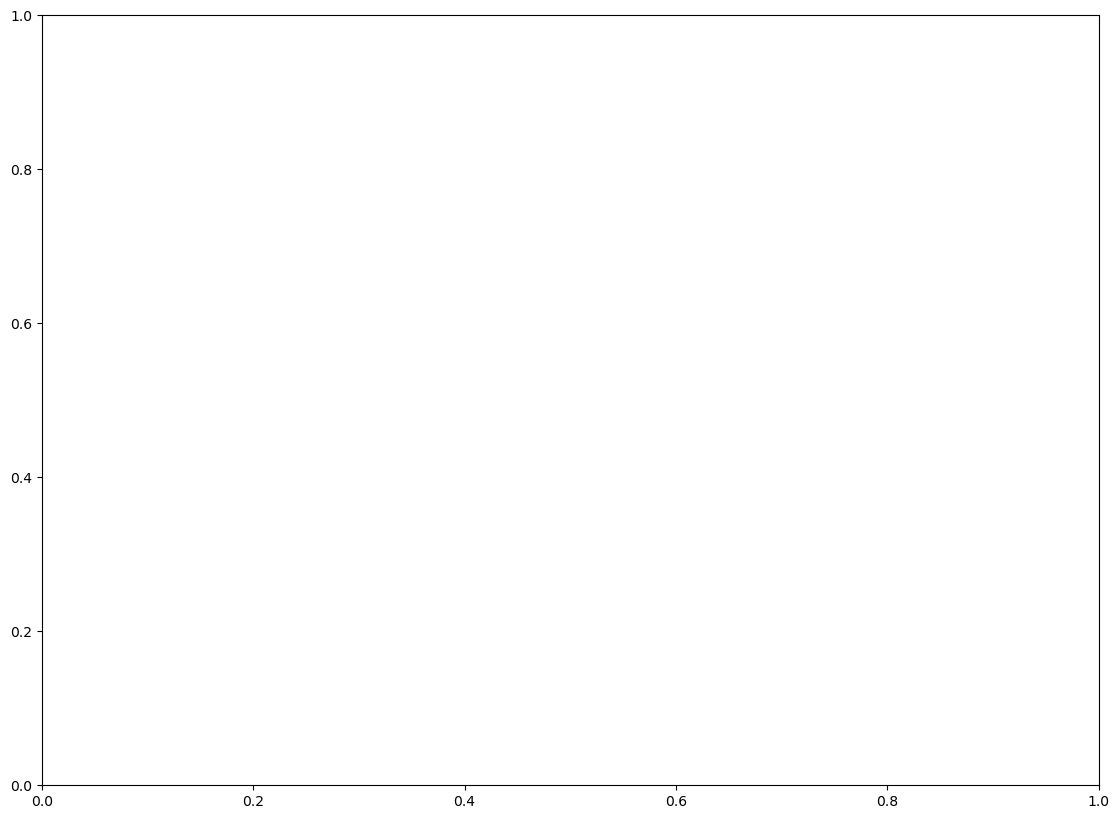

In [10]:
for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b

        plt.figure(figsize=(30, 10))
        
        plt.subplot(1,2,1)
        g =sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=usgs,
                  palette=['#2772ff',
                           '#653cc3', #roxo mixed 40%
                           '#ff9b42', #laranja bottles 20%
                           '#6f6', #verde claro bags 40%
                           '#afa', #verde claro bags 20%
                           '#0f0', #verde claro bags 60%
                           '#ff8920', #laranja bottles 40%
                           '#4a2c8f', #roxo mixed 60%
                           '#7956cb', #roxo mixed 20%
                           '#ff7', #amarelo hdpe 50%
                           '#ff0', #amarelo hdpe 100%
                           '#fd7700', #laranja bottles 60%
                           '#544221', #marrom madeira
                           '#990', #amarelo hdpe 50%
                           '#660', #amarelo hdpe 100%
                           '#2b2b2b'], 
                  legend='auto');

        plt.subplot(1,2,2)
        sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=usgs, 
                  palette=['#2772ff',
                           '#653cc3', #roxo mixed 40%
                           '#ff9b42', #laranja bottles 20%
                           '#6f6', #verde claro bags 40%
                           '#afa', #verde claro bags 20%
                           '#0f0', #verde claro bags 60%
                           '#ff8920', #laranja bottles 40%
                           '#4a2c8f', #roxo mixed 60%
                           '#7956cb', #roxo mixed 20%
                           '#ff7', #amarelo hdpe 50%
                           '#ff0', #amarelo hdpe 100%
                           '#fd7700', #laranja bottles 60%
                           '#544221', #marrom madeira
                           '#990', #amarelo hdpe 50%
                           '#660', #amarelo hdpe 100%
                           '#2b2b2b'], 
                  legend='auto').set(xscale="log");

        path = 'charts/english/exploratory_analysis/scatter/detailed_label/usgs/'
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        plt.savefig(path+feature_a+"/"+x+"_x_"+y+".png", format='png')

ValueError: The palette list has the wrong number of colors.

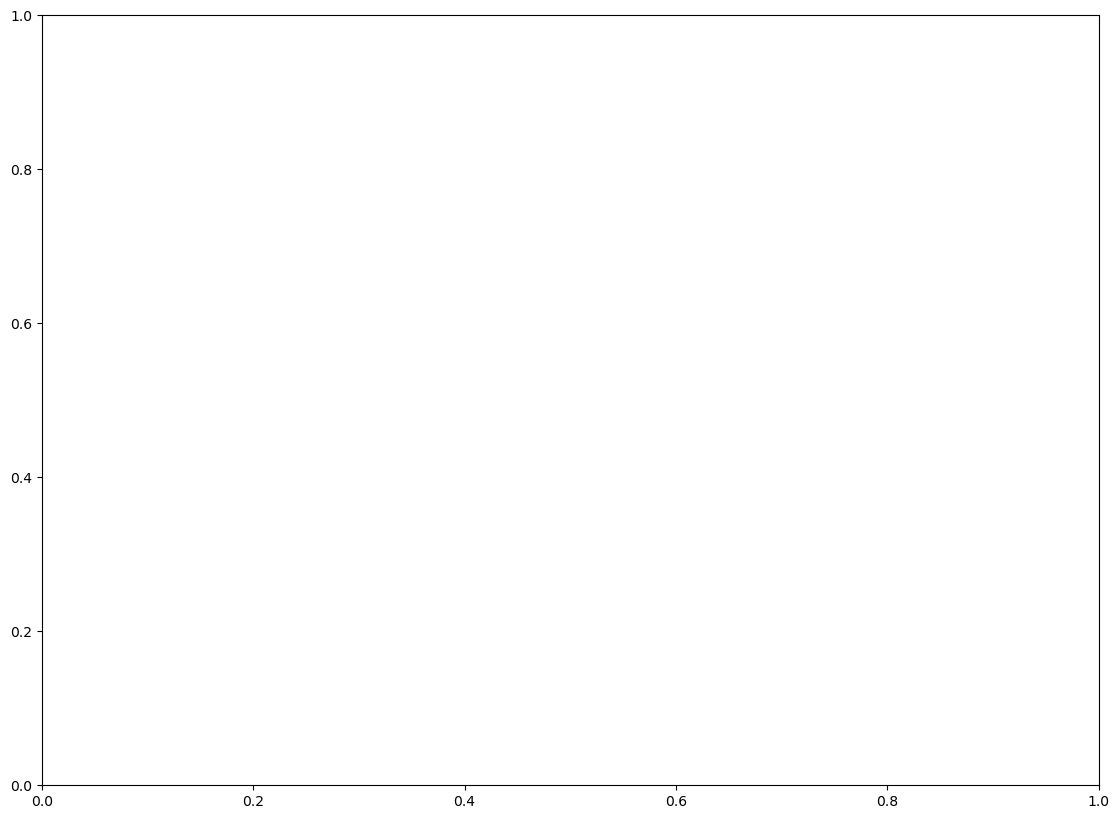

In [11]:
for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b

        plt.figure(figsize=(30, 10))
        
        plt.subplot(1,2,1)
        g =sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=usgs,
                  palette=['#2772ff',
                           '#653cc3', #roxo mixed 40%
                           '#ff9b42', #laranja bottles 20%
                           '#6f6', #verde claro bags 40%
                           '#afa', #verde claro bags 20%
                           '#0f0', #verde claro bags 60%
                           '#ff8920', #laranja bottles 40%
                           '#4a2c8f', #roxo mixed 60%
                           '#7956cb', #roxo mixed 20%
                           '#ff7', #amarelo hdpe 50%
                           '#ff0', #amarelo hdpe 100%
                           '#fd7700', #laranja bottles 60%
                           '#544221', #marrom madeira
                           '#990', #amarelo hdpe 50%
                           '#660', #amarelo hdpe 100%
                           '#2b2b2b'], 
                  legend='auto');

        plt.subplot(1,2,2)
        sns.scatterplot(x=x, y=y,
                  hue="Detailed_label",
                  data=usgs, 
                  palette=['#2772ff',
                           '#653cc3', #roxo mixed 40%
                           '#ff9b42', #laranja bottles 20%
                           '#6f6', #verde claro bags 40%
                           '#afa', #verde claro bags 20%
                           '#0f0', #verde claro bags 60%
                           '#ff8920', #laranja bottles 40%
                           '#4a2c8f', #roxo mixed 60%
                           '#7956cb', #roxo mixed 20%
                           '#ff7', #amarelo hdpe 50%
                           '#ff0', #amarelo hdpe 100%
                           '#fd7700', #laranja bottles 60%
                           '#544221', #marrom madeira
                           '#990', #amarelo hdpe 50%
                           '#660', #amarelo hdpe 100%
                           '#2b2b2b'], 
                  legend='auto').set(xscale="log");

        path = 'charts/portugues/analise_exploratoria/dispersao/rotulo_detalhado/usgs/'
        rsdata_charts.check_path(path+feature_a+"/")
        export_name = path+feature_a+"/"+x+"_x_"+y

        plt.savefig(path+feature_a+"/"+x+"_x_"+y+".png", format='png')

In [74]:
os.chdir('ufrgs-rescue')
os.chdir('plastic_map')
#os.chdir('../')
#os.chdir('../')

In [77]:
print(os.listdir())

['.git', '.gitignore', '.ipynb_checkpoints', 'charts', 'files', 'LICENSE', 'main.ipynb', 'modules']


In [ ]:
os.chdir('../')
        os.chdir('../')
        os.chdir('../')
        os.chdir('../')
        os.chdir('../')
        os.chdir('../')
        print(os.listdir())

In [86]:
import plotly.express as px

for feature_a in feature_names + radiometric_indexes:
    x = feature_a
    x_title = feature_a
    for feature_b in feature_names + radiometric_indexes:
        y = feature_b
        y_title = feature_b
        
        
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_polymer/dart_2021/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__polymer'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(old_dart, x=x, y=y, color="Cover_percent", facet_col="Polymer")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2021 (simulated)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_polymer/dart_2023/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__polymer'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dataset_dart, x=x, y=y, color="Cover_percent", facet_col="Polymer")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2023 (simulated)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_polymer/usgs/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__polymer'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(usgs, x=x, y=y, color="Cover_percent", facet_col="Polymer")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='USGS (observed)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_status/dart_2021/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__status'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(old_dart, x=x, y=y, color="Cover_percent", facet_col="Detailed_status")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2021 (simulated)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
        path = 'charts/english/exploratory_analysis/scatter/detailed_status/dart_2023/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__status'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dart, x=x, y=y, color="Cover_percent", facet_col="Detailed_status")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2023 (simulated)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
        path = 'charts/english/exploratory_analysis/scatter/detailed_status/usgs/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__status'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(usgs, x=x, y=y, color="Cover_percent", facet_col="Detailed_status")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='USGS (observed)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
        
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_color/dart_2021/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__color'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(old_dart, x=x, y=y, color="Cover_percent", facet_col="Color")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2021 (simulated)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        path = 'charts/english/exploratory_analysis/scatter/detailed_color/dart_2023/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__color'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dart, x=x, y=y, color="Cover_percent", facet_col="Color")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2023 (simulated)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())

        path = 'charts/english/exploratory_analysis/scatter/detailed_color/usgs/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__color'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dart, x=x, y=y, color="Cover_percent", facet_col="Color")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='USGS (observed)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
            
            
            
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_polimero/dart_2021/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__polimero'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(old_dart, x=x, y=y, color="Cover_percent", facet_col="Polímero")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2021 (simulado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_polimero/dart_2023/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__polimero'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dataset_dart, x=x, y=y, color="Cover_percent", facet_col="Polímero")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2023 (simulado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_polimero/usgs/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__polimero'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(usgs, x=x, y=y, color="Cover_percent", facet_col="Polímero")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='USGS (observadp)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        
        
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_status/dart_2021/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__status'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(old_dart, x=x, y=y, color="Cover_percent", facet_col="Detailed_status")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2021 (simulado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_status/dart_2023/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__status'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dart, x=x, y=y, color="Cover_percent", facet_col="Detailed_status")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2023 (simulado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_status/usgs/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__status'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(usgs, x=x, y=y, color="Cover_percent", facet_col="Detailed_status")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='USGS (observado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
            
        
        
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_cor/dart_2021/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__cor'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(old_dart, x=x, y=y, color="Cover_percent", facet_col="Color")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2021 (simulado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())
        
        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_cor/dart_2023/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__cor'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dart, x=x, y=y, color="Cover_percent", facet_col="Color")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='DART 2023 (simulado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())

        path = 'charts/portugues/analise_exploratoria/dispersao/detalhes_cor/usgs/'
        #rsdata_charts.check_path(path+'/'+feature_a+'/')
        export_name = path+feature_a+'/'+feature_a+'_x_'+feature_b+'__cor'
        
        with open(export_name+".html", 'a', encoding='utf-8') as f:
            fig = px.scatter(dart, x=x, y=y, color="Cover_percent", facet_col="Color")#, trendline="ols"

            fig.update_layout(height=600, width=800, title_text='USGS (obserado)', template = 'plotly_white')

            fig.write_image(export_name+".jpeg")
            f.write(fig.to_html())

In [ ]:
reload(rsdata_charts) AQUI 1

In [326]:
#21 e usgs
water = dataset_dart.query("Label == 'Water' and Blue == 0.0324 and NIR2 == 0.0207")[feature_names + radiometric_indexes] #Maioria disparada com essa refletancia na Blue (havia alteracoes pequenas nas bandas reamostradas, escolhi valor de NIR2 arbitrariamente)
water = water.drop_duplicates()
whitecap = dataset_dart.query("Label == 'Whitecap'")[feature_names + radiometric_indexes]
whitecap = whitecap.drop_duplicates()
pet_dry_100 = dataset_dart.query("Polymer == 'PET' and Cover_percent == 100")[feature_names + radiometric_indexes]
pet_dry_100 = pet_dry_100.drop_duplicates()
ldpe_dry_100 = dataset_dart.query("Polymer == 'LDPE' and Cover_percent == 100")[feature_names + radiometric_indexes]
ldpe_dry_100 = ldpe_dry_100.drop_duplicates()
pp_wet_orange_100 = dataset_dart.query("Polymer == 'PP' and Color == 'Orange' and Status == 'Wet' and Cover_percent == 100")[feature_names + radiometric_indexes]
pp_wet_orange_100 = pp_wet_orange_100.drop_duplicates()
pp_wet_white_100 = dataset_dart.query("Polymer == 'PP' and Color == 'White' and Status == 'Wet' and Cover_percent == 100")[feature_names + radiometric_indexes]
pp_wet_white_100 = pp_wet_white_100.drop_duplicates()
pp_sub2_orange_100 = dataset_dart.query("Polymer == 'PP' and Color == 'Orange' and Status == 'Submerged' and Submergence == '2 cm' and Cover_percent == 100")[feature_names + radiometric_indexes]
pp_sub2_orange_100 = pp_sub2_orange_100.drop_duplicates()
pp_sub2_white_100 = dataset_dart.query("Polymer == 'PP' and Color == 'White' and Status == 'Submerged' and Submergence == '2 cm' and Cover_percent == 100")[feature_names + radiometric_indexes]
pp_sub2_white_100 = pp_sub2_white_100.drop_duplicates()
pp_sub5_orange_100 = dataset_dart.query("Polymer == 'PP' and Color == 'Orange' and Status == 'Submerged' and Submergence == '5 cm' and Cover_percent == 100")[feature_names + radiometric_indexes]
pp_sub5_orange_100 = pp_sub5_orange_100.drop_duplicates()
pp_sub5_white_100 = dataset_dart.query("Polymer == 'PP' and Color == 'White' and Status == 'Submerged' and Submergence == '5 cm' and Cover_percent == 100")[feature_names + radiometric_indexes]
pp_sub5_white_100 = pp_sub5_white_100.drop_duplicates()

In [337]:
datasets_names = ["DART polymers", "DART polymers"]

traces = [
             [
                 [water[feature].values[0] for feature in feature_names],
                 [whitecap[feature].values[0] for feature in feature_names],
                 [pet_dry_100[feature].values[0] for feature in feature_names],
                 [ldpe_dry_100[feature].values[0] for feature in feature_names],
                 [pp_wet_orange_100[feature].values[0] for feature in feature_names],
                 [pp_wet_white_100[feature].values[0] for feature in feature_names],
                 [pp_sub2_orange_100[feature].values[0] for feature in feature_names],
                 [pp_sub2_white_100[feature].values[0] for feature in feature_names],
                 [pp_sub5_orange_100[feature].values[0] for feature in feature_names],
                 [pp_sub5_white_100[feature].values[0] for feature in feature_names]
             ],
             [
                 [water[ind].values[0] for ind in radiometric_indexes],
                 [whitecap[ind].values[0] for ind in radiometric_indexes],
                 [pet_dry_100[ind].values[0] for ind in radiometric_indexes],
                 [ldpe_dry_100[ind].values[0] for ind in radiometric_indexes],
                 [pp_wet_orange_100[ind].values[0] for ind in radiometric_indexes],
                 [pp_wet_white_100[ind].values[0] for ind in radiometric_indexes],
                 [pp_sub2_orange_100[ind].values[0] for ind in radiometric_indexes],
                 [pp_sub2_white_100[ind].values[0] for ind in radiometric_indexes],
                 [pp_sub5_orange_100[ind].values[0] for ind in radiometric_indexes],
                 [pp_sub5_white_100[ind].values[0] for ind in radiometric_indexes]
             ]
          ]

labels = [
            [feature_names, feature_names, feature_names, feature_names, feature_names, 
             feature_names, feature_names, feature_names, feature_names, feature_names],
            [radiometric_indexes, radiometric_indexes, radiometric_indexes, radiometric_indexes, radiometric_indexes, 
             radiometric_indexes, radiometric_indexes, radiometric_indexes, radiometric_indexes, radiometric_indexes]
            ]

legends = [['Water', 'Whitecap', 'Dry PET (100%)', 'Dry LDPE (100%)', 'Wet Orange PP (100%)',
           'Wet White PP (100%)', 'Sub 2cm Orange PP (100%)', 'Sub 2cm White PP (100%)', 
            'Sub 5cm Orange PP (100%)', 'Sub 5cm White PP (100%)'],
           ['Water', 'Whitecap', 'Dry PET (100%)', 'Dry LDPE (100%)', 'Wet Orange PP (100%)',
           'Wet White PP (100%)', 'Sub 2cm Orange PP (100%)', 'Sub 2cm White PP (100%)', 
            'Sub 5cm Orange PP (100%)', 'Sub 5cm White PP (100%)']]

modes = [
            ['markers+lines', 'markers+lines', 'markers+lines', 'markers+lines', 'markers+lines', 
             'markers+lines', 'markers+lines', 'markers+lines', 'markers+lines', 'markers+lines'],
            ['markers+lines', 'markers+lines', 'markers+lines', 'markers+lines', 'markers+lines', 
             'markers+lines', 'markers+lines', 'markers+lines', 'markers+lines', 'markers+lines']
        ]

colors = [
            ['#0049d1', '#00f9ed', '#ff3093', '#0f0', '#ff9b42', 
             '#6f7376', '#fd7700', '#46484a', '#b95700','#0c0d0d'],
            ['#0049d1', '#00f9ed', '#ff3093', '#0f0', '#ff9b42', 
             '#6f7376', '#fd7700', '#46484a', '#b95700','#0c0d0d']
         ]


chart_title = "Spectral signatures by polymer"
x_title = "Band"
y_title = "Reflectance"
height = 600
width = 1300
guidance = "horizontal"

export_name = 'charts/english/exploratory_analysis/artificial_band/polymers_signature'

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

## Unsupervised classification

DART 2021

In [64]:
old_dart['Simple_Path'] = old_dart['Path']
paths = list(set(old_dart['Simple_Path']))

In [65]:
feature_sets = [
                    feature_names + radiometric_indexes,
                    feature_names,
                    radiometric_indexes
                ]

n_clusters = [4]   

ids = ["both", "bands", "indexes"]

identificadores = ["ambos", "bandas", "indices"]

In [66]:
for i in range(len(feature_sets)):

    for n in n_clusters:
        path = 'charts/english/unsupervised_classification/kmeans/'+ids[i]+'/dart_2021/k'+str(n)+'/'
        rsdata_charts.check_path(path)

        caminho = 'charts/portugues/classificacao_nao_supervisionada/kmeans/'+identificadores[i]+'/dart_2021/k'+str(n)+'/'
        rsdata_charts.check_path(caminho)
        
        names_clusters = [] 
        classified_data = rsdata_classification.k_means(old_dart, feature_sets[i], n, 123)
        
        for k in range(n): 
            names_clusters.append("Cluster "+str(k))
        
        labels_group = names_clusters
        y = []
        
        for k in range(n):
            rsdata_charts.pie_chart(
                [classified_data.query('Cluster == '+str(k))], 
                ['Label'], 
                ["Cluster "+str(k)], 
                "", 450, 300, 
                ['#1E90FF', '#FF69B4', '#FFD700'], path+'cl'+str(k))
            

            
            rsdata_charts.pie_chart(
                [classified_data.query('Cluster == '+str(k))], 
                ['Classe'], 
                ["Cluster "+str(k)], 
                "", 450, 300, 
                ['#1E90FF', '#FF69B4', '#FFD700'], caminho+'/cl'+str(k))
                
            y.append(
                [
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 20 and Polymer == 'LDPE'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 40 and Polymer == 'LDPE'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 60 and Polymer == 'LDPE'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 80 and Polymer == 'LDPE'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 100 and Polymer == 'LDPE'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 20 and Polymer == 'PVC'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 40 and Polymer == 'PVC'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 60 and Polymer == 'PVC'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 80 and Polymer == 'PVC'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 100 and Polymer == 'PVC'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 20 and Polymer == 'PP'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 40 and Polymer == 'PP'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 60 and Polymer == 'PP'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 80 and Polymer == 'PP'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 100 and Polymer == 'PP'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 20 and Polymer == 'PET'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 40 and Polymer == 'PET'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 60 and Polymer == 'PET'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 80 and Polymer == 'PET'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 100 and Polymer == 'PET'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 20 and Polymer == 'MicroNapo'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 40 and Polymer == 'MicroNapo'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 60 and Polymer == 'MicroNapo'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 80 and Polymer == 'MicroNapo'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 100 and Polymer == 'MicroNapo'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 20 and Polymer == 'Nylon'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 40 and Polymer == 'Nylon'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 60 and Polymer == 'Nylon'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 80 and Polymer == 'Nylon'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == 100 and Polymer == 'Nylon'"))]
                ]
            )
            rsdata_charts.stacked_bar_chart(names_clusters, 
                                        #x,
                                        [
                                            ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%'],
                                            ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%'],
                                            ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%'],
                                            ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%'],
                                            ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%'],
                                            ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%']
                                        ],
                                        y, 
                                        ['LDPE', 'PVC', 'PP', 'PET', 'MicroNapo', 'Nylon'], #names, 
                                        ['#ADF224','#1AB1B1', '#2f1b70', '#D81F88', '#FF8825', '#F1C800'], #colors, 
                                        'Polymers by cluster', #chart_title, 
                                        'Cover percents', #x_title, 
                                        'Number of pixels', #y_title, 
                                        650, #height, 
                                        1000, #width, 
                                        labels_group, 
                                        'h', #orientation, 
                                        'horizontal', #guidance, 
                                        path+"/polymers" #export_name
                                       )


            rsdata_charts.stacked_bar_chart(names_clusters, 
                                        #x,
                                        [
                                            ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%'],
                                            ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%'],
                                            ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%'],
                                            ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%'],
                                            ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%'],
                                            ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%']
                                        ],
                                        y, 
                                        ['LDPE', 'PVC', 'PP', 'PET', 'MicroNapo', 'Nylon'], #names, 
                                        ['#ADF224','#1AB1B1', '#2f1b70', '#D81F88', '#FF8825', '#F1C800'], #colors, 
                                        'Polímeros por cluster', #chart_title, 
                                        'Percentuais de cobertura', #x_title, 
                                        'Número de pixels', #y_title, 
                                        650, #height, 
                                        1000, #width, 
                                        labels_group, 
                                        'h', #orientation, 
                                        'horizontal', #guidance, 
                                        caminho+"/polimeros"#export_name
                                       )
            
        for p in paths: 
            rsdata_classification.map_kmeans(p, old_dart, classified_data, path, caminho, 3000, 5000)

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



DART 2023

In [67]:
dart['Simple_Path'] = [ "/".join(path.split('/')[3:]) for path in dart['Path']]
paths = list(set(dart['Simple_Path']))

In [68]:
feature_sets = [
                    feature_names + radiometric_indexes,
                    feature_names,
                    radiometric_indexes
                ]

n_clusters = [4]   

ids = ["both", "bands", "indexes"]

identificadores = ["ambos", "bandas", "indices"]

In [69]:
for i in range(len(feature_sets)):
    for n in n_clusters:
        path = 'charts/english/unsupervised_classification/kmeans/'+ids[i]+'/dart_2023/k'+str(n)+'/'
        rsdata_charts.check_path(path)

        caminho = 'charts/portugues/classificacao_nao_supervisionada/kmeans/'+identificadores[i]+'/dart_2023/k'+str(n)+'/'
        rsdata_charts.check_path(caminho)
        
        names_clusters = [] 
        classified_data = rsdata_classification.k_means(dataset_dart, feature_sets[i], n, 123)
        
        for k in range(n): 
            names_clusters.append("Cluster "+str(k))
        
        labels_group = names_clusters
        y = []
        
        for k in range(n):
            rsdata_charts.pie_chart(
                [classified_data.query('Cluster == '+str(k))], 
                ['Label'], 
                ["Cluster "+str(k)], 
                "", 450, 300, 
                ['#1E90FF', '#FF69B4', '#FFD700'], path+'cl'+str(k))
            

            
            rsdata_charts.pie_chart(
                [classified_data.query('Cluster == '+str(k))], 
                ['Classe'], 
                ["Cluster "+str(k)], 
                "", 450, 300, 
                ['#1E90FF', '#FF69B4', '#FFD700'], caminho+'/cl'+str(k))
               
            y.append([
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'LDPE' and Cover_percent == 20")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'LDPE' and Cover_percent == 40")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'LDPE' and Cover_percent == 60")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'LDPE' and Cover_percent == 80")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'LDPE' and Cover_percent == 100"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PET' and Cover_percent == 20")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PET' and Cover_percent == 40")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PET' and Cover_percent == 60")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PET' and Cover_percent == 80")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PET' and Cover_percent == 100"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Wet' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Wet' and Color == 'White'"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Submerged 2cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Submerged 2cm' and Color == 'White'"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Submerged 5cm' and Color == 'White'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Submerged 5cm' and Color == 'White'"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Wet' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Wet' and Color == 'Orange'"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Submerged 2cm' and Color == 'Orange'"))],
                [len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'")), 
                 len(classified_data.query('Cluster == '+str(k)).query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Submerged 5cm' and Color == 'Orange'"))]#,
                #[len(dataset['plastic_pp'].query("Polymer == 'PP' and Cover_percent == 20 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                # len(dataset['plastic_pp'].query("Polymer == 'PP' and Cover_percent == 40 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                # len(dataset['plastic_pp'].query("Polymer == 'PP' and Cover_percent == 60 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                # len(dataset['plastic_pp'].query("Polymer == 'PP' and Cover_percent == 80 and Detailed_status == 'Dry' and Color == 'Transparent'")), 
                # len(dataset['plastic_pp'].query("Polymer == 'PP' and Cover_percent == 100 and Detailed_status == 'Dry' and Color == 'Transparent'"))],
                #[len(dataset['plastic_nylon'].query("Polymer == 'Nylon' and Cover_percent == 20")), 
                # len(dataset['plastic_nylon'].query("Polymer == 'Nylon' and Cover_percent == 40")), 
                # len(dataset['plastic_nylon'].query("Polymer == 'Nylon' and Cover_percent == 60")), 
                # len(dataset['plastic_nylon'].query("Polymer == 'Nylon' and Cover_percent == 80")), 
                # len(dataset['plastic_nylon'].query("Polymer == 'Nylon' and Cover_percent == 100"))],
                #[len(dataset['plastic_pvc'].query("Polymer == 'PVC' and Cover_percent == 20")), 
                # len(dataset['plastic_pvc'].query("Polymer == 'PVC' and Cover_percent == 40")), 
                # len(dataset['plastic_pvc'].query("Polymer == 'PVC' and Cover_percent == 60")), 
                # len(dataset['plastic_pvc'].query("Polymer == 'PVC' and Cover_percent == 80")), 
                # len(dataset['plastic_pvc'].query("Polymer == 'PVC' and Cover_percent == 100"))],
                #[len(dataset['plastic_micronapo'].query("Polymer == 'MicroNapo' and Cover_percent == 20")), 
                # len(dataset['plastic_micronapo'].query("Polymer == 'MicroNapo' and Cover_percent == 40")), 
                # len(dataset['plastic_micronapo'].query("Polymer == 'MicroNapo' and Cover_percent == 60")), 
                # len(dataset['plastic_micronapo'].query("Polymer == 'MicroNapo' and Cover_percent == 80")), 
                # len(dataset['plastic_micronapo'].query("Polymer == 'MicroNapo' and Cover_percent == 100"))]
            ])
    
            labels = ['Dry LDPE (transparent)', 
                      'Dry PET (transparent)', 
                      'Wet PP (white)', 
                      'Sub 2cm PP (white)', 
                      'Sub 5cm PP (white)',
                      'Wet PP (orange)', 
                      'Sub 2cm PP (orange)', 
                      'Sub 5cm PP (orange)'#,
                      #'Dry PP (transparent)',
                      #'Dry Nylon (transparent)',
                      #'Dry PVC (transparent)',
                      #'Wet Micronapo (mixed colors)'
                     ]

            legend_x = ['Plastic 20%', 'Plastic 40%', 'Plastic 60%', 'Plastic 80%', 'Plastic 100%']
            legends_x = []
            for i in range(len(y[0])):
                legends_x.append(legend_x)
                      
            colors = ['#ADF224', '#ff74b6', '#666ce0', '#3c43d7', '#2329ac', '#FFAD69',
                      '#FF9A47', '#FF7F14'#,
                      #'#1AB1B1',
                      #'#D81F88',
                      #'#FFDD36',
                      #'#DC0000'
                      ] #colors,
            
                        
            rsdata_charts.stacked_bar_chart(names_clusters, 
                                        #x,
                                        legends_x,
                                        y, 
                                        labels,
                                        colors,
                                        'Polymers by cluster', #chart_title, 
                                        'Cover percents', #x_title, 
                                        'Number of pixels', #y_title, 
                                        650, #height, 
                                        1000, #width, 
                                        labels_group, 
                                        'h', #orientation, 
                                        'horizontal', #guidance, 
                                        path+"/polymers" )

            labels = ['LDPE seco (transparente)', 
                      'PET seco (transparente)', 
                      'PP úmido (branco)', 
                      'PP sub 2cm (branco)', 
                      'PP sub 5cm (branco)',
                      'PP úmido (laranja)', 
                      'PP sub 2cm (laranja)', 
                      'PP sub 5cm (laranja)',
                      'PP seco (transparente)',
                      'Nylon seco (transparente)',
                      'PVC seco (transparente)',
                      'Micronapo úmido (cores mistas)']

            legend_x = ['Plástico 20%', 'Plástico 40%', 'Plástico 60%', 'Plástico 80%', 'Plástico 100%']
            legends_x = []
            for i in range(len(y[0])):
                legends_x.append(legend_x)

            rsdata_charts.stacked_bar_chart(names_clusters, 
                                    #x,
                                    legends_x,
                                    y, 
                                    labels,
                                    colors, 
                                    'DART - polímeros em detalhes', #chart_title, 
                                    'Percentuais de cobertura', #x_title, 
                                    'Número de pixels', #y_title, 
                                    700, #height, 
                                    1000, #width, 
                                    labels_group, 
                                    'h', #orientation, 
                                    'horizontal', #guidance, 
                                    caminho+"/polymers")
            
        for p in paths: 
            #print(p)
            #print(dart.query("Simple_path == '"+date+"'"))
            rsdata_classification.map_kmeans(p, dart, classified_data, path, caminho, 3000, 5000)

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [70]:
usgs['Simple_Path'] = usgs['Path']
dates = list(set(usgs['Simple_Path']))

In [71]:
feature_sets = [
                    feature_names + radiometric_indexes,
                    feature_names,
                    radiometric_indexes
                ]

n_clusters = [4]   

ids = ["both", "bands", "indexes"]

identificadores = ["ambos", "bandas", "indices"]

In [72]:

#dates = ['2019_04_18', '2019_05_03', '2019_05_18', '2019_05_28', '2019_06_07', '2021_06_21', '2021_07_01', '2021_07_06', '2021_07_21', '2021_08_25']


for i in range(len(feature_sets)):
    for n in n_clusters:
        path = 'charts/english/unsupervised_classification/kmeans/'+ids[i]+'/usgs/k'+str(n)+'/'
        rsdata_charts.check_path(path)

        caminho = 'charts/portugues/classificacao_nao_supervisionada/kmeans/'+identificadores[i]+'/usgs/k'+str(n)+'/'
        rsdata_charts.check_path(caminho)
        
        names_clusters = [] 
        classified_data = rsdata_classification.k_means(usgs, feature_sets[i], n, 123)
        
        for k in range(n): 
            names_clusters.append("Cluster "+str(k))
        
        labels_group = names_clusters
        x = []
        y = []
        z = []
        
        
        for k in range(n):
            rsdata_charts.pie_chart(
                [classified_data.query('Cluster == '+str(k))], 
                ['Label'], 
                ["Cluster "+str(k)], 
                "", 450, 300, 
                ['#1E90FF', '#FF69B4', '#FFD700'], path+'cl'+str(k))
            
            
            rsdata_charts.pie_chart(
                [classified_data.query('Cluster == '+str(k))], 
                ['Classe'], 
                ["Cluster "+str(k)], 
                "", 450, 300, 
                ['#1E90FF', '#FF69B4', '#FFD700'], caminho+'/cl'+str(k))
            
            
            x.append(
                [                
                    [len(classified_data.query('Cluster == '+str(k)).query("Path == '2019_04_18'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2019_05_03'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2019_05_18'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2019_05_28'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2019_06_07'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2021_06_21'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2021_07_01'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2021_07_06'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2021_07_21'")), len(classified_data.query('Cluster == '+str(k)).query("Path == '2021_08_25'"))]
                ]
                )
            
            y.append(
                [                
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent <= 20 and Polymer == 'Bags'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 20 and Cover_percent <= 40 and Polymer == 'Bags'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 40 and Cover_percent <= 60 and Polymer == 'Bags'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 60 and Cover_percent <= 80 and Polymer == 'Bags'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 80 and Cover_percent <= 99 and Polymer == 'Bags'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -100 and Polymer == 'Bags'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -1 and Polymer == 'Bags'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent <= 20 and Polymer == 'Bags and Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 20 and Cover_percent <= 40 and Polymer == 'Bags and Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 40 and Cover_percent <= 60 and Polymer == 'Bags and Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 60 and Cover_percent <= 80 and Polymer == 'Bags and Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 80 and Cover_percent <= 99 and Polymer == 'Bags and Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -100 and Polymer == 'Bags and Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -1 and Polymer == 'Bags and Bottles'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent <= 20 and Polymer == 'Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 20 and Cover_percent <= 40 and Polymer == 'Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 40 and Cover_percent <= 60 and Polymer == 'Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 60 and Cover_percent <= 80 and Polymer == 'Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 80 and Cover_percent <= 99 and Polymer == 'Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -100 and Polymer == 'Bottles'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -1 and Polymer == 'Bottles'"))],
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent <= 20 and Polymer == 'HDPE mesh'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 20 and Cover_percent <= 40 and Polymer == 'HDPE mesh'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 40 and Cover_percent <= 60 and Polymer == 'HDPE mesh'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 60 and Cover_percent <= 80 and Polymer == 'HDPE mesh'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 80 and Cover_percent <= 99 and Polymer == 'HDPE mesh'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -100 and Polymer == 'HDPE mesh'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -1 and Polymer == 'HDPE mesh'"))]
                ]
                )
            
            z.append(
                [                
                    [len(classified_data.query('Cluster == '+str(k)).query("Cover_percent <= 20 and Polymer == 'Wood'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 20 and Cover_percent <= 40 and Polymer == 'Wood'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 40 and Cover_percent <= 60 and Polymer == 'Wood'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 60 and Cover_percent <= 80 and Polymer == 'Wood'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent > 80 and Cover_percent <= 99 and Polymer == 'Wood'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -100 and Label == 'Wood'")), len(classified_data.query('Cluster == '+str(k)).query("Cover_percent == -1 and Label == 'Wood'"))]
                    
                ]
                )
            
            rsdata_charts.stacked_bar_chart(names_clusters, 
                                        #x,
                                        [
                                            ['Plastic 1% - 20%', 'Plastic 20% - 40%', 'Plastic 40% - 60%', 'Plastic 60% - 80%', 'Plastic 80% - 99%', 'Plastic 100%', 'Unknown percent'],
                                            ['Plastic 1% - 20%', 'Plastic 20% - 40%', 'Plastic 40% - 60%', 'Plastic 60% - 80%', 'Plastic 80% - 99%', 'Plastic 100%', 'Unknown percent'],
                                            ['Plastic 1% - 20%', 'Plastic 20% - 40%', 'Plastic 40% - 60%', 'Plastic 60% - 80%', 'Plastic 80% - 99%', 'Plastic 100%', 'Unknown percent'],
                                            ['Plastic 1% - 20%', 'Plastic 20% - 40%', 'Plastic 40% - 60%', 'Plastic 60% - 80%', 'Plastic 80% - 99%', 'Plastic 100%', 'Unknown percent']
                                        ],
                                        y, 
                                        ['Bags', 'Bags and Bottles', 'Bottles', 'HDPE mesh'], #names, 
                                        ['#49C658','#8945AB', '#FF675F', '#FCFE5E'], #colors, 
                                        'Polymers by cluster', #chart_title, 
                                        'Cover percents', #x_title, 
                                        'Number of pixels', #y_title, 
                                        650, #height, 
                                        1300, #width, 
                                        labels_group, 
                                        'h', #orientation, 
                                        'horizontal', #guidance, 
                                        path+"/polymers"#export_name
                                           )


            rsdata_charts.stacked_bar_chart(names_clusters, 
                                        #x,
                                        [
                                            ['Plástico 1% a 20%', 'Plástico 20% a 40%', 'Plástico 40% a 60%', 'Plástico 60% a 80%', 'Plástico 80% a 99%', 'Plástico 100%', 'Percentual desconhecido'],
                                            ['Plástico 1% a 20%', 'Plástico 20% a 40%', 'Plástico 40% a 60%', 'Plástico 60% a 80%', 'Plástico 80% a 99%', 'Plástico 100%', 'Percentual desconhecido'],
                                            ['Plástico 1% a 20%', 'Plástico 20% a 40%', 'Plástico 40% a 60%', 'Plástico 60% a 80%', 'Plástico 80% a 99%', 'Plástico 100%', 'Percentual desconhecido'],
                                            ['Plástico 1% a 20%', 'Plástico 20% a 40%', 'Plástico 40% a 60%', 'Plástico 60% a 80%', 'Plástico 80% a 99%', 'Plástico 100%', 'Percentual desconhecido']
                                        ],
                                        y, 
                                        ['Sacolas', 'Sacolas e garrafas', 'Garrafas', 'Malha de HDPE'], #names, 
                                        ['#49C658','#8945AB', '#FF675F', '#FCFE5E'], #colors, 
                                        'Polímeros por cluster', #chart_title, 
                                        'Percentuais de cobertura', #x_title, 
                                        'Número de pixels', #y_title, 
                                        650, #height, 
                                        1300, #width, 
                                        labels_group, 
                                        'h', #orientation, 
                                        'horizontal', #guidance, 
                                        caminho+"/polimeros"#export_name
                                           )
        
            rsdata_charts.stacked_bar_chart(names_clusters, 
                                            #x,
                                            [
                                                ['Wood 1% - 20%', 'Wood 20% - 40%', 'Wood 40% - 60%', 'Wood 60% - 80%', 'Wood 80% - 99%', 'Wood 100%', 'Unknown percent']
                                            ],
                                            z, 
                                            ['Wood'], #names, 
                                            ['#82431d'], #colors, 
                                            'Wood by cluster', #chart_title, 
                                            'Cover percents', #x_title, 
                                            'Number of pixels', #y_title, 
                                            650, #height, 
                                            1300, #width, 
                                            labels_group, 
                                            'h', #orientation, 
                                            'horizontal', #guidance, 
                                            path+"/wood"#export_name
                                               )


            rsdata_charts.stacked_bar_chart(names_clusters, 
                                            #x,
                                            [
                                                ['Madeira 1% a 20%', 'Madeira 20% a 40%', 'Madeira 40% a 60%', 'Madeira 60% a 80%', 'Madeira 80% a 99%', 'Madeira 100%', 'Percentual desconhecido']
                                            ],
                                            z, 
                                            ['Madeira'], #names, 
                                            ['#82431d'], #colors, 
                                            'Madeira por cluster', #chart_title, 
                                            'Percentuais de cobertura', #x_title, 
                                            'Número de pixels', #y_title, 
                                            650, #height, 
                                            1300, #width, 
                                            labels_group, 
                                            'h', #orientation, 
                                            'horizontal', #guidance, 
                                            caminho+"/madeira"#export_name
                                               )

            rsdata_charts.stacked_bar_chart(names_clusters, 
                                            #x,
                                            [
                                                ['18/04/2019', '03/05/2019', '18/05/2019', '28/05/2019', '07/06/2019', '21/06/2021', '01/07/2021', '06/07/2021', '21/07/2021', '25/08/2021']
                                            ],
                                            x, 
                                            ['Dates'], #names, 
                                            ['#49C658','#8945AB', '#FF675F', '#FCFE5E'], #colors, 
                                            'Dates by cluster', #chart_title, 
                                            'Dates', #x_title, 
                                            'Number of pixels', #y_title, 
                                            650, #height, 
                                            1300, #width, 
                                            labels_group, 
                                            'h', #orientation, 
                                            'horizontal', #guidance, 
                                            path+"/dates"#export_name
                                               )


            rsdata_charts.stacked_bar_chart(names_clusters, 
                                            #x,
                                            [
                                                ['18/04/2019', '03/05/2019', '18/05/2019', '28/05/2019', '07/06/2019', '21/06/2021', '01/07/2021', '06/07/2021', '21/07/2021', '25/08/2021']
                                            ],
                                            x, 
                                            ['Datas'], #names, 
                                            ['#49C658','#8945AB', '#FF675F', '#FCFE5E'], #colors,  
                                            'Datas por cluster', #chart_title, 
                                            'Datas', #x_title, 
                                            'Número de pixels', #y_title, 
                                            650, #height, 
                                            1300, #width, 
                                            labels_group, 
                                            'h', #orientation, 
                                            'horizontal', #guidance, 
                                            caminho+"/datas"#export_name
                                               )
        
        for d in dates: 
            rsdata_classification.map_kmeans(d, dataset_usgs, classified_data, path, caminho, 500, 700)

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\00201245\.conda\envs\geo_backup\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Teste com Random Forest

In [92]:
#AQUI 3
from importlib import reload
reload(rsdata_classification)
reload(rsdata_charts)

<module 'modules.rsdata_charts' from 'C:\\Users\\00201245\\source\\python\\ufrgs-rescue\\plastic_map\\modules\\rsdata_charts.py'>

Dart (21) x USGS

In [116]:
feature_sets = [
                    feature_names + radiometric_indexes,
                    feature_names,
                    radiometric_indexes
                ]

ids = ["both", "bands", "indexes"]

identificadores = ["ambos", "bandas", "indices"]

dates = list(set(usgs['Simple_Path']))

In [117]:
#for dataset in datasets old_dart, dart, usgs
for feature_set in feature_sets:
    X = old_dart.query("Label == 'Water' or Label == 'Plastic'")[feature_set]
    y = old_dart.query("Label == 'Water' or Label == 'Plastic'")['Label']
    X_real = usgs.query("Label == 'Water' or Label == 'Plastic'")[feature_set]
    y_real = usgs.query("Label == 'Water' or Label == 'Plastic'")['Label']
    
    y_pred, assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted, feature_importances = rsdata_classification.random_forest(X, y, X_real, y_real, feature_set, 100)
    
    path = 'charts/english/supervised_classification/random_forest/dart_2021/'+ids[feature_sets.index(feature_set)]+'/'
    rsdata_charts.check_path(path)
    
    caminho = 'charts/portugues/classificacao_supervisionada/ramdom_forest/dart_2021/'+identificadores[feature_sets.index(feature_set)]+'/'
    rsdata_charts.check_path(caminho)
    
    #METRICS TO CSV
    acc_ = []
    b_acc_ = []
    f1_macro_ = []
    f1_weighted_ = []
    fbeta_macro_ = []
    fbeta_weighted_ = []
    pr_macro_ = []
    rc_macro_ = []
    pr_weighted_ = []
    rc_weighted_ = []
    
    best_acc_value = 0
    best_acc_index = 0
    best_bac_value = 0
    best_bac_index = 0

    for key in acc.keys():
        acc_.append(acc[key])
        b_acc_.append(b_acc[key])
        f1_macro_.append(f1_macro[key])
        f1_weighted_.append(f1_weighted[key])
        fbeta_macro_.append(fbeta_macro[key])
        fbeta_weighted_.append(fbeta_weighted[key])
        pr_macro_.append(pr_macro[key])
        rc_macro_.append(rc_macro[key])
        pr_weighted_.append(pr_weighted[key])
        rc_weighted_.append(rc_weighted[key])
        
        if acc[key] > best_acc_value:
            best_acc_value = acc[key]
            best_acc_index = key
        if b_acc[key] > best_bac_value:
            best_bac_value = b_acc[key]
            best_bac_index = key
    
    acc_ = pd.DataFrame(acc_, columns = ['Acc'])
    b_acc_ = pd.DataFrame(b_acc_, columns = ['B_acc'])
    f1_macro_ = pd.DataFrame(f1_macro_, columns = ['F1M'])
    f1_weighted_ = pd.DataFrame(f1_weighted_, columns = ['F1W'])
    fbeta_macro_ = pd.DataFrame(fbeta_macro_, columns = ['FBM'])
    fbeta_weighted_ = pd.DataFrame(fbeta_weighted_, columns = ['FBW'])
    pr_macro_ = pd.DataFrame(pr_macro_, columns = ['PrM'])
    rc_macro_ = pd.DataFrame(rc_macro_, columns = ['RcM'])
    pr_weighted_ = pd.DataFrame(pr_weighted_, columns = ['PrW'])
    rc_weighted_ = pd.DataFrame(rc_weighted_, columns = ['RcW'])

    mt = pd.DataFrame([acc_['Acc'].mean(), b_acc_['B_acc'].mean(), f1_macro_['F1M'].mean(), f1_weighted_['F1W'].mean(), fbeta_macro_['FBM'].mean(), fbeta_weighted_['FBW'].mean(), pr_macro_['PrM'].mean(), pr_weighted_['PrW'].mean(), rc_macro_['RcM'].mean(), rc_weighted_['RcW'].mean()], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=[ids[feature_sets.index(feature_set)]])
    mt.to_excel(path+'evaluation_metrics.xlsx')
    
    stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(assessment, usgs.query("Label == 'Water' or Label == 'Plastic'"))
    stats_by_polymer.to_excel(path+'evaluation_metrics_by_polymers.xlsx')
    stats_by_label_year.to_excel(path+'evaluation_metrics_by_year.xlsx')
    stats_by_plastic_cover_percent.to_excel(path+'evaluation_metrics_by_cover_percent.xlsx')
    stats_by_date.to_excel(path+'evaluation_metrics_by_date.xlsx')
    
    datasets_names = ["Best Overall Accuraccy - Index " + str(best_acc_index), "Best Balanced Accuraccy - Index " + str(best_bac_index)]
    traces = [feature_importances[best_acc_index], feature_importances[best_bac_index]]
    labels = [feature_importances[best_acc_index].index, feature_importances[best_bac_index].index]
    color = 'rgba(50, 171, 96, 0.6)'
    line_color = 'rgba(50, 171, 96, 1.0)'
    chart_title = 'Feature importances for USGS data'
    x_title = "Importance"
    y_title = "Feature"
    height = 600
    width = 1200
    orientation='h'
    guidance="horizontal"
    export_name = path+'feature_importances'
    rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)
    #Portugues
    
    #MAPS
    rsdata_charts.check_path(path+'maps/o_acc/')
    rsdata_charts.check_path(path+'maps/b_acc/')
    rsdata_charts.check_path(caminho+'mapas/acc_geral')
    rsdata_charts.check_path(caminho+'mapas/acc_balanceada')
    
    classified_data = usgs.query("Label == 'Water' or Label == 'Plastic'").copy()
    classified_data['Predicted_class'] = y_pred[best_acc_index]
    for d in dates:
        rsdata_charts.map_nn(d, usgs.query("Label == 'Water' or Label == 'Plastic'"), classified_data, path+'maps/o_acc/', caminho+'mapas/acc_geral', 500, 1000)
        
    classified_data = usgs.query("Label == 'Water' or Label == 'Plastic'").copy()
    classified_data['Predicted_class'] = y_pred[best_bac_index]
    for d in dates:
        rsdata_charts.map_nn(d, usgs.query("Label == 'Water' or Label == 'Plastic'"), classified_data, path+'maps/b_acc/', caminho+'mapas/acc_balanceada', 500, 1000)

DART (23) x USGS

In [118]:
feature_sets = [
                    feature_names + radiometric_indexes,
                    feature_names,
                    radiometric_indexes
                ]

ids = ["both", "bands", "indexes"]

identificadores = ["ambos", "bandas", "indices"]

dates = list(set(usgs['Simple_Path']))

In [119]:
for feature_set in feature_sets:
    X = dart.query("Label == 'Water' or Label == 'Plastic'")[feature_set]
    y = dart.query("Label == 'Water' or Label == 'Plastic'")['Label']
    X_real = usgs.query("Label == 'Water' or Label == 'Plastic'")[feature_set]
    y_real = usgs.query("Label == 'Water' or Label == 'Plastic'")['Label']
    
    y_pred, assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted, feature_importances = rsdata_classification.random_forest(X, y, X_real, y_real, feature_set, 100)
    
    path = 'charts/english/supervised_classification/random_forest/dart_2023/'+ids[feature_sets.index(feature_set)]+'/'
    rsdata_charts.check_path(path)
    
    caminho = 'charts/portugues/classificacao_supervisionada/ramdom_forest/dart_2023/'+identificadores[feature_sets.index(feature_set)]+'/'
    rsdata_charts.check_path(caminho)
    
    #METRICS TO CSV
    acc_ = []
    b_acc_ = []
    f1_macro_ = []
    f1_weighted_ = []
    fbeta_macro_ = []
    fbeta_weighted_ = []
    pr_macro_ = []
    rc_macro_ = []
    pr_weighted_ = []
    rc_weighted_ = []
    
    best_acc_value = 0
    best_acc_index = 0
    best_bac_value = 0
    best_bac_index = 0

    for key in acc.keys():
        acc_.append(acc[key])
        b_acc_.append(b_acc[key])
        f1_macro_.append(f1_macro[key])
        f1_weighted_.append(f1_weighted[key])
        fbeta_macro_.append(fbeta_macro[key])
        fbeta_weighted_.append(fbeta_weighted[key])
        pr_macro_.append(pr_macro[key])
        rc_macro_.append(rc_macro[key])
        pr_weighted_.append(pr_weighted[key])
        rc_weighted_.append(rc_weighted[key])
        
        if acc[key] > best_acc_value:
            best_acc_value = acc[key]
            best_acc_index = key
        if b_acc[key] > best_bac_value:
            best_bac_value = b_acc[key]
            best_bac_index = key
    
    acc_ = pd.DataFrame(acc_, columns = ['Acc'])
    b_acc_ = pd.DataFrame(b_acc_, columns = ['B_acc'])
    f1_macro_ = pd.DataFrame(f1_macro_, columns = ['F1M'])
    f1_weighted_ = pd.DataFrame(f1_weighted_, columns = ['F1W'])
    fbeta_macro_ = pd.DataFrame(fbeta_macro_, columns = ['FBM'])
    fbeta_weighted_ = pd.DataFrame(fbeta_weighted_, columns = ['FBW'])
    pr_macro_ = pd.DataFrame(pr_macro_, columns = ['PrM'])
    rc_macro_ = pd.DataFrame(rc_macro_, columns = ['RcM'])
    pr_weighted_ = pd.DataFrame(pr_weighted_, columns = ['PrW'])
    rc_weighted_ = pd.DataFrame(rc_weighted_, columns = ['RcW'])

    mt = pd.DataFrame([acc_['Acc'].mean(), b_acc_['B_acc'].mean(), f1_macro_['F1M'].mean(), f1_weighted_['F1W'].mean(), fbeta_macro_['FBM'].mean(), fbeta_weighted_['FBW'].mean(), pr_macro_['PrM'].mean(), pr_weighted_['PrW'].mean(), rc_macro_['RcM'].mean(), rc_weighted_['RcW'].mean()], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=[ids[feature_sets.index(feature_set)]])
    mt.to_excel(path+'evaluation_metrics.xlsx')
    
    stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(assessment, usgs.query("Label == 'Water' or Label == 'Plastic'"))
    stats_by_polymer.to_excel(path+'evaluation_metrics_by_polymers.xlsx')
    stats_by_label_year.to_excel(path+'evaluation_metrics_by_year.xlsx')
    stats_by_plastic_cover_percent.to_excel(path+'evaluation_metrics_by_cover_percent.xlsx')
    stats_by_date.to_excel(path+'evaluation_metrics_by_date.xlsx')
    
    datasets_names = ["Best Overall Accuraccy - Index " + str(best_acc_index), "Best Balanced Accuraccy - Index " + str(best_bac_index)]
    traces = [feature_importances[best_acc_index], feature_importances[best_bac_index]]
    labels = [feature_importances[best_acc_index].index, feature_importances[best_bac_index].index]
    color = 'rgba(50, 171, 96, 0.6)'
    line_color = 'rgba(50, 171, 96, 1.0)'
    chart_title = 'Feature importances for USGS data'
    x_title = "Importance"
    y_title = "Feature"
    height = 600
    width = 1200
    orientation='h'
    guidance="horizontal"
    export_name = path+'feature_importances'
    rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)
    #Portugues
    
    #MAPS
    rsdata_charts.check_path(path+'maps/o_acc/')
    rsdata_charts.check_path(path+'maps/b_acc/')
    rsdata_charts.check_path(caminho+'mapas/acc_geral')
    rsdata_charts.check_path(caminho+'mapas/acc_balanceada')
    
    classified_data = usgs.query("Label == 'Water' or Label == 'Plastic'").copy()
    classified_data['Predicted_class'] = y_pred[best_acc_index]
    for d in dates:
        rsdata_charts.map_nn(d, usgs.query("Label == 'Water' or Label == 'Plastic'"), classified_data, path+'maps/o_acc/', caminho+'mapas/acc_geral', 500, 1000)
        
    classified_data = usgs.query("Label == 'Water' or Label == 'Plastic'").copy()
    classified_data['Predicted_class'] = y_pred[best_bac_index]
    for d in dates:
        rsdata_charts.map_nn(d, usgs.query("Label == 'Water' or Label == 'Plastic'"), classified_data, path+'maps/b_acc/', caminho+'mapas/acc_balanceada', 500, 1000)

DART + USGS

#### Classification

In [404]:
dart = dataset_dart.query("Label == 'Water' or Label == 'Plastic'")
usgs = dataset_usgs.query("Label == 'Water' or Label == 'Plastic'")

In [405]:
#RandomForest
#random_forest = RandomForestClassifier(max_depth=3, random_state=123)
assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted, feature_importances = rsdata_classification.random_forest(dart[feature_names + radiometric_indexes], 
                                    dart['Label'], 
                                    usgs[feature_names + radiometric_indexes], 
                                    usgs['Label'],
                                    feature_names + radiometric_indexes)
#random_forest.fit(dart[feature_names + radiometric_indexes], dart['Label'])
#y_true = usgs['Label']
#y_pred = random_forest.predict(usgs[feature_names + radiometric_indexes])
#print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")


In [406]:
datasets_names = ["DART x USGS (bands and indexes)", "DART x USGS (bands and indexes)"]
traces = [feature_importances, feature_importances]
labels = [feature_importances.index, feature_importances.index]
color = 'rgba(50, 171, 96, 0.6)'
line_color = 'rgba(50, 171, 96, 1.0)'
chart_title = 'Feature importances for training DART x testing USGS'
x_title = "Importance"
y_title = "Feature"
height = 600
width = 1200
orientation='h'
guidance="horizontal"

export_name = 'charts/english/pre_processing/feature_selection/dart_usgs'

rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)


#### Stats

In [410]:
metrics = pd.DataFrame([acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, pr_weighted, rc_macro, rc_weighted], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=['Evaluation metrics'])
metrics

,Evaluation metrics
Overall accuracy,0.954545
Balanced accuracy,0.571529
F1 macro,0.610235
F1 weighted,0.939684
Fbeta macro,0.687152
Fbeta weighted,0.936546
Precision macro,0.853282
Precision weighted,0.946166
Recall macro,0.571529
Recall weighted,0.954545


In [409]:
assessment.query("Status == False")

,Real,Prediction,Status
75,Plastic,Water,False
76,Plastic,Water,False
86,Plastic,Water,False
87,Plastic,Water,False
88,Plastic,Water,False
...,...,...,...
2025,Plastic,Water,False
2026,Plastic,Water,False
2036,Plastic,Water,False
2037,Plastic,Water,False


In [414]:
stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(dict({0:assessment}), usgs)
stats_by_polymer

D:\Desenvolvimento\repos\python\ufrgs-rescue\plastic_map\modules\rsdata_classification.py:622: RuntimeWarning:

invalid value encountered in double_scalars

D:\Desenvolvimento\repos\python\ufrgs-rescue\plastic_map\modules\rsdata_classification.py:625: RuntimeWarning:

invalid value encountered in longlong_scalars

D:\Desenvolvimento\repos\python\ufrgs-rescue\plastic_map\modules\rsdata_classification.py:628: RuntimeWarning:

invalid value encountered in longlong_scalars

D:\Desenvolvimento\repos\python\ufrgs-rescue\plastic_map\modules\rsdata_classification.py:636: RuntimeWarning:

invalid value encountered in double_scalars

D:\Desenvolvimento\repos\python\ufrgs-rescue\plastic_map\modules\rsdata_classification.py:639: RuntimeWarning:

invalid value encountered in longlong_scalars

D:\Desenvolvimento\repos\python\ufrgs-rescue\plastic_map\modules\rsdata_classification.py:642: RuntimeWarning:

invalid value encountered in longlong_scalars



,Polymer,Total,Mean hits,Min hits,Max hits,Mean cover percent
0,Bags,20,0.0 (0.0 %),0 (0.0 %),0 (0.0 %),12.15 %
1,Bottles,25,0.0 (0.0 %),0 (0.0 %),0 (0.0 %),11.32 %
2,Bags and Bottles,4,0.0 (0.0 %),0 (0.0 %),0 (0.0 %),33.25 %
3,HDPE mesh,54,15.0 (27.8 %),15 (27.8 %),15 (27.8 %),100% (15 samples) and < 100% (39 samples)


In [415]:
stats_by_label_year

,Year,Label,Total,Mean hits,Min hits,Max hits,Mean cover percent
0,2019,Water,1346,1344.0 (99.9 %),1344 (99.9 %),1344 (99.9 %),0.0 %
1,2019,Plastic,49,0.0 (0.0 %),0 (0.0 %),0 (0.0 %),13.45 %
2,2021,Water,597,594.0 (99.5 %),594 (99.5 %),594 (99.5 %),0.0 %
3,2021,Plastic,54,15.0 (27.8 %),15 (27.8 %),15 (27.8 %),100% (15 samples) and < 100% (39 samples)


In [416]:
stats_by_plastic_cover_percent

,Cover_percent,Total,Mean hits,Min hits,Max hits,Mean cover percent
0,<=25%,39,0.0 (0.0 %),0 (0.0 %),0 (0.0 %),7.51 %
1,26% - 50%,48,5.0 (10.4 %),5 (10.4 %),5 (10.4 %),47.1 %
2,51% - 99%,16,10.0 (62.5 %),10 (62.5 %),10 (62.5 %),97.19 %
3,100%,0,0.0 (nan %),0 (nan %),0 (nan %),100%
4,Unknown,0,0.0 (nan %),0 (nan %),0 (nan %),Unknown


In [417]:
stats_by_date
#Aqui - ver o quanto de agua e o quanto de plastico ele acertou por dia

,Cover_percent,Total water,Total plastic,Mean hits,Min hits,Max hits,Plastic mean cover percent
0,18/04/2019,139,5,139.0 (96.5 %),139 (96.5 %),139 (96.5 %),24.0 %
1,03/05/2019,373,19,372.0 (94.9 %),372 (94.9 %),372 (94.9 %),12.05 %
2,18/05/2019,566,10,566.0 (98.3 %),566 (98.3 %),566 (98.3 %),12.1 %
3,28/05/2019,136,8,136.0 (94.4 %),136 (94.4 %),136 (94.4 %),12.25 %
4,07/06/2019,132,7,131.0 (94.2 %),131 (94.2 %),131 (94.2 %),13.0 %
5,21/06/2021,121,9,122.0 (93.8 %),122 (93.8 %),122 (93.8 %),Unknown
6,01/07/2021,119,12,123.0 (93.9 %),123 (93.9 %),123 (93.9 %),Unknown
7,06/07/2021,120,11,123.0 (93.9 %),123 (93.9 %),123 (93.9 %),Unknown
8,21/07/2021,118,11,122.0 (94.6 %),122 (94.6 %),122 (94.6 %),Unknown
9,25/08/2021,119,11,119.0 (91.5 %),119 (91.5 %),119 (91.5 %),Unknown


#### Maps

In [ ]:
dates = list(set(usgs_subdatasets['plastic_and_water'].loc[assessment[0].index]['Path']))

max_score = f1_weighted_.max()['F1W'] #Higher F1 weighted score

best_score = f1_weighted_.loc[f1_weighted_['F1W'] >= max_score].index[0] #Data from best F1 weighted score

classified_data_a = assessment[best_score]

In [ ]:
for d in dates:
    rsdata_charts.map_nn(d, usgs_subdatasets['plastic_and_water'], classified_data_a, usgs_path+'A/', usgs_caminho+'A/', 500, 1000)

In [403]:
from importlib import reload
reload(rsdata_classification)

<module 'modules.rsdata_classification' from 'D:\\Desenvolvimento\\repos\\python\\ufrgs-rescue\\plastic_map\\modules\\rsdata_classification.py'>

In [418]:
assessment
#Testar RNA x RF - Metricas e Mapas
#Ensemble - RNA, RF e SVM
#TIRAR BANDA ARTIFICIAL DE TUDO (FAZER SEM PRIMEIRO E DEPOIS TESTAR COM)

,Real,Prediction,Status
0,Water,Water,True
1,Water,Water,True
2,Water,Water,True
3,Water,Water,True
4,Water,Water,True
...,...,...,...
2123,Water,Water,True
2124,Water,Water,True
2125,Water,Water,True
2126,Water,Water,True


## Feature selection

### DART data

#### All classes

In [ ]:
# create dataset
X = dataset_dart[feature_names + radiometric_indexes]
y = dataset_dart['Label']

# holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

#Considerar correlação e heatmap dos datasets na análise

#RandomForest
random_forest = RandomForestClassifier(max_depth=3, random_state=123)
random_forest.fit(X_train, y_train)
y_true = y_test
y_pred = random_forest.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")

dart_importances = pd.Series(data=random_forest.feature_importances_, index=feature_names + radiometric_indexes)

#### Only plastic and water

In [ ]:
# create dataset
X = dart_subdatasets['plastic_and_water'][feature_names + radiometric_indexes]
y = dart_subdatasets['plastic_and_water']['Label']

# holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

#Considerar correlação e heatmap dos datasets na análise

#RandomForest
random_forest = RandomForestClassifier(max_depth=3, random_state=123)
random_forest.fit(X_train, y_train)
y_true = y_test
y_pred = random_forest.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")

dart_ap_importances = pd.Series(data=random_forest.feature_importances_, index=feature_names + radiometric_indexes)

In [ ]:
datasets_names = ["DART (all classes)", "DART (only water and plastic)"]
traces = [dart_ap_importances, dart_importances]
labels = [dart_ap_importances.index, dart_importances.index]
color = 'rgba(50, 171, 96, 0.6)'
line_color = 'rgba(50, 171, 96, 1.0)'
chart_title = 'Feature importances for DART data'
x_title = "Importance"
y_title = "Feature"
height = 600
width = 900
orientation='h'
guidance="horizontal"

export_name = str(input("DART feature selection charts path: ")) 
#For example: charts/english/pre_processing/feature_selection/dart

rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)



datasets_names = ["DART (todas as classes)", "DART (apenas água e plástico)"]
chart_title = 'Importância de cada feature nos dados DART'
x_title = "Importância"
y_title = "Feature"

export_name = str(input("Caminho para os gráficos de seleção de atributos do DART: ")) 
#For example: charts/portugues/pre_processamento/selecao_atributos/dart

rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)

### USGS data

#### All classes

In [ ]:
# create dataset
X = dataset_usgs[feature_names + radiometric_indexes]
y = dataset_usgs['Label']

# holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

#Considerar correlação e heatmap dos datasets na análise

#RandomForest
random_forest = RandomForestClassifier(max_depth=3, random_state=123)
random_forest.fit(X_train, y_train)
y_true = y_test
y_pred = random_forest.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")

usgs_importances = pd.Series(data=random_forest.feature_importances_, index=feature_names + radiometric_indexes)

#### Only plastic and water

In [ ]:
# create dataset
X = usgs_subdatasets['plastic_and_water'][feature_names + radiometric_indexes]
y = usgs_subdatasets['plastic_and_water']['Label']

# holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

#Considerar correlação e heatmap dos datasets na análise

#RandomForest
random_forest = RandomForestClassifier(max_depth=3, random_state=123)
random_forest.fit(X_train, y_train)
y_true = y_test
y_pred = random_forest.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")

usgs_ap_importances = pd.Series(data=random_forest.feature_importances_, index=feature_names + radiometric_indexes)

In [ ]:
datasets_names = ["USGS (all classes)", "USGS (only water and plastic)"]
traces = [usgs_ap_importances, usgs_importances]
labels = [usgs_ap_importances.index, usgs_importances.index]
color = 'rgba(50, 171, 96, 0.6)'
line_color = 'rgba(50, 171, 96, 1.0)'
chart_title = 'Feature importances for USGS data'
x_title = "Importance"
y_title = "Feature"
height = 600
width = 900
orientation='h'
guidance="horizontal"

export_name = str(input("USGS feature selection charts path: ")) 
#For example: charts/english/pre_processing/feature_selection/usgs

rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)



datasets_names = ["USGS (todas as classes)", "USGS (apenas água e plástico)"]
chart_title = 'Importância de cada feature nos dados USGS'
x_title = "Importância"
y_title = "Feature"

export_name = str(input("Caminho para os gráficos de seleção de atributos do USGS: ")) 
#For example: charts/portugues/pre_processamento/selecao_atributos/usgs"

rsdata_charts.bar_chart(datasets_names, traces, labels, color, line_color, chart_title, x_title, y_title, height, width, orientation, guidance=guidance, export_name=export_name)

### Testing DART x USGS

In [ ]:
#RandomForest
random_forest = RandomForestClassifier(max_depth=3, random_state=123)
random_forest.fit(dart_subdatasets['plastic_and_water'][feature_names + radiometric_indexes], dart_subdatasets['plastic_and_water']['Label'])
y_true = usgs_subdatasets['plastic_and_water']['Label']
y_pred = random_forest.predict(usgs_subdatasets['plastic_and_water'][feature_names + radiometric_indexes])
print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")

## Supervised classification

In [ ]:
#dart_path = str(input("DART supervised classification charts path: "))
#For example: charts/english/supervised_classification/ann/feature_set_

#dart_caminho = str(input("Caminho para os gráficos de classificação não supervisionada do DART: ")) 
#For example: charts/portugues/classificacao_supervisionada/rna/conjunto_atributos_

In [ ]:

usgs_path = str(input("USGS supervised classification charts path: "))
#For example: charts/english/supervised_classification/ann/feature_set_

usgs_caminho = str(input("Caminho para os gráficos de classificação não supervisionada do USGS: ")) 
#For example: charts/portugues/classificacao_supervisionada/rna/conjunto_atributos_

### GridsearchCV

In [ ]:
for feature_set in feature_sets:
    print("Starting best params search for MLPClassifier for feature set ", feature_set)
    # create dataset
    X = dart_subdatasets['plastic_and_water'][feature_set]
    y = dart_subdatasets['plastic_and_water']['Label']
    
    # configure the cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=4, shuffle=True, random_state=123)
    
    #accuraccy metrics
    metrics = ['accuracy', #calcula a acurácia do subconjunto: o conjunto de rótulos predito para uma amostra deve corresponder exatamente ao conjunto de rótulos em y_true.
               'balanced_accuracy', #para lidar com conjuntos de dados desbalanceados; é definida como a média do recall obtido em cada classe.
               'f1_micro', #Calcula as métricas globalmente contando o total de verdadeiros positivos, falsos negativos e falsos positivos.
               'f1_weighted', #Calcula as métricas para cada rótulo e encontra sua média ponderada pelo suporte (o número de instâncias verdadeiras para cada rótulo). Isso altera o 'macro' para levar em conta o desbalanceamento dos dados; pode resultar em um F-score que não está entre precisão e recall.
               'precision_micro', #tp / (tp + fp) - global
               'precision_weighted', #tp / (tp + fp) - média ponderada pelo suporte (número de tp do respectivo rótulo) dos rótulos - leva em conta o desbalanceamento dos dados 
               'recall_micro', #tp / (tp + fn) - global #CORTEI OS MACROS PQ SAO tp / (tp + fn) - média não ponderada dos rótulos
               'recall_weighted', #tp / (tp + fn) - média ponderada pelo suporte (número de tp do respectivo rótulo) dos rótulos - leva em conta o desbalanceamento dos dados
               'roc_auc_ovr', #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores / Significa One-vs-rest. Calcula a AUC de cada classe em relação ao resto [3] [4]. Isso trata o caso multiclasse da mesma forma que o caso multirótulo. Sensível ao desbalanceamento de classe
               'roc_auc_ovr_weighted' #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores / Significa One-vs-rest. Calcula a AUC de cada classe em relação ao resto [3] [4]. Isso trata o caso multiclasse da mesma forma que o caso multirótulo. Sensível ao desbalanceamento de classe / média, ponderada pelo suporte (o número de instâncias verdadeiras para cada rótulo).
              ]
    
    # define search space
    space = dict()
    space['hidden_layer_sizes'] = [(20), (30,30), (50,50,50)] 
    space['solver'] = ['lbfgs', 'sgd', 'adam']
    space['alpha'] = [0.00001, 0.0001, 0.001]
    space['max_iter'] = [100, 250, 500]
    space['activation'] = ['identity', 'logistic', 'tanh', 'relu']
               
    best_models = []
    results = []
    
    for train_ix, test_ix in cv_outer.split(X, y):
        # select rows
        train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]#Depois treinar com 100% DART e testar com 100% USGS - sem validação cruzada no caso
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=4, shuffle=True, random_state=123)
        
        bests = dict()       
        rslt = []
               
        for metric in metrics:     
            model = MLPClassifier(random_state=123)
            # define search
            search = GridSearchCV(model, space, scoring=metric, cv=cv_inner, refit=True)
            # execute search
            result = search.fit(train_X, train_y)
            # get the best performing model fit on the whole training set
            best_model = result.best_estimator_
            # evaluate model on the hold out dataset
            y_pred = best_model.predict(test_X)
            #tn, fp, fn, tp = confusion_matrix(test_y, yhat).ravel()
            # evaluate the model
            assessment = {
                          'feature_set': feature_set,
                          'metric:': metric,
                          'y_true': test_y,
                          'y_pred': y_pred,
                          'confusion_matrix': confusion_matrix(test_y, y_pred, labels=['Sand', 'Water', 'Plastic']),
                          'accuracy': accuracy_score(test_y, y_pred),
                          'balanced_accuracy': balanced_accuracy_score(test_y, y_pred),
                          'f1_micro': f1_score(test_y, y_pred, average='micro'),
                          'f1_macro': f1_score(test_y, y_pred, average='macro'),
                          'f1_weighted': f1_score(test_y, y_pred, average='weighted'),
                          'fbeta_micro': fbeta_score(test_y, y_pred, average='micro', beta=0.5),
                          'fbeta_macro': fbeta_score(test_y, y_pred, average='macro', beta=0.5),
                          'fbeta_weighted': fbeta_score(test_y, y_pred, average='weighted', beta=0.5),
                          'jaccard_micro': jaccard_score(test_y, y_pred, average='micro'),
                          'jaccard_macro': jaccard_score(test_y, y_pred, average='macro'), 
                          'jaccard_weighted': jaccard_score(test_y, y_pred, average='weighted'), 
                          'precision_micro': precision_score(test_y, y_pred, average='micro'),
                          'precision_macro': precision_score(test_y, y_pred, average='macro'),
                          'precision_weighted': precision_score(test_y, y_pred, average='weighted'),  
                          'recall_micro': recall_score(test_y, y_pred, average='micro'),
                          'recall_macro': recall_score(test_y, y_pred, average='macro'),
                          'recall_weighted': recall_score(test_y, y_pred, average='weighted')
                        }
               
            print(datetime.datetime.now().strftime("%d-%b-%Y %A %I:%M"), ' - best model: ' , best_model ,' - assessment: ', assessment)
            bests.update({best_model:assessment})
            rslt.append(result)
        print("Ending loop CV")
        
        # store the result
        best_models.append(bests)
        results.append(rslt)
        # report progress
               
    print("Ending best params search for MLPClassifier for feature set ", feature_set)

### Results for feature set A (bands)

#### Classification

In [ ]:
assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted = rsdata_classification.multilayer_perceptron(dart_subdatasets['plastic_and_water'][feature_sets[0]], 
                                                                                            dart_subdatasets['plastic_and_water']['Label'],
                                                                                            usgs_subdatasets['plastic_and_water'][feature_sets[0]],
                                                                                            usgs_subdatasets['plastic_and_water']['Label'],
                                                                                            100)

#### Stats

In [ ]:
acc_ = []
b_acc_ = []
f1_macro_ = []
f1_weighted_ = []
fbeta_macro_ = []
fbeta_weighted_ = []
pr_macro_ = []
rc_macro_ = []
pr_weighted_ = []
rc_weighted_ = []

for key in acc.keys():
    acc_.append(acc[key])
    b_acc_.append(b_acc[key])
    f1_macro_.append(f1_macro[key])
    f1_weighted_.append(f1_weighted[key])
    fbeta_macro_.append(fbeta_macro[key])
    fbeta_weighted_.append(fbeta_weighted[key])
    pr_macro_.append(pr_macro[key])
    rc_macro_.append(rc_macro[key])
    pr_weighted_.append(pr_weighted[key])
    rc_weighted_.append(rc_weighted[key])
    
acc_ = pd.DataFrame(acc_, columns = ['Acc'])
b_acc_ = pd.DataFrame(b_acc_, columns = ['B_acc'])
f1_macro_ = pd.DataFrame(f1_macro_, columns = ['F1M'])
f1_weighted_ = pd.DataFrame(f1_weighted_, columns = ['F1W'])
fbeta_macro_ = pd.DataFrame(fbeta_macro_, columns = ['FBM'])
fbeta_weighted_ = pd.DataFrame(fbeta_weighted_, columns = ['FBW'])
pr_macro_ = pd.DataFrame(pr_macro_, columns = ['PrM'])
rc_macro_ = pd.DataFrame(rc_macro_, columns = ['RcM'])
pr_weighted_ = pd.DataFrame(pr_weighted_, columns = ['PrW'])
rc_weighted_ = pd.DataFrame(rc_weighted_, columns = ['RcW'])
    
mt_a = pd.DataFrame([acc_['Acc'].mean(), b_acc_['B_acc'].mean(), f1_macro_['F1M'].mean(), f1_weighted_['F1W'].mean(), fbeta_macro_['FBM'].mean(), fbeta_weighted_['FBW'].mean(), pr_macro_['PrM'].mean(), pr_weighted_['PrW'].mean(), rc_macro_['RcM'].mean(), rc_weighted_['RcW'].mean()], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=['Feature set A'])
mt_a

In [ ]:
stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(assessment, usgs_subdatasets['plastic_and_water'])
stats_by_polymer

In [ ]:
stats_by_label_year

In [ ]:
stats_by_plastic_cover_percent

In [ ]:
stats_by_date

#### Maps

In [ ]:
dates = list(set(usgs_subdatasets['plastic_and_water'].loc[assessment[0].index]['Path']))

max_score = f1_weighted_.max()['F1W'] #Higher F1 weighted score

best_score = f1_weighted_.loc[f1_weighted_['F1W'] >= max_score].index[0] #Data from best F1 weighted score

classified_data_a = assessment[best_score]

In [ ]:
for d in dates:
    rsdata_charts.map_nn(d, usgs_subdatasets['plastic_and_water'], classified_data_a, usgs_path+'A/', usgs_caminho+'A/', 500, 1000)

### Results for feature set B (bands)

In [ ]:
assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted = rsdata_classification.multilayer_perceptron(dart_subdatasets['plastic_and_water'][feature_sets[1]], 
                                                                                            dart_subdatasets['plastic_and_water']['Label'],
                                                                                            usgs_subdatasets['plastic_and_water'][feature_sets[1]],
                                                                                            usgs_subdatasets['plastic_and_water']['Label'],
                                                                                            100)


In [ ]:
acc_ = []
b_acc_ = []
f1_macro_ = []
f1_weighted_ = []
fbeta_macro_ = []
fbeta_weighted_ = []
pr_macro_ = []
rc_macro_ = []
pr_weighted_ = []
rc_weighted_ = []

for key in acc.keys():
    acc_.append(acc[key])
    b_acc_.append(b_acc[key])
    f1_macro_.append(f1_macro[key])
    f1_weighted_.append(f1_weighted[key])
    fbeta_macro_.append(fbeta_macro[key])
    fbeta_weighted_.append(fbeta_weighted[key])
    pr_macro_.append(pr_macro[key])
    rc_macro_.append(rc_macro[key])
    pr_weighted_.append(pr_weighted[key])
    rc_weighted_.append(rc_weighted[key])
    
acc_ = pd.DataFrame(acc_, columns = ['Acc'])
b_acc_ = pd.DataFrame(b_acc_, columns = ['B_acc'])
f1_macro_ = pd.DataFrame(f1_macro_, columns = ['F1M'])
f1_weighted_ = pd.DataFrame(f1_weighted_, columns = ['F1W'])
fbeta_macro_ = pd.DataFrame(fbeta_macro_, columns = ['FBM'])
fbeta_weighted_ = pd.DataFrame(fbeta_weighted_, columns = ['FBW'])
pr_macro_ = pd.DataFrame(pr_macro_, columns = ['PrM'])
rc_macro_ = pd.DataFrame(rc_macro_, columns = ['RcM'])
pr_weighted_ = pd.DataFrame(pr_weighted_, columns = ['PrW'])
rc_weighted_ = pd.DataFrame(rc_weighted_, columns = ['RcW'])
    
mt_b = pd.DataFrame([acc_['Acc'].mean(), b_acc_['B_acc'].mean(), f1_macro_['F1M'].mean(), f1_weighted_['F1W'].mean(), fbeta_macro_['FBM'].mean(), fbeta_weighted_['FBW'].mean(), pr_macro_['PrM'].mean(), pr_weighted_['PrW'].mean(), rc_macro_['RcM'].mean(), rc_weighted_['RcW'].mean()], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=['Feature set B'])
mt_b
#mt_b['Feature set B']


In [ ]:
stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(assessment, usgs_subdatasets['plastic_and_water'])
stats_by_polymer

In [ ]:
stats_by_label_year

In [ ]:
stats_by_plastic_cover_percent

In [ ]:
stats_by_date

#### Maps

In [ ]:
dates = list(set(usgs_subdatasets['plastic_and_water'].loc[assessment[0].index]['Path']))

max_score = f1_weighted_.max()['F1W'] #Higher F1 weighted score

best_score = f1_weighted_.loc[f1_weighted_['F1W'] >= max_score].index[0] #Data from best F1 weighted score

classified_data_b = assessment[best_score]

In [ ]:
for d in dates:
    rsdata_charts.map_nn(d, usgs_subdatasets['plastic_and_water'], classified_data_b, usgs_path+'A/', usgs_caminho+'A/', 500, 1000)

### Results for feature set C (bands)

In [ ]:
assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted = rsdata_classification.multilayer_perceptron(dart_subdatasets['plastic_and_water'][feature_sets[2]], 
                                                                                            dart_subdatasets['plastic_and_water']['Label'],
                                                                                            usgs_subdatasets['plastic_and_water'][feature_sets[2]],
                                                                                            usgs_subdatasets['plastic_and_water']['Label'],
                                                                                            100)


In [ ]:
acc_ = []
b_acc_ = []
f1_macro_ = []
f1_weighted_ = []
fbeta_macro_ = []
fbeta_weighted_ = []
pr_macro_ = []
rc_macro_ = []
pr_weighted_ = []
rc_weighted_ = []

for key in acc.keys():
    acc_.append(acc[key])
    b_acc_.append(b_acc[key])
    f1_macro_.append(f1_macro[key])
    f1_weighted_.append(f1_weighted[key])
    fbeta_macro_.append(fbeta_macro[key])
    fbeta_weighted_.append(fbeta_weighted[key])
    pr_macro_.append(pr_macro[key])
    rc_macro_.append(rc_macro[key])
    pr_weighted_.append(pr_weighted[key])
    rc_weighted_.append(rc_weighted[key])
    
acc_ = pd.DataFrame(acc_, columns = ['Acc'])
b_acc_ = pd.DataFrame(b_acc_, columns = ['B_acc'])
f1_macro_ = pd.DataFrame(f1_macro_, columns = ['F1M'])
f1_weighted_ = pd.DataFrame(f1_weighted_, columns = ['F1W'])
fbeta_macro_ = pd.DataFrame(fbeta_macro_, columns = ['FBM'])
fbeta_weighted_ = pd.DataFrame(fbeta_weighted_, columns = ['FBW'])
pr_macro_ = pd.DataFrame(pr_macro_, columns = ['PrM'])
rc_macro_ = pd.DataFrame(rc_macro_, columns = ['RcM'])
pr_weighted_ = pd.DataFrame(pr_weighted_, columns = ['PrW'])
rc_weighted_ = pd.DataFrame(rc_weighted_, columns = ['RcW'])
    
mt_c = pd.DataFrame([acc_['Acc'].mean(), b_acc_['B_acc'].mean(), f1_macro_['F1M'].mean(), f1_weighted_['F1W'].mean(), fbeta_macro_['FBM'].mean(), fbeta_weighted_['FBW'].mean(), pr_macro_['PrM'].mean(), pr_weighted_['PrW'].mean(), rc_macro_['RcM'].mean(), rc_weighted_['RcW'].mean()], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=['Feature set C'])
mt_c
#mt_c['Feature set C']


In [ ]:
stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(assessment, usgs_subdatasets['plastic_and_water'])
stats_by_polymer


In [ ]:
stats_by_label_year

In [ ]:
stats_by_plastic_cover_percent

In [ ]:
stats_by_date

#### Maps

In [ ]:
dates = list(set(usgs_subdatasets['plastic_and_water'].loc[assessment[0].index]['Path']))

max_score = f1_weighted_.max()['F1W'] #Higher F1 weighted score

best_score = f1_weighted_.loc[f1_weighted_['F1W'] >= max_score].index[0] #Data from best F1 weighted score

classified_data_c = assessment[best_score]

In [ ]:
for d in dates:
    rsdata_charts.map_nn(d, usgs_subdatasets['plastic_and_water'], classified_data_c, usgs_path+'A/', usgs_caminho+'A/', 500, 1000)

### Results for feature set D (bands)

In [ ]:
assessment, errors, hits, confusion_matrices, acc, b_acc, f1_macro, f1_weighted, fbeta_macro, fbeta_weighted, pr_macro, rc_macro, pr_weighted, rc_weighted = rsdata_classification.multilayer_perceptron(dart_subdatasets['plastic_and_water'][feature_sets[3]], 
                                                                                            dart_subdatasets['plastic_and_water']['Label'],
                                                                                            usgs_subdatasets['plastic_and_water'][feature_sets[3]],
                                                                                            usgs_subdatasets['plastic_and_water']['Label'],
                                                                                            100)

In [ ]:
acc_ = []
b_acc_ = []
f1_macro_ = []
f1_weighted_ = []
fbeta_macro_ = []
fbeta_weighted_ = []
pr_macro_ = []
rc_macro_ = []
pr_weighted_ = []
rc_weighted_ = []

for key in acc.keys():
    acc_.append(acc[key])
    b_acc_.append(b_acc[key])
    f1_macro_.append(f1_macro[key])
    f1_weighted_.append(f1_weighted[key])
    fbeta_macro_.append(fbeta_macro[key])
    fbeta_weighted_.append(fbeta_weighted[key])
    pr_macro_.append(pr_macro[key])
    rc_macro_.append(rc_macro[key])
    pr_weighted_.append(pr_weighted[key])
    rc_weighted_.append(rc_weighted[key])
    
acc_ = pd.DataFrame(acc_, columns = ['Acc'])
b_acc_ = pd.DataFrame(b_acc_, columns = ['B_acc'])
f1_macro_ = pd.DataFrame(f1_macro_, columns = ['F1M'])
f1_weighted_ = pd.DataFrame(f1_weighted_, columns = ['F1W'])
fbeta_macro_ = pd.DataFrame(fbeta_macro_, columns = ['FBM'])
fbeta_weighted_ = pd.DataFrame(fbeta_weighted_, columns = ['FBW'])
pr_macro_ = pd.DataFrame(pr_macro_, columns = ['PrM'])
rc_macro_ = pd.DataFrame(rc_macro_, columns = ['RcM'])
pr_weighted_ = pd.DataFrame(pr_weighted_, columns = ['PrW'])
rc_weighted_ = pd.DataFrame(rc_weighted_, columns = ['RcW'])
    
mt_d = pd.DataFrame([acc_['Acc'].mean(), b_acc_['B_acc'].mean(), f1_macro_['F1M'].mean(), f1_weighted_['F1W'].mean(), fbeta_macro_['FBM'].mean(), fbeta_weighted_['FBW'].mean(), pr_macro_['PrM'].mean(), pr_weighted_['PrW'].mean(), rc_macro_['RcM'].mean(), rc_weighted_['RcW'].mean()], index=['Overall accuracy', 'Balanced accuracy', 'F1 macro', 'F1 weighted', 'Fbeta macro', 'Fbeta weighted', 'Precision macro', 'Precision weighted', 'Recall macro', 'Recall weighted'], columns=['Feature set D'])
mt_d
#mt_d['Feature set D']

In [ ]:
stats_by_polymer, stats_by_label_year, stats_by_plastic_cover_percent, stats_by_date = rsdata_classification.stats_classification(assessment, usgs_subdatasets['plastic_and_water'])
stats_by_polymer


In [ ]:
stats_by_label_year

In [ ]:
stats_by_plastic_cover_percent

In [ ]:
stats_by_date

#### Maps

In [ ]:
dates = list(set(usgs_subdatasets['plastic_and_water'].loc[assessment[0].index]['Path']))

max_score = f1_weighted_.max()['F1W'] #Higher F1 weighted score

best_score = f1_weighted_.loc[f1_weighted_['F1W'] >= max_score].index[0] #Data from best F1 weighted score

classified_data_d = assessment[best_score]

In [ ]:
for d in dates:
    rsdata_charts.map_nn(d, usgs_subdatasets['plastic_and_water'], classified_data_d, usgs_path+'A/', usgs_caminho+'A/', 500, 1000)

In [ ]:
#Fazer tabela com lista de pixels e classe atribuida por cada configuracao de classificacao / usar pra compor mapa
#"reevaluate the model accuracy from an image perspective"

## Missing data imputation

Source: https://www.kaggle.com/code/shilongzhuang/intro-to-mice-an-imputation-strategy

Also known as Multivariate Imputation by Chained Equation (MICE), it is a multiple imputation method wherein each of the missing data are replaced with m values which are obtained from iterating m times (where m > 1 and it normally lies between 3 and 10). So, why should we use this? over the simple and blunt SimpleImputer.

* Results in unbiased estimates as it considers the uncertainty of missing data
* Provides more validity by making use of available data, as we know, some of our available features may be correlated with one another

Useful resources:
* https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00313-w/figures/2
* https://www.youtube.com/watch?v=WPiYOS3qK70&t=132s
* https://www.youtube.com/watch?v=1n7ld38PjEc&t=8s

In [ ]:
#Imputar banda artificial nos dados simulados de 2021

In [21]:
import numpy as np

#from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#df = pd.DataFrame(data = {
#                          'Height(cm)': [180, 174, 172, 175, 162, np.nan],
#                          'Weight(kg)': [65, 62, 61, np.nan, 56, 59],
#                    }
#)
dataset_usgs['NIRa'] = np.nan
#dataset_usgs[feature_names]
dataset_dart['Artificial']


0         0.0195
1         0.0195
2         0.0195
3         0.0195
4         0.0195
           ...  
410395    0.0195
410396    0.0195
410397    0.0195
410398    0.0195
410399    0.0195
Name: Artificial, Length: 410016, dtype: float64

In [22]:
dataset_usgs['Artificial'] = np.nan
dataset_usgs['Artificial']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3192   NaN
3193   NaN
3194   NaN
3195   NaN
3196   NaN
Name: Artificial, Length: 3177, dtype: float64

In [23]:
from sklearn.linear_model import LinearRegression

#Treina com dados simulados
feature_names = ['Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NIR1', 'NIR2', 'Artificial', 'SWIR1', 'SWIR2']

X = dataset_dart[feature_names]

imp = IterativeImputer(
    estimator = LinearRegression(),
    #max_iter = 10,
    #tol = 1e-10,
    #imputation_order = 'roman',
)

imp.fit(X)


#Copia dados observados com banda artificial sem valores
dataset_usgs_transformed_ii = dataset_usgs[feature_names].copy()
dataset_usgs_transformed_ii

,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge3,NIR1,NIR2,Artificial,SWIR1,SWIR2
0,0.0408,0.0439,0.0223,0.0183,0.0181,0.0193,0.0173,0.0168,NaN,0.0088,0.0059
1,0.0388,0.0398,0.0184,0.0183,0.0181,0.0193,0.0169,0.0168,NaN,0.0088,0.0059
2,0.0428,0.0403,0.0159,0.0130,0.0167,0.0170,0.0166,0.0149,NaN,0.0050,0.0040
3,0.0344,0.0305,0.0134,0.0130,0.0167,0.0170,0.0157,0.0149,NaN,0.0050,0.0040
4,0.0294,0.0257,0.0116,0.0119,0.0145,0.0154,0.0135,0.0110,NaN,0.0035,0.0029
...,...,...,...,...,...,...,...,...,...,...,...
3192,0.0466,0.0733,0.0937,0.1093,0.1559,0.1754,0.1892,0.2083,NaN,0.2495,0.1615
3193,0.0513,0.0754,0.1010,0.1218,0.1754,0.1965,0.1967,0.2286,NaN,0.2600,0.1704
3194,0.0509,0.0773,0.1024,0.1218,0.1754,0.1965,0.2047,0.2286,NaN,0.2600,0.1704
3195,0.0486,0.0713,0.0926,0.1229,0.1834,0.2078,0.2026,0.2381,NaN,0.2647,0.1822


In [24]:
#Transforma dados observados
dataset_usgs_transformed_ii = pd.DataFrame(imp.transform(dataset_usgs_transformed_ii), columns = feature_names)
dataset_usgs_transformed_ii = dataset_usgs_transformed_ii.round(4)
dataset_usgs_transformed_ii

,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge3,NIR1,NIR2,Artificial,SWIR1,SWIR2
0,0.0408,0.0439,0.0223,0.0183,0.0181,0.0193,0.0173,0.0168,0.0138,0.0088,0.0059
1,0.0388,0.0398,0.0184,0.0183,0.0181,0.0193,0.0169,0.0168,0.0138,0.0088,0.0059
2,0.0428,0.0403,0.0159,0.0130,0.0167,0.0170,0.0166,0.0149,0.0146,0.0050,0.0040
3,0.0344,0.0305,0.0134,0.0130,0.0167,0.0170,0.0157,0.0149,0.0150,0.0050,0.0040
4,0.0294,0.0257,0.0116,0.0119,0.0145,0.0154,0.0135,0.0110,0.0107,0.0035,0.0029
...,...,...,...,...,...,...,...,...,...,...,...
3172,0.0466,0.0733,0.0937,0.1093,0.1559,0.1754,0.1892,0.2083,0.3083,0.2495,0.1615
3173,0.0513,0.0754,0.1010,0.1218,0.1754,0.1965,0.1967,0.2286,0.3336,0.2600,0.1704
3174,0.0509,0.0773,0.1024,0.1218,0.1754,0.1965,0.2047,0.2286,0.3332,0.2600,0.1704
3175,0.0486,0.0713,0.0926,0.1229,0.1834,0.2078,0.2026,0.2381,0.3480,0.2647,0.1822


In [25]:
#Banda artificial simulada
dataset_dart['Artificial'].describe()

count    410016.000000
mean          0.021774
std           0.006763
min           0.019500
25%           0.019500
50%           0.019500
75%           0.020200
max           0.093700
Name: Artificial, dtype: float64

In [26]:
dataset_usgs_transformed_ii['Artificial'].describe()

count    3177.000000
mean        0.146921
std         0.166131
min        -0.008300
25%         0.022700
50%         0.036200
75%         0.346100
max         0.488400
Name: Artificial, dtype: float64

In [27]:
dataset_usgs_transformed_ii.columns
dataset_usgs_transformed_ii['Path'] = dataset_usgs['Path']
dataset_usgs_transformed_ii['Line'] = dataset_usgs['Line']
dataset_usgs_transformed_ii['Column'] = dataset_usgs['Column']
dataset_usgs_transformed_ii['Label'] = dataset_usgs['Label']
dataset_usgs_transformed_ii['Cover_percent'] = dataset_usgs['Cover_percent']
dataset_usgs_transformed_ii['Polymer'] = dataset_usgs['Polymer']
dataset_usgs_transformed_ii['Classe'] = dataset_usgs['Classe']
dataset_usgs_transformed_ii['Polímero'] = dataset_usgs['Polímero']
dataset_usgs_transformed_ii['Year'] = dataset_usgs['Year']

In [28]:
#dataset_usgs_transformed_ii_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_ii)
dataset_usgs_transformed_ii_subdatasets = dict()
#aprimorar funcao de subdatasets:
#criar funcao de subdatasets para esse conjunto, o observado
#e criar subconjuntos para separar graus de submersao do plastico tbm

dataset_usgs_transformed_ii_subdatasets['plp2021'] = dataset_usgs_transformed_ii.query('Year == "2021"').copy()
dataset_usgs_transformed_ii_subdatasets['plp2019'] = dataset_usgs_transformed_ii.query('Year == "2019"').copy()

dataset_usgs_transformed_ii_subdatasets['water'] = dataset_usgs_transformed_ii.loc[dataset_usgs_transformed_ii['Label'] == "Water"].copy()
dataset_usgs_transformed_ii_subdatasets['coast'] = dataset_usgs_transformed_ii.loc[dataset_usgs_transformed_ii['Label'] == "Coast"].copy()
dataset_usgs_transformed_ii_subdatasets['plastic'] = dataset_usgs_transformed_ii.loc[dataset_usgs_transformed_ii['Label'] == "Plastic"].copy()
dataset_usgs_transformed_ii_subdatasets['wood'] = dataset_usgs_transformed_ii.loc[dataset_usgs_transformed_ii['Label'] == "Wood"].copy()
dataset_usgs_transformed_ii_subdatasets['plastic_and_water'] = dataset_usgs_transformed_ii.query("Label == 'Water' or Label == 'Plastic'").copy()

#dataset_usgs_transformed_ii_subdatasets['plp2021_plastic_water'] = dataset_usgs_transformed_ii['plp2021'].query('Label == "Plastic" or Label == "Water"').copy()
#dataset_usgs_transformed_ii_subdatasets['plp2019_plastic_water'] = dataset_usgs_transformed_ii['plp2019'].query('Label == "Plastic" or Label == "Water"').copy()

dataset_usgs_transformed_ii_subdatasets['wood_-100'] = dataset_usgs_transformed_ii_subdatasets['wood'].query('Cover_percent < -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ii_subdatasets['wood_-100'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ii_subdatasets['wood_-100']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ii_subdatasets['wood_-000'] = dataset_usgs_transformed_ii_subdatasets['wood'].query('Cover_percent < 0 and Cover_percent > -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ii_subdatasets['wood_-000'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ii_subdatasets['wood_-000']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ii_subdatasets['wood_unknownpercent'] = dataset_usgs_transformed_ii_subdatasets['wood'].query('Cover_percent < 100').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ii_subdatasets['wood_unknownpercent'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ii_subdatasets['wood_unknownpercent']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ii_subdatasets['plastic_20'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query('Cover_percent >= 0 and Cover_percent <= 20').copy()#Até 20% de cobertura plástica
dataset_usgs_transformed_ii_subdatasets['plastic_40'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Cover_percent > 20 and Cover_percent <= 40").copy()#21 a 40% de cobertura plástica
dataset_usgs_transformed_ii_subdatasets['plastic_60'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Cover_percent > 40 and Cover_percent <= 60").copy()#41 a 60% de cobertura plástica
dataset_usgs_transformed_ii_subdatasets['plastic_80'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Cover_percent > 60 and Cover_percent <= 80").copy()#61 a 80% de cobertura plástica
dataset_usgs_transformed_ii_subdatasets['plastic_100'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Cover_percent > 80").copy()#81 a 100% de cobertura plástica
dataset_usgs_transformed_ii_subdatasets['plastic_min_20'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Cover_percent >= 20").copy()#min 20% de cobertura plástica 
dataset_usgs_transformed_ii_subdatasets['plastic_min_50'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Cover_percent >= 50").copy()#min 50% de cobertura plástica

dataset_usgs_transformed_ii_subdatasets['plastic_-100'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query('Cover_percent < -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ii_subdatasets['plastic_-100'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ii_subdatasets['plastic_-100']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ii_subdatasets['plastic_-000'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query('Cover_percent < 0 and Cover_percent > -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ii_subdatasets['plastic_-000'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ii_subdatasets['plastic_-000']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ii_subdatasets['plastic_unknownpercent'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query('Cover_percent < 0').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ii_subdatasets['plastic_unknownpercent'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ii_subdatasets['plastic_unknownpercent']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ii_subdatasets['plastic_bags'] = usgs_subdatasets['plastic'].query('Polymer == "Bags"').copy()
dataset_usgs_transformed_ii_subdatasets['plastic_bottles'] = usgs_subdatasets['plastic'].query('Polymer == "Bottles"').copy()
dataset_usgs_transformed_ii_subdatasets['plastic_mesh'] = usgs_subdatasets['plastic'].query('Polymer == "HDPE mesh"').copy()
dataset_usgs_transformed_ii_subdatasets['plastic_mix'] = usgs_subdatasets['plastic'].query('Polymer == "Bags and Bottles"').copy()


dataset_usgs_transformed_ii_subdatasets['plastic_0cm'] = dataset_usgs_transformed_ii_subdatasets['plastic'].copy()
dataset_usgs_transformed_ii_subdatasets['plastic_white'] = dataset_usgs_transformed_ii_subdatasets['plastic'].copy()
dataset_usgs_transformed_ii_subdatasets['plastic_submerged'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Path == '2021_08_25'").copy()
dataset_usgs_transformed_ii_subdatasets['plastic_wet'] = dataset_usgs_transformed_ii_subdatasets['plastic'].query("Path != '2021_08_25'").copy()

Usando Rede Neural Artificial

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

feature_names = ['Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NIR1', 'NIR2','SWIR1', 'SWIR2']
X = dataset_dart[feature_names]
y = dataset_dart['Artificial']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred = regr.predict(X_test)

regr.score(X_test, y_test)

0.9741487260976032

In [30]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)
#root_mean_squared_error

1.2091104125465453e-06

In [31]:
dataset_usgs_transformed_nn = dataset_usgs[feature_names].copy()
dataset_usgs_transformed_nn['Artificial'] = regr.predict(dataset_usgs_transformed_nn)
dataset_usgs_transformed_nn = dataset_usgs_transformed_nn.round(4)
dataset_usgs_transformed_nn

,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge3,NIR1,NIR2,SWIR1,SWIR2,Artificial
0,0.0408,0.0439,0.0223,0.0183,0.0181,0.0193,0.0173,0.0168,0.0088,0.0059,0.0102
1,0.0388,0.0398,0.0184,0.0183,0.0181,0.0193,0.0169,0.0168,0.0088,0.0059,0.0103
2,0.0428,0.0403,0.0159,0.0130,0.0167,0.0170,0.0166,0.0149,0.0050,0.0040,0.0071
3,0.0344,0.0305,0.0134,0.0130,0.0167,0.0170,0.0157,0.0149,0.0050,0.0040,0.0072
4,0.0294,0.0257,0.0116,0.0119,0.0145,0.0154,0.0135,0.0110,0.0035,0.0029,0.0041
...,...,...,...,...,...,...,...,...,...,...,...
3192,0.0466,0.0733,0.0937,0.1093,0.1559,0.1754,0.1892,0.2083,0.2495,0.1615,0.2673
3193,0.0513,0.0754,0.1010,0.1218,0.1754,0.1965,0.1967,0.2286,0.2600,0.1704,0.2808
3194,0.0509,0.0773,0.1024,0.1218,0.1754,0.1965,0.2047,0.2286,0.2600,0.1704,0.2810
3195,0.0486,0.0713,0.0926,0.1229,0.1834,0.2078,0.2026,0.2381,0.2647,0.1822,0.2891


In [32]:
dataset_usgs_transformed_nn['Artificial'].describe()

count    3177.000000
mean        0.119020
std         0.135371
min        -0.004800
25%         0.017000
50%         0.028900
75%         0.282000
max         0.400600
Name: Artificial, dtype: float64

In [33]:
#dataset_usgs_transformed_nn['Label'] = dataset_usgs['Label']
#dataset_usgs_transformed_nn['Path'] = dataset_usgs['Path']
#dataset_usgs_transformed_nn['Cover_percent'] = dataset_usgs['Cover_percent']
#dataset_usgs_transformed_nn['Polymer'] = dataset_usgs['Polymer']

#dataset_usgs_transformed_nn_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_nn)

dataset_usgs_transformed_nn['Path'] = dataset_usgs['Path']
dataset_usgs_transformed_nn['Line'] = dataset_usgs['Line']
dataset_usgs_transformed_nn['Column'] = dataset_usgs['Column']
dataset_usgs_transformed_nn['Label'] = dataset_usgs['Label']
dataset_usgs_transformed_nn['Cover_percent'] = dataset_usgs['Cover_percent']
dataset_usgs_transformed_nn['Polymer'] = dataset_usgs['Polymer']
dataset_usgs_transformed_nn['Classe'] = dataset_usgs['Classe']
dataset_usgs_transformed_nn['Polímero'] = dataset_usgs['Polímero']
dataset_usgs_transformed_nn['Year'] = dataset_usgs['Year']

In [34]:
#dataset_usgs_transformed_ii_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_ii)
dataset_usgs_transformed_nn_subdatasets = dict()
#aprimorar funcao de subdatasets:
#criar funcao de subdatasets para esse conjunto, o observado
#e criar subconjuntos para separar graus de submersao do plastico tbm

dataset_usgs_transformed_nn_subdatasets['plp2021'] = dataset_usgs_transformed_nn.query('Year == "2021"').copy()
dataset_usgs_transformed_nn_subdatasets['plp2019'] = dataset_usgs_transformed_nn.query('Year == "2019"').copy()

dataset_usgs_transformed_nn_subdatasets['water'] = dataset_usgs_transformed_nn.loc[dataset_usgs_transformed_nn['Label'] == "Water"].copy()
dataset_usgs_transformed_nn_subdatasets['coast'] = dataset_usgs_transformed_nn.loc[dataset_usgs_transformed_nn['Label'] == "Coast"].copy()
dataset_usgs_transformed_nn_subdatasets['plastic'] = dataset_usgs_transformed_nn.loc[dataset_usgs_transformed_nn['Label'] == "Plastic"].copy()
dataset_usgs_transformed_nn_subdatasets['wood'] = dataset_usgs_transformed_nn.loc[dataset_usgs_transformed_nn['Label'] == "Wood"].copy()
dataset_usgs_transformed_nn_subdatasets['plastic_and_water'] = dataset_usgs_transformed_nn.query("Label == 'Water' or Label == 'Plastic'").copy()

#dataset_usgs_transformed_ii_subdatasets['plp2021_plastic_water'] = dataset_usgs_transformed_ii['plp2021'].query('Label == "Plastic" or Label == "Water"').copy()
#dataset_usgs_transformed_ii_subdatasets['plp2019_plastic_water'] = dataset_usgs_transformed_ii['plp2019'].query('Label == "Plastic" or Label == "Water"').copy()

dataset_usgs_transformed_nn_subdatasets['wood_-100'] = dataset_usgs_transformed_nn_subdatasets['wood'].query('Cover_percent < -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_nn_subdatasets['wood_-100'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_nn_subdatasets['wood_-100']['Cover_percent'] = cover_percents

dataset_usgs_transformed_nn_subdatasets['wood_-000'] = dataset_usgs_transformed_nn_subdatasets['wood'].query('Cover_percent < 0 and Cover_percent > -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_nn_subdatasets['wood_-000'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_nn_subdatasets['wood_-000']['Cover_percent'] = cover_percents

dataset_usgs_transformed_nn_subdatasets['wood_unknownpercent'] = dataset_usgs_transformed_nn_subdatasets['wood'].query('Cover_percent < 100').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_nn_subdatasets['wood_unknownpercent'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_nn_subdatasets['wood_unknownpercent']['Cover_percent'] = cover_percents

dataset_usgs_transformed_nn_subdatasets['plastic_20'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query('Cover_percent >= 0 and Cover_percent <= 20').copy()#Até 20% de cobertura plástica
dataset_usgs_transformed_nn_subdatasets['plastic_40'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Cover_percent > 20 and Cover_percent <= 40").copy()#21 a 40% de cobertura plástica
dataset_usgs_transformed_nn_subdatasets['plastic_60'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Cover_percent > 40 and Cover_percent <= 60").copy()#41 a 60% de cobertura plástica
dataset_usgs_transformed_nn_subdatasets['plastic_80'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Cover_percent > 60 and Cover_percent <= 80").copy()#61 a 80% de cobertura plástica
dataset_usgs_transformed_nn_subdatasets['plastic_100'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Cover_percent > 80").copy()#81 a 100% de cobertura plástica
dataset_usgs_transformed_nn_subdatasets['plastic_min_20'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Cover_percent >= 20").copy()#min 20% de cobertura plástica 
dataset_usgs_transformed_nn_subdatasets['plastic_min_50'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Cover_percent >= 50").copy()#min 50% de cobertura plástica

dataset_usgs_transformed_nn_subdatasets['plastic_-100'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query('Cover_percent < -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_nn_subdatasets['plastic_-100'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_nn_subdatasets['plastic_-100']['Cover_percent'] = cover_percents

dataset_usgs_transformed_nn_subdatasets['plastic_-000'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query('Cover_percent < 0 and Cover_percent > -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_nn_subdatasets['plastic_-000'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_nn_subdatasets['plastic_-000']['Cover_percent'] = cover_percents

dataset_usgs_transformed_nn_subdatasets['plastic_unknownpercent'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query('Cover_percent < 0').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_nn_subdatasets['plastic_unknownpercent'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_nn_subdatasets['plastic_unknownpercent']['Cover_percent'] = cover_percents

dataset_usgs_transformed_nn_subdatasets['plastic_bags'] = usgs_subdatasets['plastic'].query('Polymer == "Bags"').copy()
dataset_usgs_transformed_nn_subdatasets['plastic_bottles'] = usgs_subdatasets['plastic'].query('Polymer == "Bottles"').copy()
dataset_usgs_transformed_nn_subdatasets['plastic_mesh'] = usgs_subdatasets['plastic'].query('Polymer == "HDPE mesh"').copy()
dataset_usgs_transformed_nn_subdatasets['plastic_mix'] = usgs_subdatasets['plastic'].query('Polymer == "Bags and Bottles"').copy()


dataset_usgs_transformed_nn_subdatasets['plastic_0cm'] = dataset_usgs_transformed_nn_subdatasets['plastic'].copy()
dataset_usgs_transformed_nn_subdatasets['plastic_white'] = dataset_usgs_transformed_nn_subdatasets['plastic'].copy()
dataset_usgs_transformed_nn_subdatasets['plastic_submerged'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Path == '2021_08_25'").copy()
dataset_usgs_transformed_nn_subdatasets['plastic_wet'] = dataset_usgs_transformed_nn_subdatasets['plastic'].query("Path != '2021_08_25'").copy()

Usando Ensemble: Voting Regressor
Source: https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor
The idea behind the VotingRegressor is to combine conceptually different machine learning regressors and return the average predicted values. Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In [185]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# Loading some example data
X = dataset_dart[feature_names]
y = dataset_dart['Artificial']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2)])
ereg = ereg.fit(X, y)

y_pred = ereg.predict(X_test)

ereg.score(X_test, y_test)
#MLPRegressor, LightGBM, SVM - testar novo

0.9998257218118225

In [186]:
mean_squared_error(y_test, y_pred)

8.1513032123983e-09

In [187]:
dataset_usgs_transformed_ens = dataset_usgs[feature_names].copy()
dataset_usgs_transformed_ens['Artificial'] = ereg.predict(dataset_usgs_transformed_ens)
dataset_usgs_transformed_ens = dataset_usgs_transformed_ens.round(4)
dataset_usgs_transformed_ens

,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge3,NIR1,NIR2,SWIR1,SWIR2,Artificial
0,0.0408,0.0439,0.0223,0.0183,0.0181,0.0193,0.0173,0.0168,0.0088,0.0059,0.0191
1,0.0388,0.0398,0.0184,0.0183,0.0181,0.0193,0.0169,0.0168,0.0088,0.0059,0.0191
2,0.0428,0.0403,0.0159,0.0130,0.0167,0.0170,0.0166,0.0149,0.0050,0.0040,0.0191
3,0.0344,0.0305,0.0134,0.0130,0.0167,0.0170,0.0157,0.0149,0.0050,0.0040,0.0191
4,0.0294,0.0257,0.0116,0.0119,0.0145,0.0154,0.0135,0.0110,0.0035,0.0029,0.0191
...,...,...,...,...,...,...,...,...,...,...,...
3192,0.0466,0.0733,0.0937,0.1093,0.1559,0.1754,0.1892,0.2083,0.2495,0.1615,0.0917
3193,0.0513,0.0754,0.1010,0.1218,0.1754,0.1965,0.1967,0.2286,0.2600,0.1704,0.0936
3194,0.0509,0.0773,0.1024,0.1218,0.1754,0.1965,0.2047,0.2286,0.2600,0.1704,0.0936
3195,0.0486,0.0713,0.0926,0.1229,0.1834,0.2078,0.2026,0.2381,0.2647,0.1822,0.0936


In [188]:
dataset_usgs_transformed_ens['Artificial'].describe()

count    3177.000000
mean        0.048722
std         0.033098
min         0.019100
25%         0.019400
50%         0.025600
75%         0.091700
max         0.093600
Name: Artificial, dtype: float64

In [189]:
#dataset_usgs_transformed_ens['Label'] = dataset_usgs['Label']
#dataset_usgs_transformed_ens['Path'] = dataset_usgs['Path']
#dataset_usgs_transformed_ens['Cover_percent'] = dataset_usgs['Cover_percent']
#dataset_usgs_transformed_ens['Polymer'] = dataset_usgs['Polymer']

#dataset_usgs_transformed_ens_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_ens)

In [190]:
#dataset_usgs_transformed_nn['Label'] = dataset_usgs['Label']
#dataset_usgs_transformed_nn['Path'] = dataset_usgs['Path']
#dataset_usgs_transformed_nn['Cover_percent'] = dataset_usgs['Cover_percent']
#dataset_usgs_transformed_nn['Polymer'] = dataset_usgs['Polymer']

#dataset_usgs_transformed_nn_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_nn)

dataset_usgs_transformed_ens['Path'] = dataset_usgs['Path']
dataset_usgs_transformed_ens['Line'] = dataset_usgs['Line']
dataset_usgs_transformed_ens['Column'] = dataset_usgs['Column']
dataset_usgs_transformed_ens['Label'] = dataset_usgs['Label']
dataset_usgs_transformed_ens['Cover_percent'] = dataset_usgs['Cover_percent']
dataset_usgs_transformed_ens['Polymer'] = dataset_usgs['Polymer']
dataset_usgs_transformed_ens['Classe'] = dataset_usgs['Classe']
dataset_usgs_transformed_ens['Polímero'] = dataset_usgs['Polímero']
dataset_usgs_transformed_ens['Year'] = dataset_usgs['Year']

In [191]:
#dataset_usgs_transformed_ii_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_ii)
dataset_usgs_transformed_ens_subdatasets = dict()
#aprimorar funcao de subdatasets:
#criar funcao de subdatasets para esse conjunto, o observado
#e criar subconjuntos para separar graus de submersao do plastico tbm

dataset_usgs_transformed_ens_subdatasets['plp2021'] = dataset_usgs_transformed_ens.query('Year == "2021"').copy()
dataset_usgs_transformed_ens_subdatasets['plp2019'] = dataset_usgs_transformed_ens.query('Year == "2019"').copy()

dataset_usgs_transformed_ens_subdatasets['water'] = dataset_usgs_transformed_ens.loc[dataset_usgs_transformed_ens['Label'] == "Water"].copy()
dataset_usgs_transformed_ens_subdatasets['coast'] = dataset_usgs_transformed_ens.loc[dataset_usgs_transformed_ens['Label'] == "Coast"].copy()
dataset_usgs_transformed_ens_subdatasets['plastic'] = dataset_usgs_transformed_ens.loc[dataset_usgs_transformed_ens['Label'] == "Plastic"].copy()
dataset_usgs_transformed_ens_subdatasets['wood'] = dataset_usgs_transformed_ens.loc[dataset_usgs_transformed_ens['Label'] == "Wood"].copy()
dataset_usgs_transformed_ens_subdatasets['plastic_and_water'] = dataset_usgs_transformed_ens.query("Label == 'Water' or Label == 'Plastic'").copy()

#dataset_usgs_transformed_ii_subdatasets['plp2021_plastic_water'] = dataset_usgs_transformed_ii['plp2021'].query('Label == "Plastic" or Label == "Water"').copy()
#dataset_usgs_transformed_ii_subdatasets['plp2019_plastic_water'] = dataset_usgs_transformed_ii['plp2019'].query('Label == "Plastic" or Label == "Water"').copy()

dataset_usgs_transformed_ens_subdatasets['wood_-100'] = dataset_usgs_transformed_ens_subdatasets['wood'].query('Cover_percent < -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ens_subdatasets['wood_-100'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ens_subdatasets['wood_-100']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ens_subdatasets['wood_-000'] = dataset_usgs_transformed_ens_subdatasets['wood'].query('Cover_percent < 0 and Cover_percent > -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ens_subdatasets['wood_-000'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ens_subdatasets['wood_-000']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ens_subdatasets['wood_unknownpercent'] = dataset_usgs_transformed_ens_subdatasets['wood'].query('Cover_percent < 100').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ens_subdatasets['wood_unknownpercent'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ens_subdatasets['wood_unknownpercent']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ens_subdatasets['plastic_20'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Cover_percent >= 0 and Cover_percent <= 20').copy()#Até 20% de cobertura plástica
dataset_usgs_transformed_ens_subdatasets['plastic_40'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Cover_percent > 20 and Cover_percent <= 40").copy()#21 a 40% de cobertura plástica
dataset_usgs_transformed_ens_subdatasets['plastic_60'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Cover_percent > 40 and Cover_percent <= 60").copy()#41 a 60% de cobertura plástica
dataset_usgs_transformed_ens_subdatasets['plastic_80'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Cover_percent > 60 and Cover_percent <= 80").copy()#61 a 80% de cobertura plástica
dataset_usgs_transformed_ens_subdatasets['plastic_100'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Cover_percent > 80").copy()#81 a 100% de cobertura plástica
dataset_usgs_transformed_ens_subdatasets['plastic_min_20'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Cover_percent >= 20").copy()#min 20% de cobertura plástica 
dataset_usgs_transformed_ens_subdatasets['plastic_min_50'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Cover_percent >= 50").copy()#min 50% de cobertura plástica

dataset_usgs_transformed_ens_subdatasets['plastic_-100'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Cover_percent < -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ens_subdatasets['plastic_-100'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ens_subdatasets['plastic_-100']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ens_subdatasets['plastic_-000'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Cover_percent < 0 and Cover_percent > -99').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ens_subdatasets['plastic_-000'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ens_subdatasets['plastic_-000']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ens_subdatasets['plastic_unknownpercent'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Cover_percent < 0').copy()
cover_percents = []
for i in range(len(dataset_usgs_transformed_ens_subdatasets['plastic_unknownpercent'])):
    cover_percents.append("Unknown")
dataset_usgs_transformed_ens_subdatasets['plastic_unknownpercent']['Cover_percent'] = cover_percents

dataset_usgs_transformed_ens_subdatasets['plastic_bags'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Polymer == "Bags"').copy()
dataset_usgs_transformed_ens_subdatasets['plastic_bottles'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Polymer == "Bottles"').copy()
dataset_usgs_transformed_ens_subdatasets['plastic_mesh'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Polymer == "HDPE mesh"').copy()
dataset_usgs_transformed_ens_subdatasets['plastic_mix'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query('Polymer == "Bags and Bottles"').copy()


dataset_usgs_transformed_ens_subdatasets['plastic_0cm'] = dataset_usgs_transformed_ens_subdatasets['plastic'].copy()
dataset_usgs_transformed_ens_subdatasets['plastic_white'] = dataset_usgs_transformed_ens_subdatasets['plastic'].copy()
dataset_usgs_transformed_ens_subdatasets['plastic_submerged'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Path == '2021_08_25'").copy()
dataset_usgs_transformed_ens_subdatasets['plastic_wet'] = dataset_usgs_transformed_ens_subdatasets['plastic'].query("Path != '2021_08_25'").copy()

Teste com outros classificadores

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

# Loading some example data
X = dataset_dart[feature_names]
y = dataset_dart['Artificial']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
reg4 = SVR(kernel="linear", C=100, gamma="auto")
reg5 = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('svr_rbf', reg3), ('svr_lin', reg4), ('svr_poly', reg5)])
ereg = ereg.fit(X, y)

y_pred = ereg.predict(X_test)

ereg.score(X_test, y_test)
#MLPRegressor, LightGBM (GradientBoostingRegressor é baseado nele), SVM - testar novo

-8.680574713558057

In [38]:
mean_squared_error(y_test, y_pred)

0.0004527778294327145

In [39]:
dataset_usgs_transformed_ens2 = dataset_usgs[feature_names].copy()
dataset_usgs_transformed_ens2['Artificial'] = ereg.predict(dataset_usgs_transformed_ens2)
dataset_usgs_transformed_ens2 = dataset_usgs_transformed_ens2.round(4)
dataset_usgs_transformed_ens2

,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge3,NIR1,NIR2,SWIR1,SWIR2,Artificial
0,0.0408,0.0439,0.0223,0.0183,0.0181,0.0193,0.0173,0.0168,0.0088,0.0059,0.0416
1,0.0388,0.0398,0.0184,0.0183,0.0181,0.0193,0.0169,0.0168,0.0088,0.0059,0.0416
2,0.0428,0.0403,0.0159,0.0130,0.0167,0.0170,0.0166,0.0149,0.0050,0.0040,0.0416
3,0.0344,0.0305,0.0134,0.0130,0.0167,0.0170,0.0157,0.0149,0.0050,0.0040,0.0416
4,0.0294,0.0257,0.0116,0.0119,0.0145,0.0154,0.0135,0.0110,0.0035,0.0029,0.0416
...,...,...,...,...,...,...,...,...,...,...,...
3192,0.0466,0.0733,0.0937,0.1093,0.1559,0.1754,0.1892,0.2083,0.2495,0.1615,0.0707
3193,0.0513,0.0754,0.1010,0.1218,0.1754,0.1965,0.1967,0.2286,0.2600,0.1704,0.0714
3194,0.0509,0.0773,0.1024,0.1218,0.1754,0.1965,0.2047,0.2286,0.2600,0.1704,0.0714
3195,0.0486,0.0713,0.0926,0.1229,0.1834,0.2078,0.2026,0.2381,0.2647,0.1822,0.0714


In [40]:
dataset_usgs_transformed_ens2['Artificial'].describe()

count    3177.000000
mean        0.053450
std         0.013242
min         0.041600
25%         0.041700
50%         0.044200
75%         0.070700
max         0.071400
Name: Artificial, dtype: float64

In [41]:
dataset_usgs_transformed_ens2['Label'] = dataset_usgs['Label']
dataset_usgs_transformed_ens2['Path'] = dataset_usgs['Path']
dataset_usgs_transformed_ens2['Cover_percent'] = dataset_usgs['Cover_percent']
dataset_usgs_transformed_ens2['Polymer'] = dataset_usgs['Polymer']

dataset_usgs_transformed_ens2_subdatasets = dart_files.get_subdatasets(dataset_usgs_transformed_ens2)

In [142]:
labels = [
            ["Plastic", "Water", "Sand"],
            ["Plastic", "Water", "Coast", "Wood"]
         ]

labels_group = [
            "DART classes",
            "USGS classes"
        ]

n_bins = 8

colors = [
            ['#ffadd6', '#73baff', '#ffe766'], 
            ['#ffadd6', '#73baff', '#ffe766', '#a38fd3']
         ]

bands = ["Artificial", "Artificial"]

x_title = "Reflectance"
y_title = "Artificial band"
height = 450
width = 750
chart_title = "Frequency percent distribution in Artificial band"
path = "charts/english/exploratory_analysis/artificial_band/"


datasets_names = ["DART", "USGS - Iterative Imputer (II)"]
traces = [
            [dart_2023_bilinear_10m_subdatasets['plastic'], dart_2023_bilinear_10m_subdatasets['water'], dart_2023_bilinear_10m_subdatasets['sand']],
            [dataset_usgs_transformed_ii_subdatasets['plastic'], dataset_usgs_transformed_ii_subdatasets['water'], dataset_usgs_transformed_ii_subdatasets['coast'], dataset_usgs_transformed_ii_subdatasets['wood']]
         ]
export_name = path+"interative_imputer"
rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  


datasets_names = ["DART", "USGS - Neural Network (NN)"]
traces = [
            [dart_2023_bilinear_10m_subdatasets['plastic'], dart_2023_bilinear_10m_subdatasets['water'], dart_2023_bilinear_10m_subdatasets['sand']],
            [dataset_usgs_transformed_nn_subdatasets['plastic'], dataset_usgs_transformed_nn_subdatasets['water'], dataset_usgs_transformed_nn_subdatasets['coast'], dataset_usgs_transformed_nn_subdatasets['wood']]
         ]
export_name = path+"neural_network"
rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  


datasets_names = ["DART", "USGS - Ensemble (ENS)"]
traces = [
            [dart_2023_bilinear_10m_subdatasets['plastic'], dart_2023_bilinear_10m_subdatasets['water'], dart_2023_bilinear_10m_subdatasets['sand']],
            [dataset_usgs_transformed_ens_subdatasets['plastic'], dataset_usgs_transformed_ens_subdatasets['water'], dataset_usgs_transformed_ens_subdatasets['coast'], dataset_usgs_transformed_ens_subdatasets['wood']]
         ]
export_name = path+"ensemble"
rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  

In [99]:
#Novo histograma empilhado: Retirar areia/costa/madeira e deixar só água e plástico separados 
labels = [
            ["Plastic 20%", "Plastic 40%", "Plastic 60%", "Plastic 80%", "Plastic 100%", "Water", "Whitecap"],
            ["Plastic 20%", "Plastic 40%", "Plastic 60%", "Plastic 80%", "Plastic Unknown percent", "Plastic 100%  (estimated)", "Water"]
         ]

labels_group = [
            "DART classes",
            "USGS classes"
        ]

n_bins = 8

colors = [
            ['#ffadd6', "#ff8bc5", "#ff58ac", "#ff2592", "#ad0057", '#73baff', '#ffe766'], 
            ['#ffadd6', "#ff8bc5", "#ff58ac", "#ff2592", "#f10079", "#ad0057", '#73baff']
         ]

bands = ["Artificial", "Artificial"]

x_title = "Reflectance"
y_title = "Artificial band"
height = 600
width = 1000
chart_title = "Frequency percent distribution in Artificial band"
path = "charts/english/exploratory_analysis/artificial_band/"


datasets_names = ["DART", "USGS - Iterative Imputer (II)"]
traces = [
            [dart_2023_bilinear_10m_subdatasets['plastic_20'], 
             dart_2023_bilinear_10m_subdatasets['plastic_40'],
             dart_2023_bilinear_10m_subdatasets['plastic_60'],
             dart_2023_bilinear_10m_subdatasets['plastic_80'],
             dart_2023_bilinear_10m_subdatasets['plastic_100'],
             dart_2023_bilinear_10m_subdatasets['water'], 
             dart_2023_bilinear_10m_subdatasets['whitecap']
            ],
            [dataset_usgs_transformed_ii_subdatasets['plastic_20'], 
             dataset_usgs_transformed_ii_subdatasets['plastic_40'],
             dataset_usgs_transformed_ii_subdatasets['plastic_60'], 
             dataset_usgs_transformed_ii_subdatasets['plastic_80'], 
             dataset_usgs_transformed_ii_subdatasets['plastic_-000'], 
             dataset_usgs_transformed_ii_subdatasets['plastic_-100'], 
             dataset_usgs_transformed_ii_subdatasets['water'], 
            ]
         ]
export_name = path+"interative_imputer_detailed"
rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  


datasets_names = ["DART", "USGS - Neural Network (NN)"]
traces = [
            [dart_2023_bilinear_10m_subdatasets['plastic_20'], 
             dart_2023_bilinear_10m_subdatasets['plastic_40'],
             dart_2023_bilinear_10m_subdatasets['plastic_60'],
             dart_2023_bilinear_10m_subdatasets['plastic_80'],
             dart_2023_bilinear_10m_subdatasets['plastic_100'],
             dart_2023_bilinear_10m_subdatasets['water'], 
             dart_2023_bilinear_10m_subdatasets['whitecap']
            ],
            [dataset_usgs_transformed_nn_subdatasets['plastic_20'], 
             dataset_usgs_transformed_nn_subdatasets['plastic_40'],
             dataset_usgs_transformed_nn_subdatasets['plastic_60'], 
             dataset_usgs_transformed_nn_subdatasets['plastic_80'], 
             dataset_usgs_transformed_nn_subdatasets['plastic_-000'], 
             dataset_usgs_transformed_nn_subdatasets['plastic_-100'], 
             dataset_usgs_transformed_nn_subdatasets['water'], 
            ]
         ]

export_name = path+"neural_network_detailed"
rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  


datasets_names = ["DART", "USGS - Ensemble (ENS)"]
traces = [
            [dart_2023_bilinear_10m_subdatasets['plastic_20'], 
             dart_2023_bilinear_10m_subdatasets['plastic_40'],
             dart_2023_bilinear_10m_subdatasets['plastic_60'],
             dart_2023_bilinear_10m_subdatasets['plastic_80'],
             dart_2023_bilinear_10m_subdatasets['plastic_100'],
             dart_2023_bilinear_10m_subdatasets['water'], 
             dart_2023_bilinear_10m_subdatasets['whitecap']
            ],
            [dataset_usgs_transformed_ens_subdatasets['plastic_20'], 
             dataset_usgs_transformed_ens_subdatasets['plastic_40'],
             dataset_usgs_transformed_ens_subdatasets['plastic_60'], 
             dataset_usgs_transformed_ens_subdatasets['plastic_80'], 
             dataset_usgs_transformed_ens_subdatasets['plastic_-000'], 
             dataset_usgs_transformed_ens_subdatasets['plastic_-100'], 
             dataset_usgs_transformed_ens_subdatasets['water'], 
            ]
         ]
export_name = path+"ensemble_detailed"
rsdata_charts.stackedbars_chart(datasets_names, traces, bands, n_bins, labels, labels_group, colors, chart_title, x_title, y_title, height, width, export_name)  

# References

[1] Themistocleous, K., Papoutsa, C., Michaelides, S., & Hadjimitsis, D. (2020). Investigating detection of floating plastic litter from space using sentinel-2 imagery. Remote Sensing, 12(16), 2648. <https://www.mdpi.com/2072-4292/12/16/2648>

[2] Biermann, L., Clewley, D., Martinez-Vicente, V., & Topouzelis, K. (2020). Finding plastic patches in coastal waters using optical satellite data. Scientific reports, 10(1), 5364.<https://www.nature.com/articles/s41598-020-62298-z>

In [116]:
#Separar por cor e grau de submersao tambem
datasets_names = ["DART", "DART (100% cover percent)"]

traces = [
             [
                 [dart_subdatasets['plastic_ldpe'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_micronapo'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_nylon'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_pet'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_pp'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_pvc'][feature].mean() for feature in feature_names],
                 [dart_subdatasets['water'][feature].mean() for feature in feature_names]
                 #[dart_subdatasets['sand'][feature].mean() for feature in feature_names]
             ],
             [
                 [dart_subdatasets['plastic_ldpe'].query('Cover_percent == 100')[feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_micronapo'].query('Cover_percent == 100')[feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_nylon'].query('Cover_percent == 100')[feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_pet'].query('Cover_percent == 100')[feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_pp'].query('Cover_percent == 100')[feature].mean() for feature in feature_names],
                 [dart_subdatasets['plastic_pvc'].query('Cover_percent == 100')[feature].mean() for feature in feature_names],
                 [dart_subdatasets['water'][feature].mean() for feature in feature_names]
                 #[dart_subdatasets['sand'][feature].mean() for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names], 
          [feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names]]

legends = [['LDPE (DART)', 'MicroNapo (DART)', 'Nylon (DART)', 'PET (DART)', 'PP (DART)', 'PVC (DART)', 'Water (DART)', 'Whitecap (DART)'],
           ['LDPE (DART 100%)', 'MicroNapo (DART 100%)', 'Nylon (DART 100%)', 'PET (DART 100%)', 'PP (DART 100%)', 'PVC (DART 100%)', 'Water (DART)', 'Whitecap (DART)']] #De bags e bottles tinha poucos pixels mistos com mais de 100% de cobertura

modes = [['dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot'],
         ['lines', 'lines', 'lines', 'lines', 'lines', 'lines', 'lines', 'lines']]

colors = [['#ADF224','#1AB1B1', '#6342d1', '#D81F88', '#FF8825', '#F1C800', '#1E90FF', '#000'], #Plastic, Water, Sand
          ['#ADF224','#1AB1B1', '#6342d1', '#D81F88', '#FF8825', '#F1C800', '#1E90FF', '#000']]

chart_title = "DART elements statistics - Mean spectral signatures"
x_title = "Band"
y_title = "Reflectance"
height = 500
width = 800
guidance = "horizontal"

export_name = str(input("Path for chart of mean signatures of DART elements: ")) 
#For example: charts/english/exploratory_analysis/descriptive_statistics/elements_mean_signatures_dart

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

Path for chart of mean signatures of DART elements: charts/english/exploratory_analysis/descriptive_statistics/2023/elements_mean_signatures_dart


In [117]:
datasets_names = ["DART", "DART (100% de cobertura)"]

legends = [['LDPE (DART)', 'MicroNapo (DART)', 'Nylon (DART)', 'PET (DART)', 'PP (DART)', 'PVC (DART)', 'Água (DART)', 'Espuma (DART)'],
           ['LDPE (DART 100%)', 'MicroNapo (DART 100%)', 'Nylon (DART 100%)', 'PET (DART 100%)', 'PP (DART 100%)', 'PVC (DART 100%)', 'Água (DART)', 'Espuma (DART)']]

chart_title = "Estatísticas por elemento no DART - Assinaturas espectrais médias"
x_title = "Banda"
y_title = "Reflectância"
width = 850

export_name = str(input("Caminhos para gráficos de assinatura média por elemento dos dados simulados (DART): ")) 
#For example: charts/portugues/analise_exploratoria/estatisticas_descritivas/elementos_assinaturas_medias_dart

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

Caminhos para gráficos de assinatura média por elemento dos dados simulados (DART): charts/portugues/analise_exploratoria/estatisticas_descritivas/2023/elementos_assinaturas_medias_dart


In [109]:
datasets_names = ["USGS", "USGS (100% cover percent)"]

traces = [
             [
                 [usgs_subdatasets['plastic_bags'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['plastic_bottles'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['plastic_mix'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['plastic_mesh'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['coast'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['wood'][feature].mean() for feature in feature_names]
             ],
             [
                 [usgs_subdatasets['plastic_mesh'].query('Cover_percent == -100')[feature].mean() for feature in feature_names],
                 [usgs_subdatasets['water'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['coast'][feature].mean() for feature in feature_names],
                 [usgs_subdatasets['wood_-100'][feature].mean() for feature in feature_names]
             ]
          ]

labels = [[feature_names, feature_names, feature_names, feature_names, feature_names, feature_names, feature_names],
          [feature_names, feature_names, feature_names, feature_names]]

legends = [['Bags (USGS)', 'Bottles (USGS)', 'Bags and Bottles (USGS)', 'HDPE mesh (USGS)', 'Water (USGS)', 'Coast (USGS)', 'Wood (USGS)'],
           ['HDPE mesh (USGS 100%)', 'Water (USGS)', 'Coast (USGS)', 'Wood (USGS 100%)']] #De bags e bottles tinha poucos pixels mistos com mais de 100% de cobertura

modes = [['dot', 'dot', 'dot', 'dot', 'dot', 'dot', 'dot'],
         ['lines', 'lines', 'lines', 'lines']]

colors = [['#49C658','#8945AB', '#FF675F', '#FCFE5E', '#1E90FF', '#FFD700', '#82431d'],
          ['#FCFE5E', '#1E90FF', '#FFD700', '#82431d']]

chart_title = "USGS elements statistics - Mean spectral signatures"
x_title = "Band"
y_title = "Reflectance"
height = 500
width = 800
guidance = "horizontal"

export_name = str(input("Path for chart of mean signatures of USGS elements: ")) 
#For example: charts/english/exploratory_analysis/descriptive_statistics/elements_mean_signatures_usgs

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

Path for chart of mean signatures of USGS elements: charts/english/exploratory_analysis/descriptive_statistics/2023/elements_mean_signatures_usgs


In [110]:
datasets_names = ["USGS", "USGS (100% de cobertura)"]

legends = [['Sacolas (USGS)', 'Garrafas (USGS)', 'Sacolas e garrafas (USGS)', 'Malha de HDPE (USGS)', 'Água (USGS)', 'Costa (USGS)', 'Madeira (USGS)'],
           ['Malha de HDPE (USGS 100%)', 'Água (USGS)', 'Costa (USGS)', 'Madeira (USGS 100%)']]

chart_title = "Estatísticas por elemento no USGS - Assinaturas espectrais médias"
x_title = "Banda"
y_title = "Reflectância"
width = 850

export_name = str(input("Caminhos para gráficos de assinatura média por elemento dos dados observados (USGS): ")) 
#For example: charts/portugues/analise_exploratoria/estatisticas_descritivas/elementos_assinaturas_medias_usgs

rsdata_charts.line_chart(datasets_names, traces, labels, legends, modes, colors, chart_title, x_title, y_title, height, width, legend_orientation = "v", guidance=guidance, export_name=export_name)

Caminhos para gráficos de assinatura média por elemento dos dados observados (USGS): charts/portugues/analise_exploratoria/estatisticas_descritivas/2023/elementos_assinaturas_medias_usgs
